<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 20: Monte Carlo I</h1>

<a name='section_21_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_1">L20.1 Monte Carlo Computations</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_1">L20.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_2">L20.2 Monte Carlo Diffusion</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_2">L20.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_3">L20.3 Adding Elements of Realism</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_3">L20.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_4">L20.4 Modeling Physics Observables: Bragg Scattering for Proton Therapy</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_4">L20.4 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_5">L20.5 Bragg Scattering for Proton Therapy in Multiple Dimensions</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_5">L20.5 Exercises</a></td>
    </tr>
</table>

In [1]:
#>>>RUN: L20.0-runcell00

!pip install pylandau #from here: https://pypi.org/project/pylandau/
!pip install git+https://github.com/SengerM/landaupy

#from here: https://github.com/SengerM/landaupy
#https://github.com/SengerM/landaupy/blob/main/LICENSE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 13.6 MB/s eta 0:00:00
  Cloning https://github.com/SengerM/landaupy to /tmp/pip-req-build-yxpbovgr
  Running command git clone --filter=blob:none --quiet https://github.com/SengerM/landaupy /tmp/pip-req-build-yxpbovgr
  Resolved https://github.com/SengerM/landaupy to commit fad88ce49fee62fa45f1adb34f130b3069df8210
  Preparing metadata (setup.py) ... done
  Created wheel for landaupy: filename=landaupy-0.1-py3-none-any.whl size=10648 sha256=a26d3479482f67825a30013626fca2b620ef60593d97a4afa80d18c8954c74d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-2fo0b9wx/wheels/be/1c/d4/742406f96916a718ea9ee3bf93a0dc8bdede1cd351d7f92156
Successfully built landaupy


In [2]:
#>>>RUN: L20.0-runcell01

import imageio
from PIL import Image
import pylandau
from landaupy import landau
import warnings

import numpy as np
import matplotlib.pyplot as plt
import csv
import math
from scipy import optimize as opt
from scipy.integrate import quad
import random

In [3]:
#>>>RUN: L20.0-runcell02
warnings.filterwarnings('ignore')

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_21_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.1 Monte Carlo Computations</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_0) | [Exercises](#exercises_21_1) | [Next Section](#section_21_2) |

795
Pi (4*area) : 3.180000 +/- 0.100560
Exact answer: 3.141593 
Ratio - 1: 0.012225 +/- 0.032009


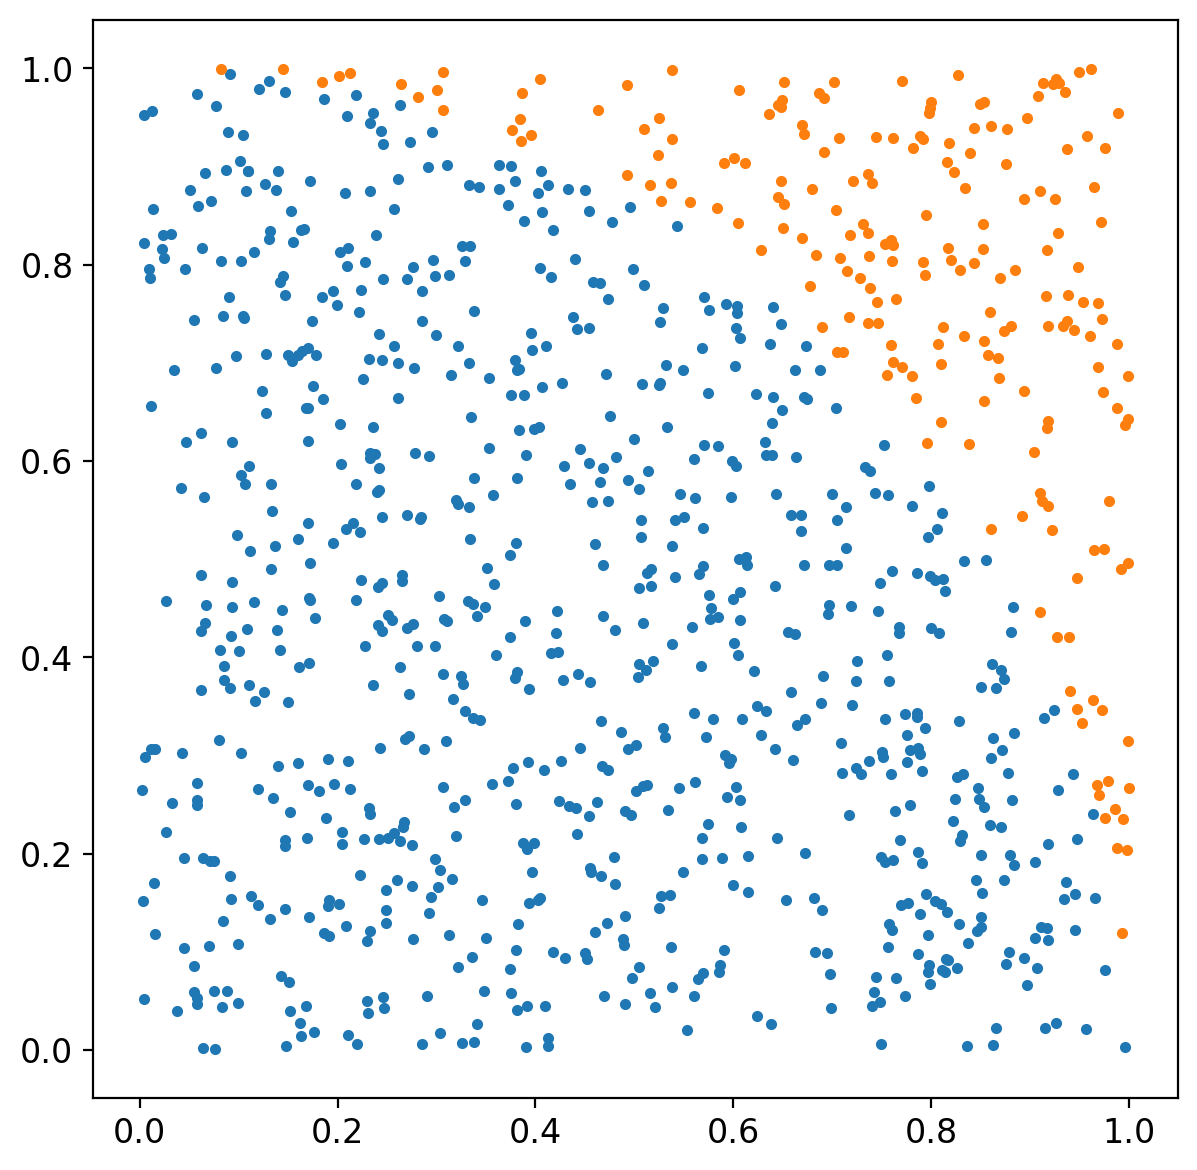

In [4]:
#>>>RUN: L20.1-runcell01

#First let's just compute the area of a quarter circle with radius 1
def quarterarea(iN):
    area=0
    lXin = np.array([])
    lYin = np.array([])
    lXout = np.array([])
    lYout = np.array([])
    for i0 in range(iN):
        #Sample X and Y
        pX = np.random.uniform(0,1)
        pY = np.random.uniform(0,1)
        #Check if its radius is in 1
        if np.sqrt(pX**2+pY**2) < 1:
            lXin = np.append(lXin,pX)
            lYin = np.append(lYin,pY)
            area += 1 # count it
        else:
            lXout = np.append(lXout,pX)
            lYout = np.append(lYout,pY)
    print(area)
    return (float(area)/float(iN)),lXin,lYin,lXout,lYout

#sample points
lN=1000
#lN=100000
a,lXin,lYin,lXout,lYout=quarterarea(lN)
print("Pi (4*area) :",f"{a*4:.6f}","+/-",f"{4*a/math.sqrt(lN):.6f}") #gotta put an uncertainty
print("Exact answer:",f"{np.pi:.6f}","\nRatio - 1:",f"{(a*4/np.pi)-1.0:.6f}","+/-",f"{4*a/(np.pi*math.sqrt(lN)):.6f}")

#Make the plots square so the quarter circle looks like a circle
plt.rcParams['figure.figsize'] = (7,7)

plt.plot(lXin,lYin,marker='.',linestyle = 'None')
plt.plot(lXout,lYout,marker='.',linestyle = 'None')
plt.show()

#Revert to default plot aspect ratio
plt.rcParams['figure.figsize'] = (9,6)

[ymin,ymax]: -803.3955308824271 -12.499898490291134


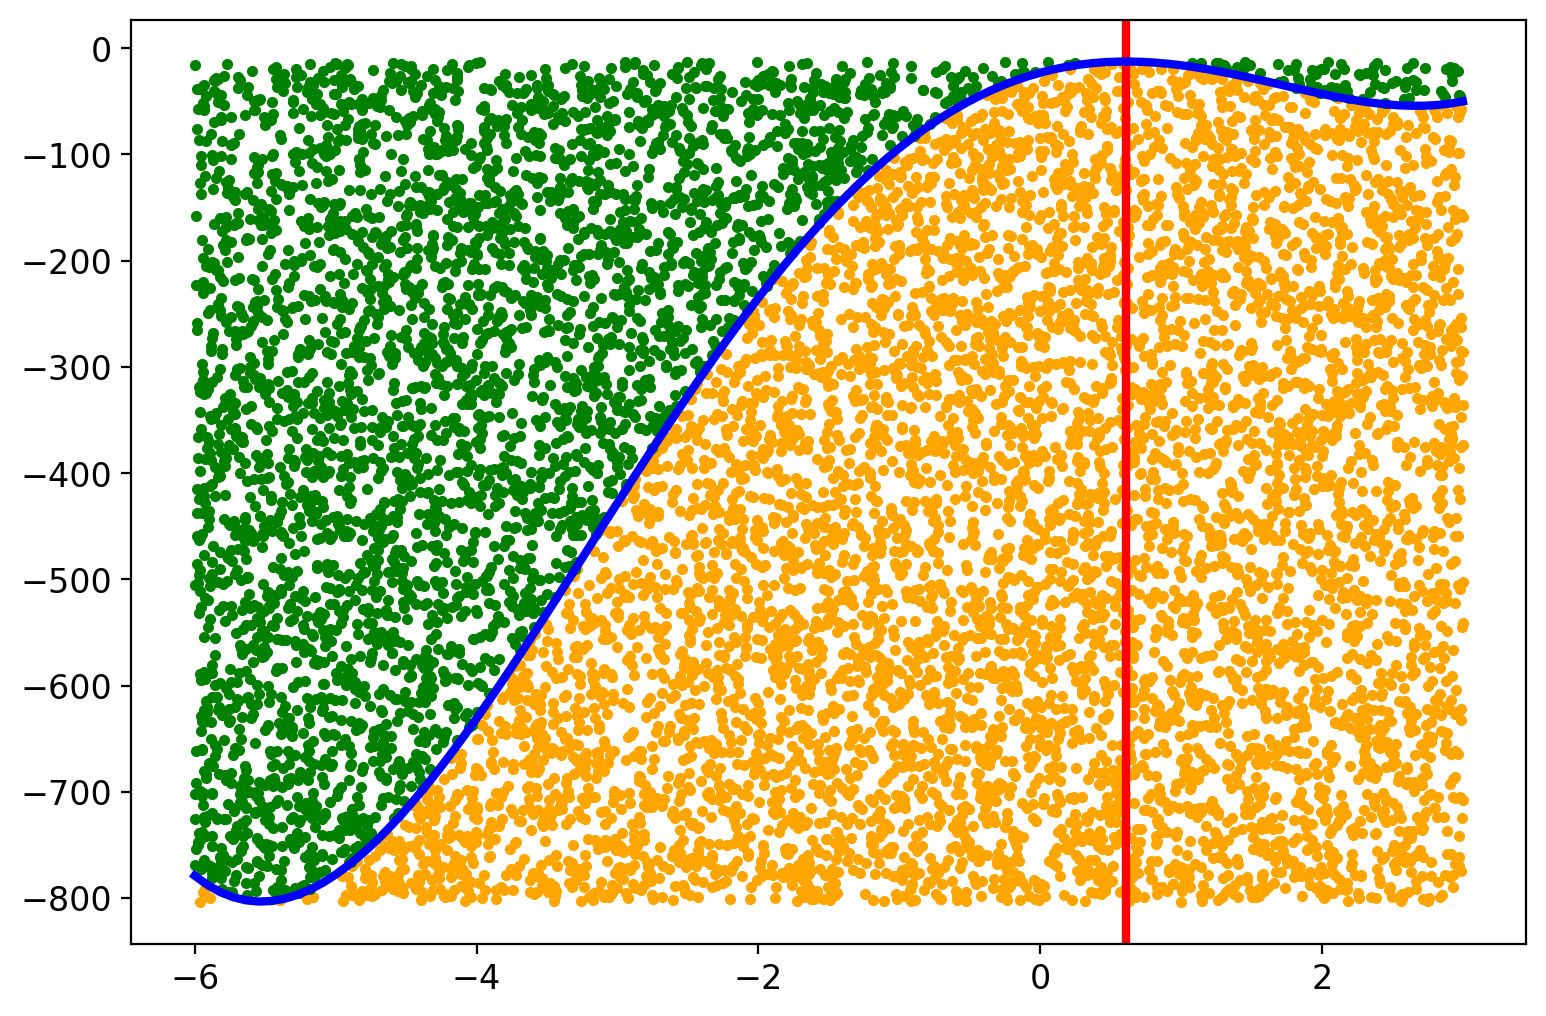

In [5]:
#>>>RUN: L20.1-runcell02


#use this random seed
np.random.seed(10)

#Now let's consider integrating some random function
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

#Now let's multiply it by -1 to make the range calculation fast
def fneg(x):
    return -1*(x**4 + 3*(x-2)**3 - 15*(x)**2 + 1)


#First thing is to define a range in x
xmin=-6
xmax=3
x = np.linspace(xmin, xmax, 100)
plt.plot(x, f(x));
#plt.show()


#Now we need to find a range in y
sol=opt.minimize_scalar(f,bounds=(xmin, xmax))#, method='Brent')
ymin=sol.fun
#y-max is to get the minimum of negative f
sol=opt.minimize_scalar(fneg,bounds=(xmin, xmax))#, method='Brent')
ymax=-1*sol.fun

print('[ymin,ymax]:', ymin, ymax)

"""
#Now we need to find a range in y
ymin=min(f(x))
ymax=max(f(x))
print('[ymin,ymax]:', ymin, ymax)
"""

lN=10000
#now, let's sample a 2D grid y-min and y-max and compute the integral
lXin = np.array([])
lYin = np.array([])
lXout = np.array([])
lYout = np.array([])
for i0 in range(lN):
    #Try a uniform distribution
    pX = abs(xmax-xmin)*np.random.uniform(0,1)+xmin
    pY = abs(ymax-ymin)*np.random.uniform(0,1)+ymin
    #Try a normal distribution
    #pX = abs(xmax-xmin)*np.random.normal(0,1)+xmin
    #pY = abs(ymax-ymin)*np.random.normal(0,1)+ymin
    pYMin = f(pX)
    if pY < pYMin:
        lXin = np.append(lXin,pX)
        lYin = np.append(lYin,pY)
    else:
        lXout = np.append(lXout,pX)
        lYout = np.append(lYout,pY)


plt.plot(lXin,lYin,marker='.',linestyle = 'None', color='orange')
plt.plot(lXout,lYout,marker='.',linestyle = 'None', color='green')
plt.axvline(sol.x, c='red', lw=3)
plt.plot(x, f(x), 'b-', lw=3)
#plt.ylim(-800,0)
#plt.xlim(-6,3)
plt.show();

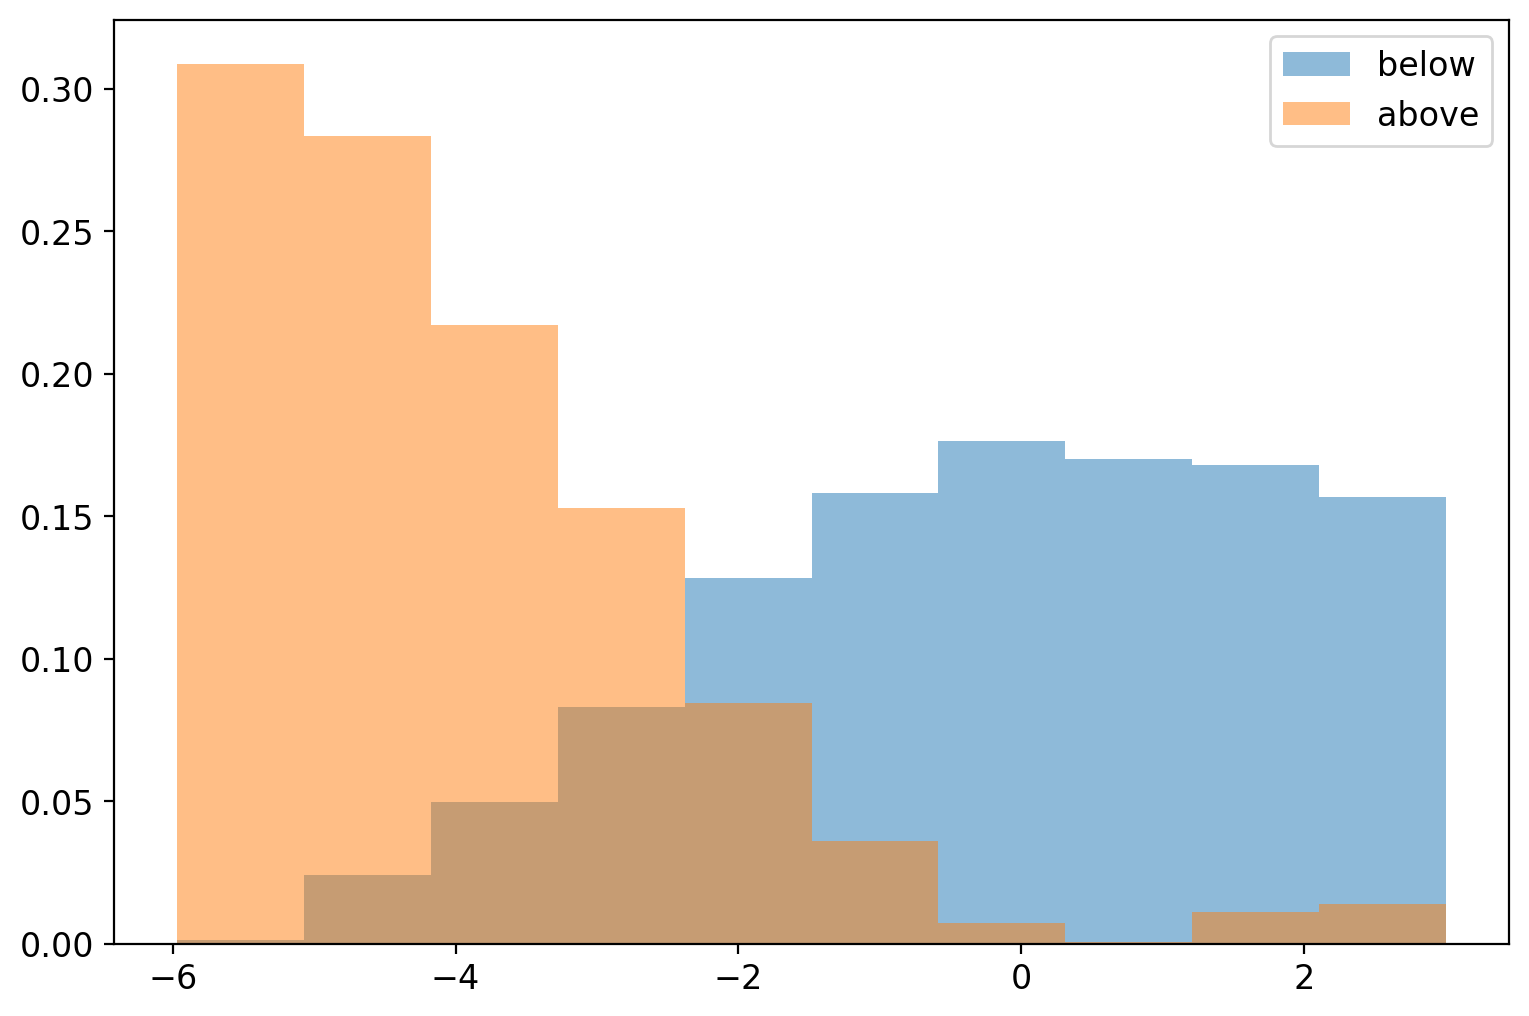

number below: 6395 number above: 3605


In [6]:
#>>>RUN: L20.1-runcell03

_,bins,_= plt.hist(lXin,bins=10,alpha=0.5,density=True, label='below') #blue in histogram
plt.hist(lXout,alpha=0.5,bins=bins,density=True, label='above') #orange in histogram
#plt.xlim(-6,3)
plt.legend(loc=1)
plt.show();

print("number below:",len(lXin),"number above:",len(lXout))

<a name='exercises_21_1'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_1) | [Next Section](#section_21_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.1.1</span>


How would you compute the integral of the function given in code cell `L20.1-runcell02` over the range `[-6,3]`? Select the correct answer below, where the numbers above and below the line refer to the output of code cell `L20.1-runcell03`. Think carefully about how one might need to consider negative signs in each case.


A) The integral is equal to the total area sampled times the fraction of the points above the line defined by our function.\
B) The integral is the negative of the quantity given in option A.\
C) The integral is equal to the total area sampled times the fraction of the points below the line defined by our function.\
D) The integral is the negative of the quantity given in option C.\
E) To calculate the integral using the number of points above and below the line found by code cell `L20.1-runcell03`, corrections need to be made for the fact that $y_{max}$ is not zero.\
F) To calculate the integral using the number of points above and below the line found by code cell `L20.1-runcell03`, corrections need to be made for the region with negative $x$ values.\
G) To calculate the integral using the number of points above and below the line found by code cell `L20.1-runcell03`, corrections need to be made for the issues mentioned in both options E and F.


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.1.2 </span>

Calculate the integral of this function using the Monte Carlo method outlined above, and report your answer as a number with precision `1e-2`. In order to compare your answer to ours, use the same conditions as defined above, namely:

<pre>
#use this random seed
np.random.seed(10)

#use this array of x-values
xmin=-6
xmax=3
x = np.linspace(xmin, xmax, 100)

#use this number of points
lN=10000
</pre>

<b>Remember to correctly apply a negative sign, if applicable!</b>

How does your numerically calculated value compare to the expected value? You can explicitly solve the integral mathematically, or use a built-in `scipy` integration method (e.g., `scipy.integrate.quad`) to compare to your Monte Carlo integration.

Bonus: Write a Monte Carlo integrator that computes the definite integral of any generic function.

In [12]:
#>>>EXERCISE: L20.1.2

#define the fraction of points above the function
frac_above = len(lXout) / (len(lXout) +len (lXin) )

#define the total area of the integration region,
#i.e., where the points are distributed
area = (ymax-ymin) * (xmax-xmin)

#define an adjustment to the total area
#since the function in this range is
#completely below the y-axis
adjust = abs (ymax) *(xmax-xmin)

#define the integral using the terms above
MC_integal =  -(area*frac_above + adjust)

print('Monte Carlo integration:', MC_integal)

#COMPARE TO PRE-DEFINED NUMERICAL INTEGRATOR
# call quad to integrate f from -6 to 3
builtin_int, err = quad (f, -6, 3)

print('Numerical integration:', builtin_int)
print('Ratio of MC/exact:',MC_integal/builtin_int)

Monte Carlo integration: -2678.559965708905
Numerical integration: -2673.4500000000003
Ratio of MC/exact: 1.0019113750804785


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.1.3 </span>

To get a more accurate answer using the Monte Carlo integration method that we just explored, which of the following approaches could you implement? Select ALL that apply.

A) Increase the number of random points sampled.\
B) Average over several different trials, using different starting random seeds.\
C) Modify the code to generate more samples in the regions where the function varies most steeply.


<a name='section_21_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.2 Monte Carlo Diffusion</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_1) | [Exercises](#exercises_21_2) | [Next Section](#section_21_3) |

Mean distance from the starting point 2.1548338868275305
Standard deviation of the distance in x: 1.7277302783197845 y: 1.7015658796349895
Mean magnitude of the velocity 1.2618411200173796


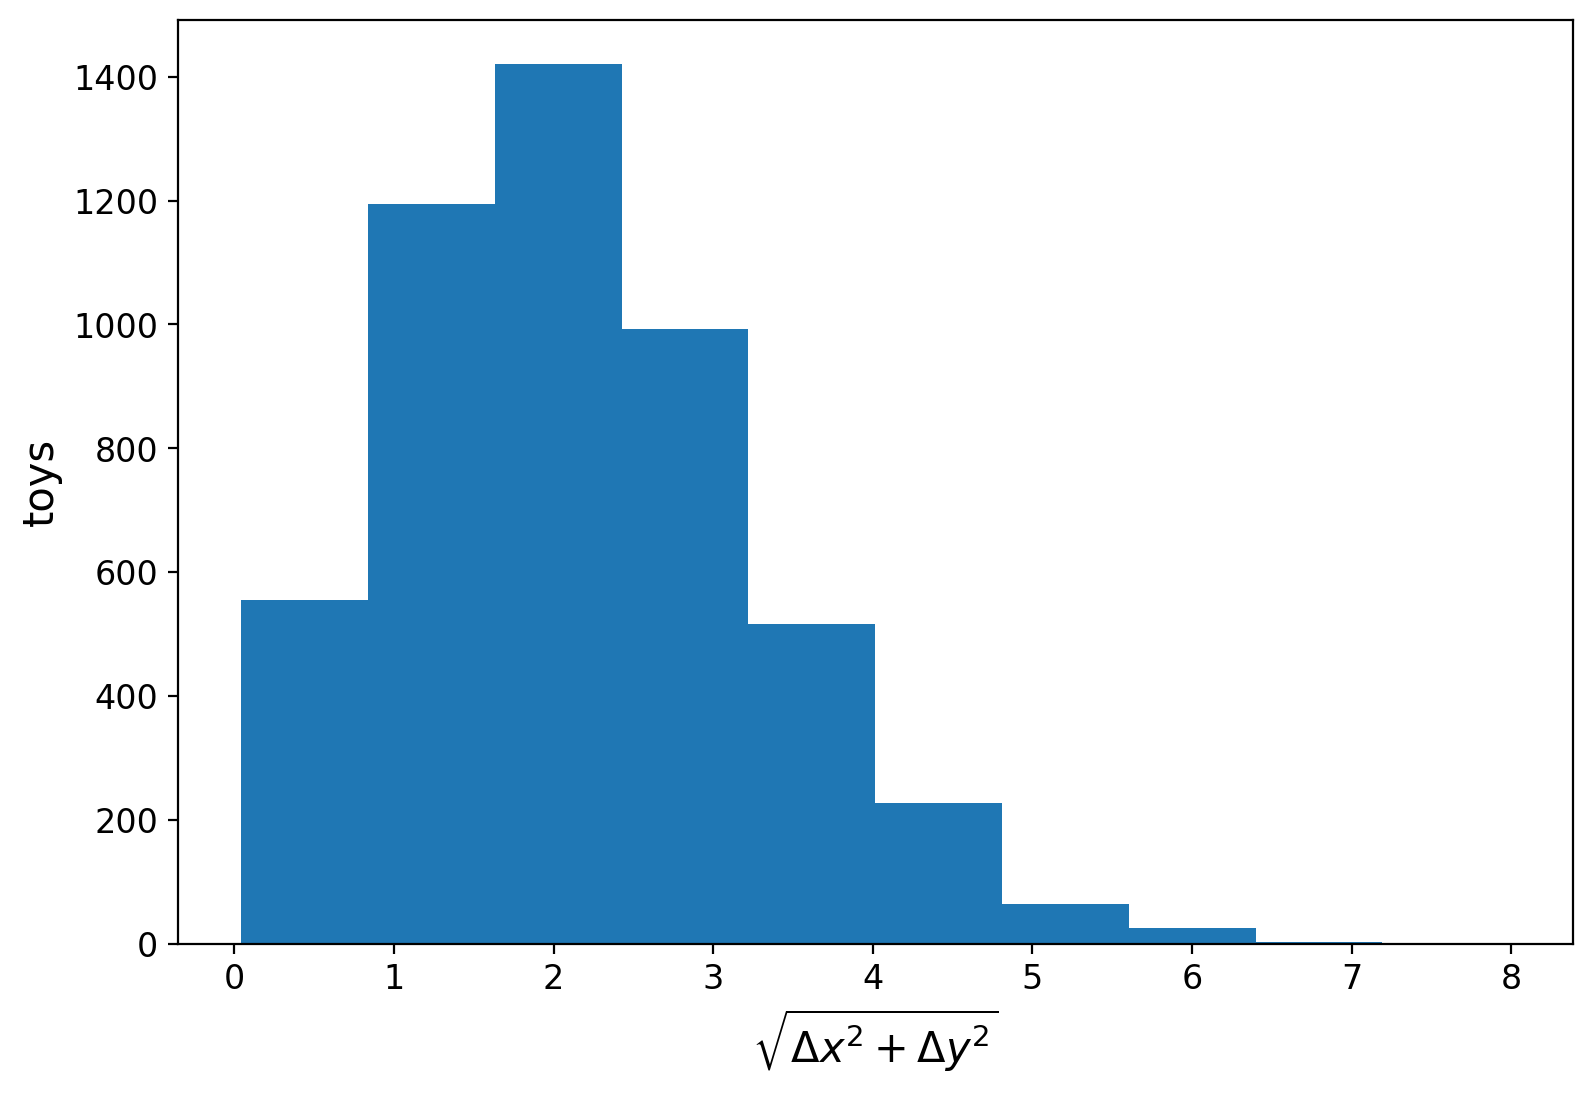

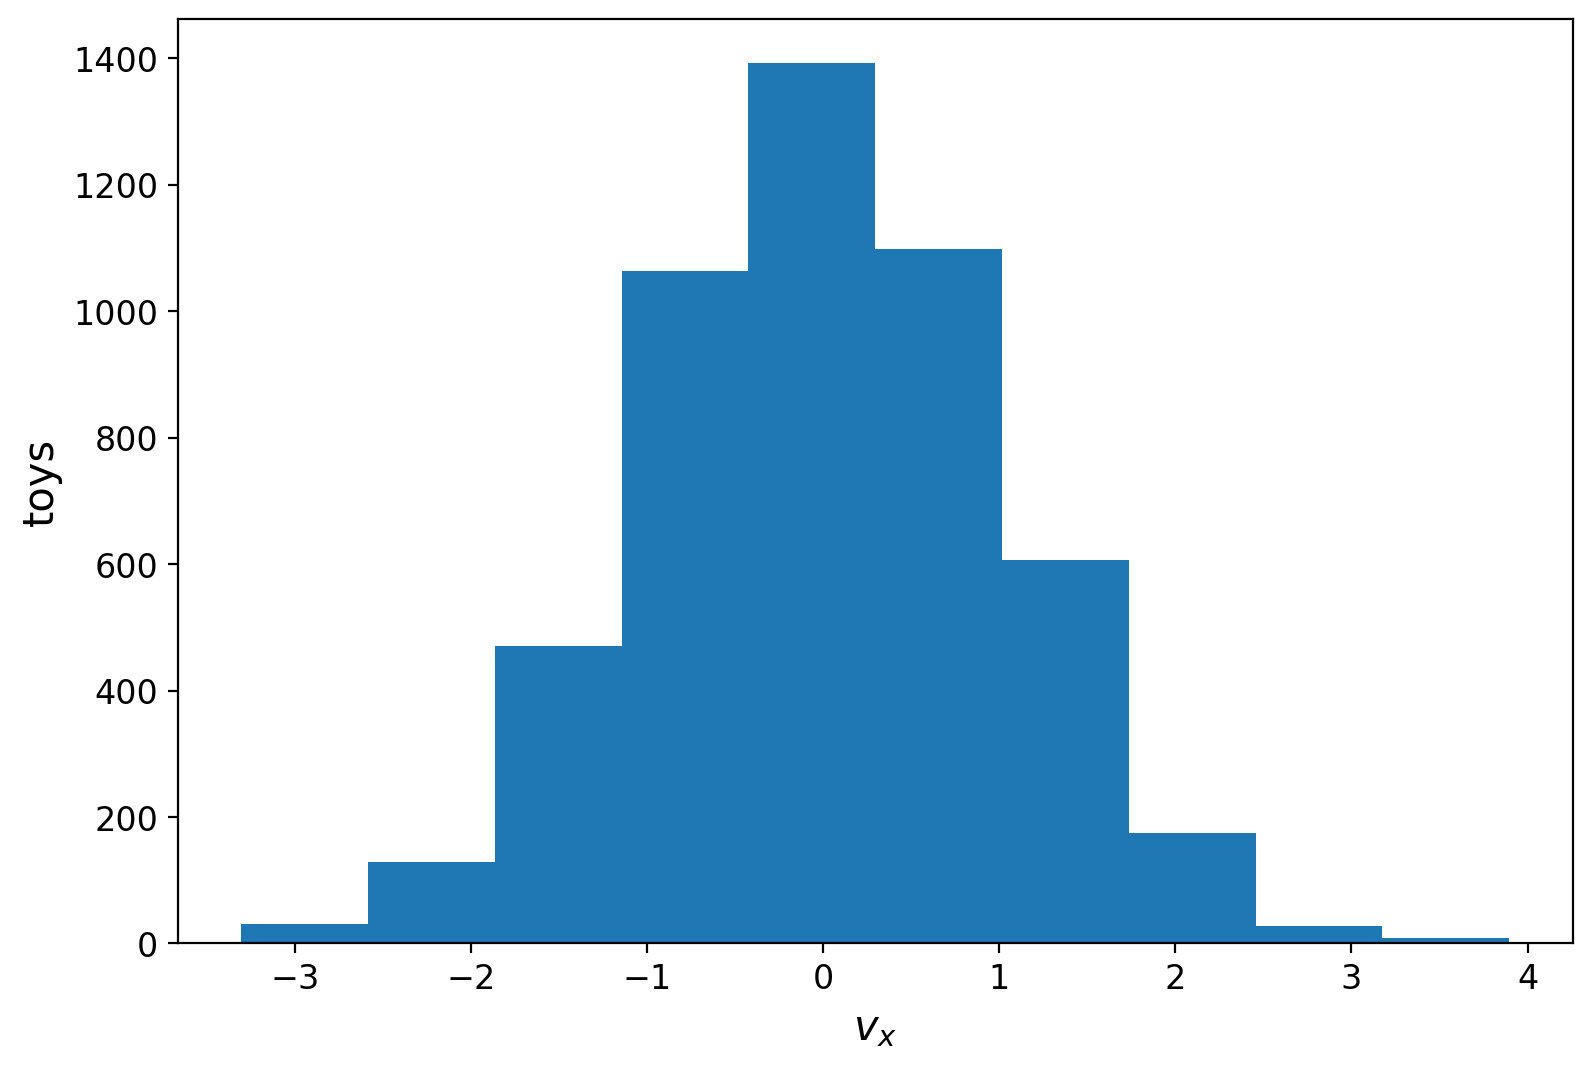

In [13]:
#>>>RUN: L20.2-runcell01

def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2)) #let's assume all particles are randomly distributed
    for t0 in range(nsteps):
        partpos += partvel*dt
        #now at each step we will assume the particle collides with another
        opartvel = np.random.normal(0,1,(ntoys,2)) #Sample the "other" particles momentum
        comvel   = 0.5*(partvel + opartvel) #Now compute the comoving velocities in the COM frame
        difvel   = 0.5*(partvel - opartvel) #Now compute the collision velocity in the COM frame
        theta = np.random.uniform(0,2.*np.pi,ntoys)#elastic collisions in the COM equate to equal energy ad a theta rotation
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        #shape things so they are right
        RMat  = np.swapaxes(R,0,2)
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel) #Now rotate the colliding velocities over all toys
        partvel = comvel+tmp

    if iDump:
        plt.hist(np.sqrt(partpos[:,0]**2+partpos[:,1]**2))
        plt.xlabel("$\sqrt{\Delta x^2 + \Delta y^2}$")
        plt.ylabel("toys")
        print("Mean distance from the starting point",np.mean(np.sqrt(partpos[:,0]**2+partpos[:,1]**2)))
        print("Standard deviation of the distance in x:",np.std(partpos[:,1]),"y:",np.std(partpos[:,0]))
        print("Mean magnitude of the velocity",np.mean(np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))
        plt.show()
        plt.hist(partvel[:,0])
        plt.xlabel("$v_{x}$")
        plt.ylabel("toys")
        plt.show()

#MCSim(nsteps=1) #perform only one step
MCSim() #perform default number of steps

In [14]:
#>>>RUN: L20.2-runcell02

print("Rayleigh",np.sqrt(np.pi/2))
print("Rayleigh dt sqrt(N pi)",np.sqrt(np.pi/2)*np.sqrt(2)*0.01*np.sqrt(10000))
print("Expected mean distance from the center: ",np.sqrt(np.pi/2)*np.sqrt(2)*0.01*np.sqrt(10000)*np.sqrt(np.pi/2))


Rayleigh 1.2533141373155001
Rayleigh dt sqrt(N pi) 1.772453850905516
Expected mean distance from the center:  2.221441469079183


<a name='exercises_21_2'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_2) | [Next Section](#section_21_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.2.1</span>

What happens to the velocity distribution as we run our simulation over many time steps? Complete the function below, which is just a slight change to the function `MCSim` above, to compare the total velocity before and after, then choose the best option below:

A) There is at most only a very small change which is not statistically significant.\
B) After a long time, the velocity decreases\
C) After a long time, the velocity increases.

Mean distance from the starting point 2.1687255035405637
Standard deviation of the distance in x: 1.7268981052185424 y: 1.7415198243019838
Mean magnitude of the velocity 1.2597058214926737


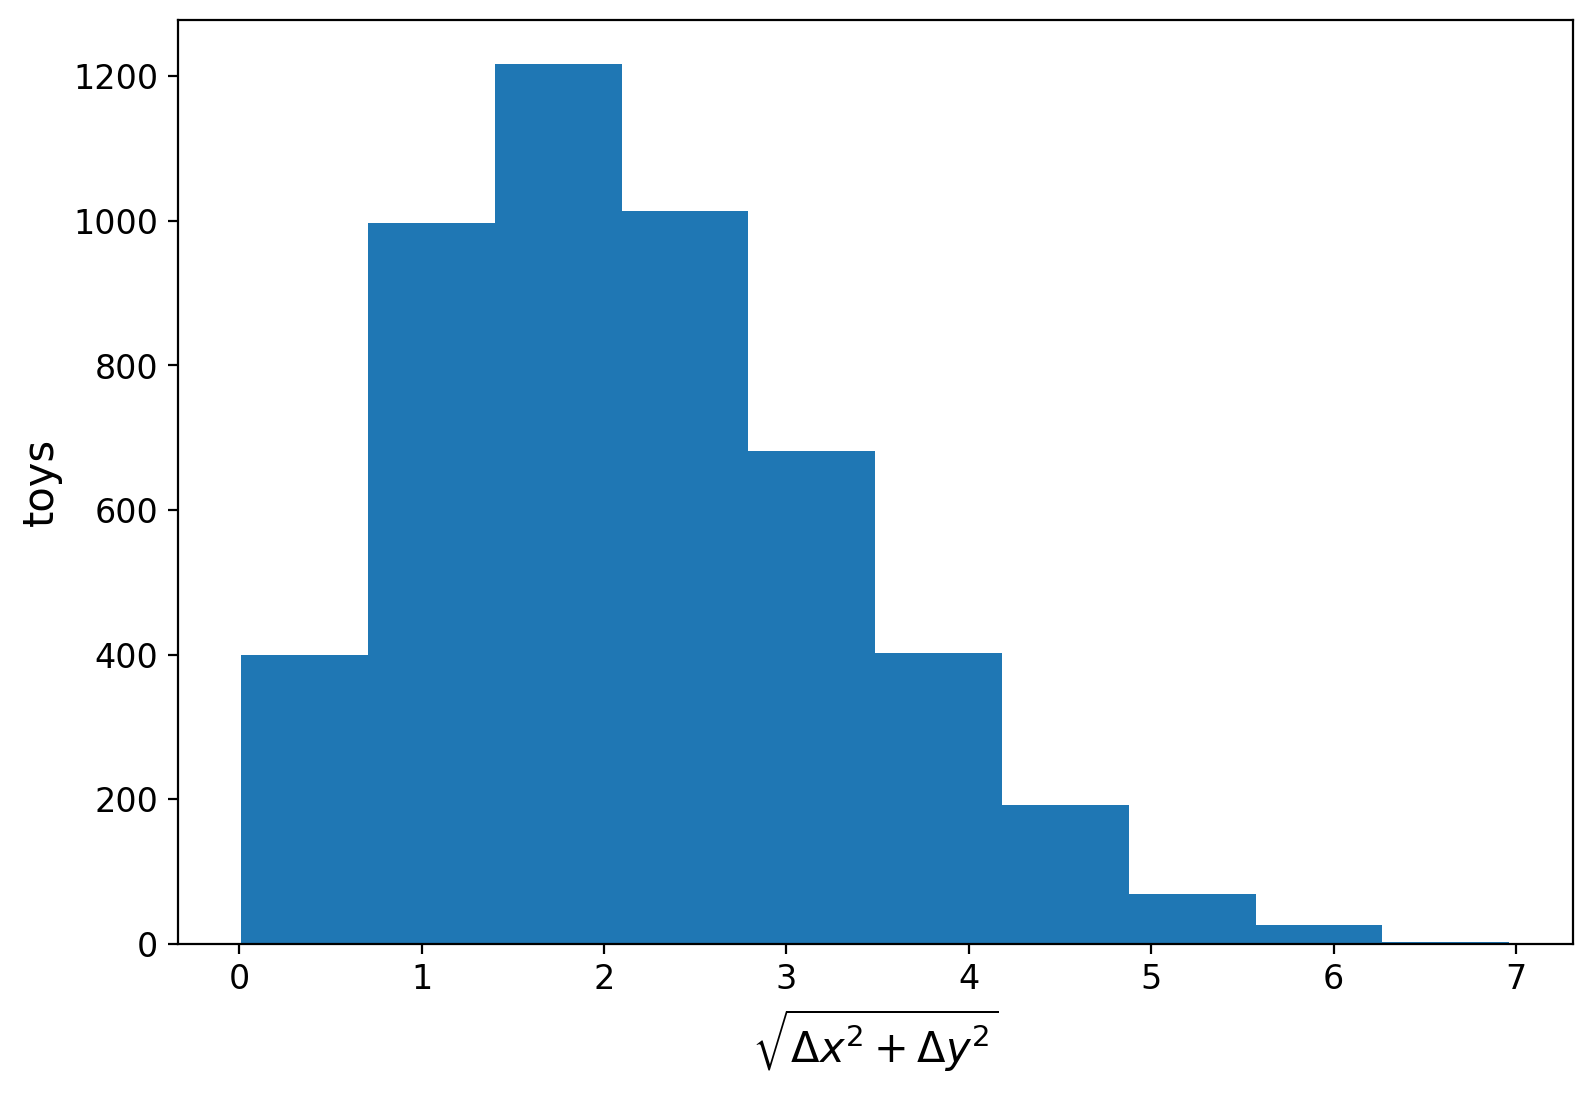

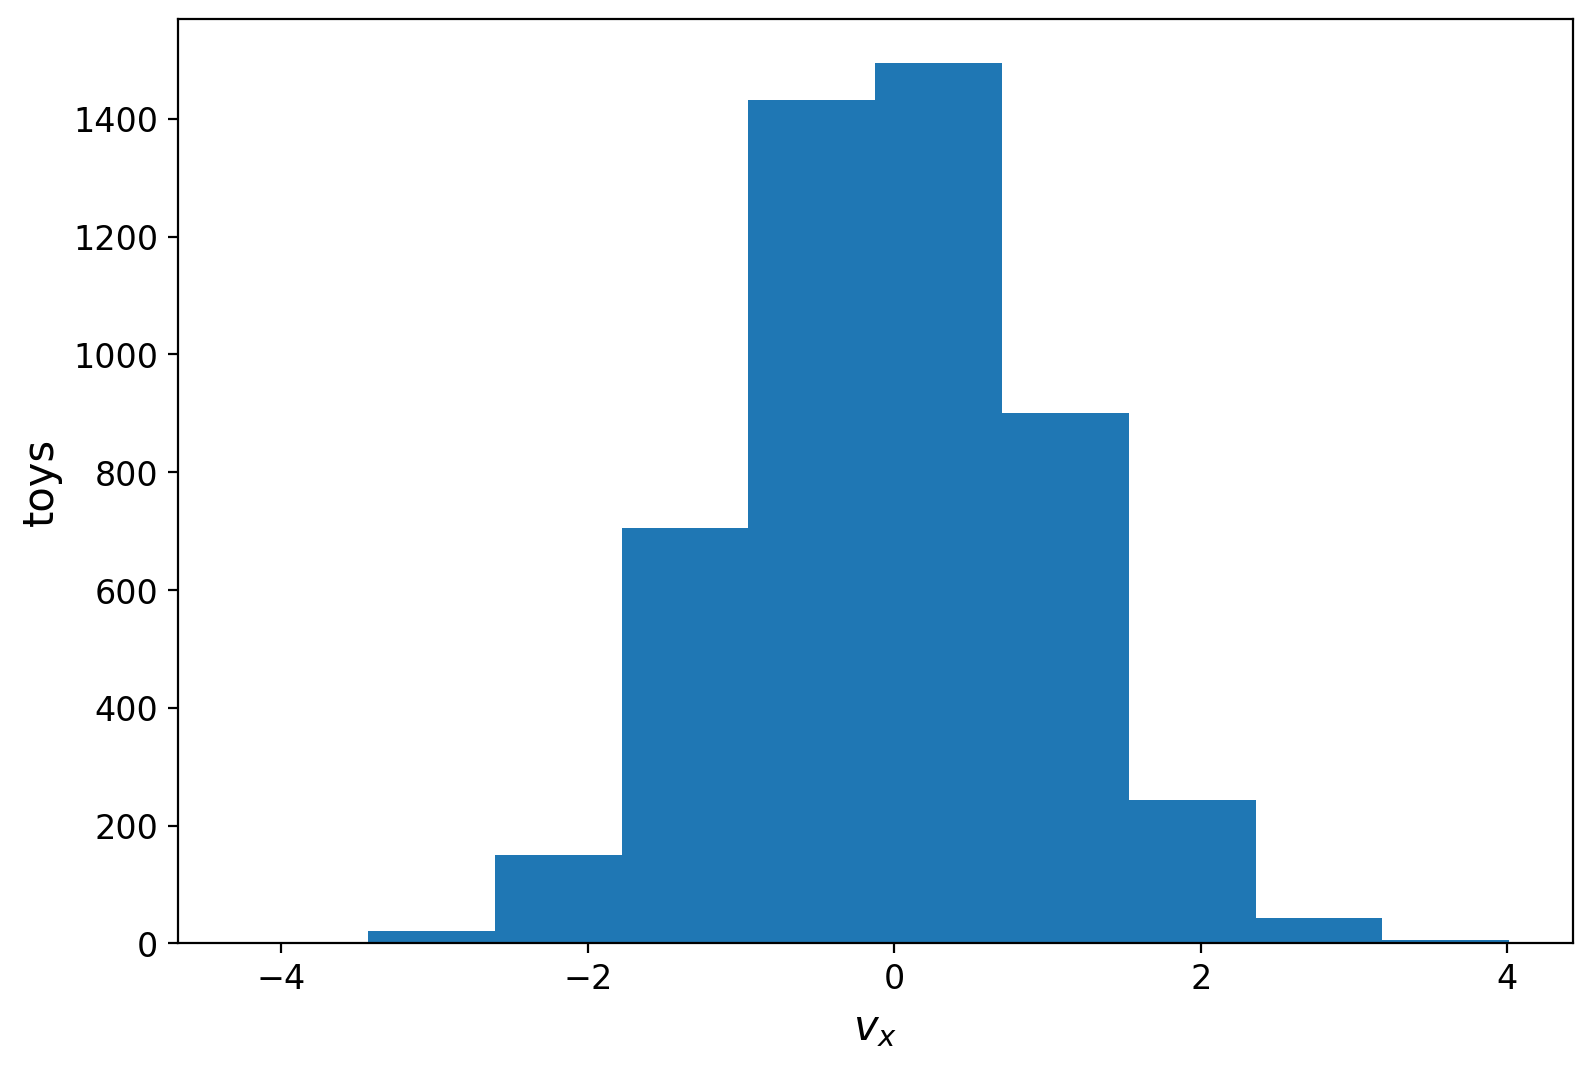

In [19]:
#>>>EXERCISE: L20.2.2

def MCSim_compare(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2))
    print ("velocity before:", np.mean(np.sqrt(partvel[:,0]**2+partvel[:, 1]**2)) )

    for t0 in range(nsteps) :
          opartvel = np.random.normal(0,1, (ntoys,2))
          partpos += partvel*dt
          comvel   = 0.5*(partvel + opartvel)
          difvel   = 0.5*(partvel - opartvel)
          theta    = np.random.uniform(0,2.*np.pi,ntoys)
          R        = np.array(( (np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos (theta) )))
          RMat = np. swapaxes (R,0,2)
          tmp=np. einsum( 'BNi,Bi ->BN', RMat, difvel)
          partvel = comvel+tmp

    print("velocity after:", np.mean (np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))

MCSim()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.2.2</span>

Consider a microscopic particle undergoing Brownian motion in a fluid. The particle's displacement at each time step follows a random walk pattern due to collisions with surrounding molecules. Which of the following statements about Brownian motion and random walks is/are correct? Select ALL that apply:

A) Brownian motion follows a deterministic trajectory governed by classical mechanics, and the particle's position at any given time can be precisely predicted.

B) In Brownian motion, the particle's path is continuous, smooth, and follows a well-defined trajectory over time.

C) The increments of a random walk in Brownian motion are often modeled as independent, identically distributed Gaussian random variables.

D) Brownian motion violates the conservation of energy principle, leading to erratic behavior that contradicts classical physics.

<a name='section_21_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.3 Adding Elements of Realism</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_2) | [Exercises](#exercises_21_3) | [Next Section](#section_21_4) |

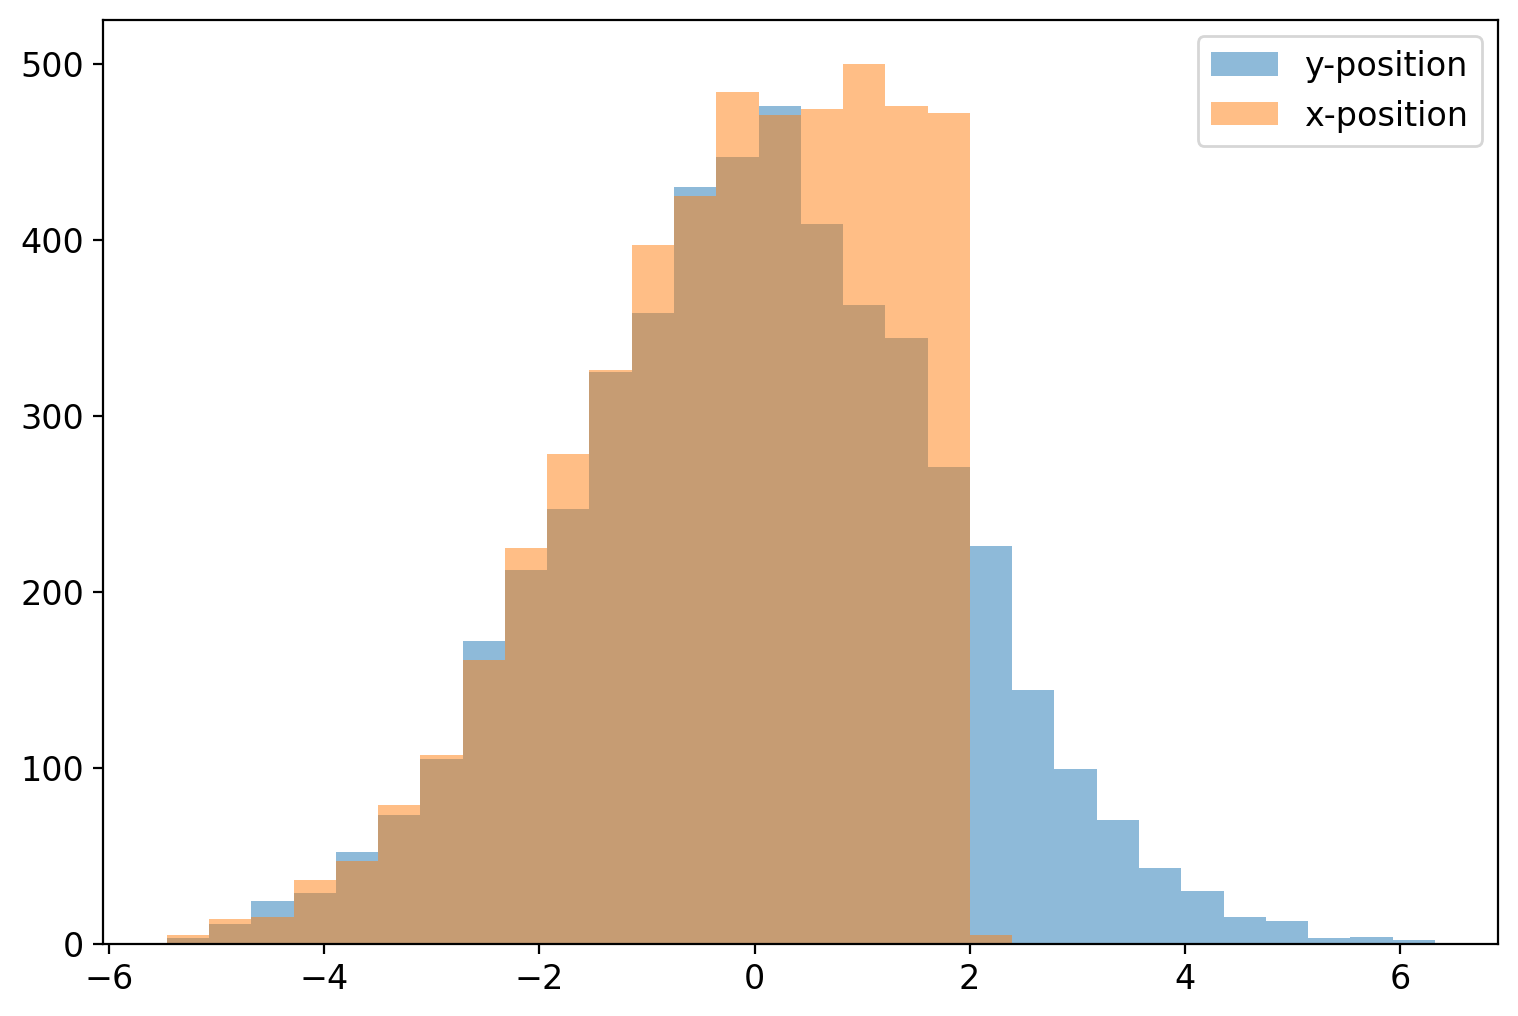

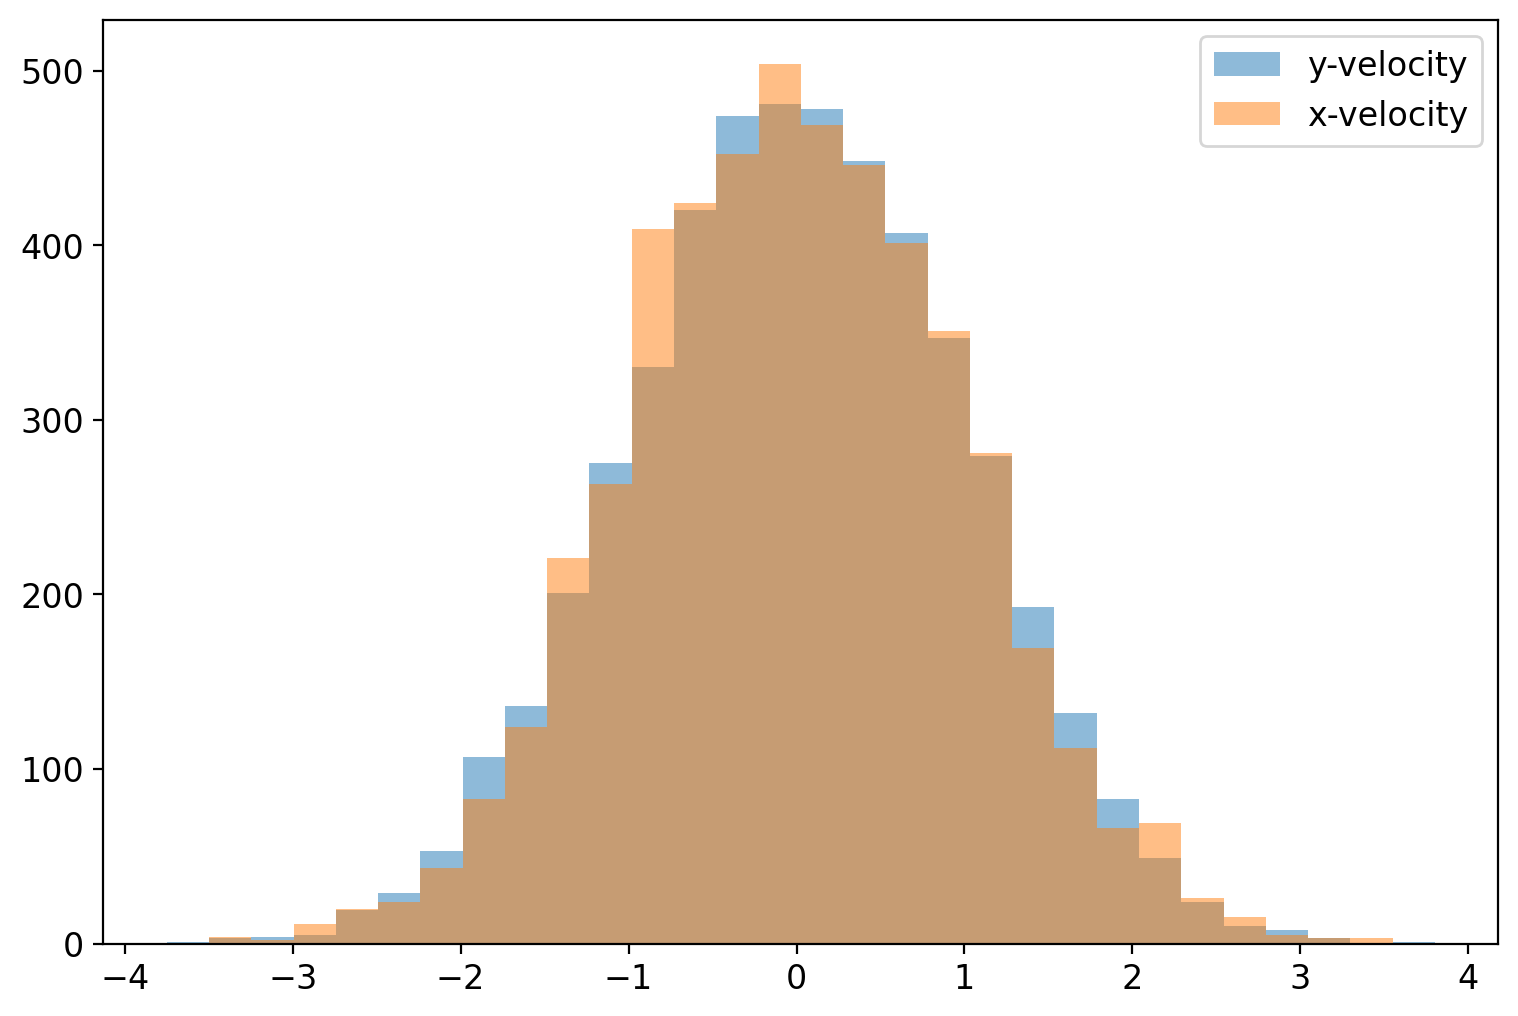

In [20]:
#>>>RUN: L20.3-runcell01

def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,1,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        #Now, let's add our velocity if its not at the well
        partvel[partpos[:,0] < 2] = comvel[partpos[:,0] < 2]+tmp[partpos[:,0] < 2]
        #And let's flip it if it is at the wall
        partvel[partpos[:,0] > 2] = [-1,1]*partvel[partpos[:,0] > 2]

    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()
MCSim()

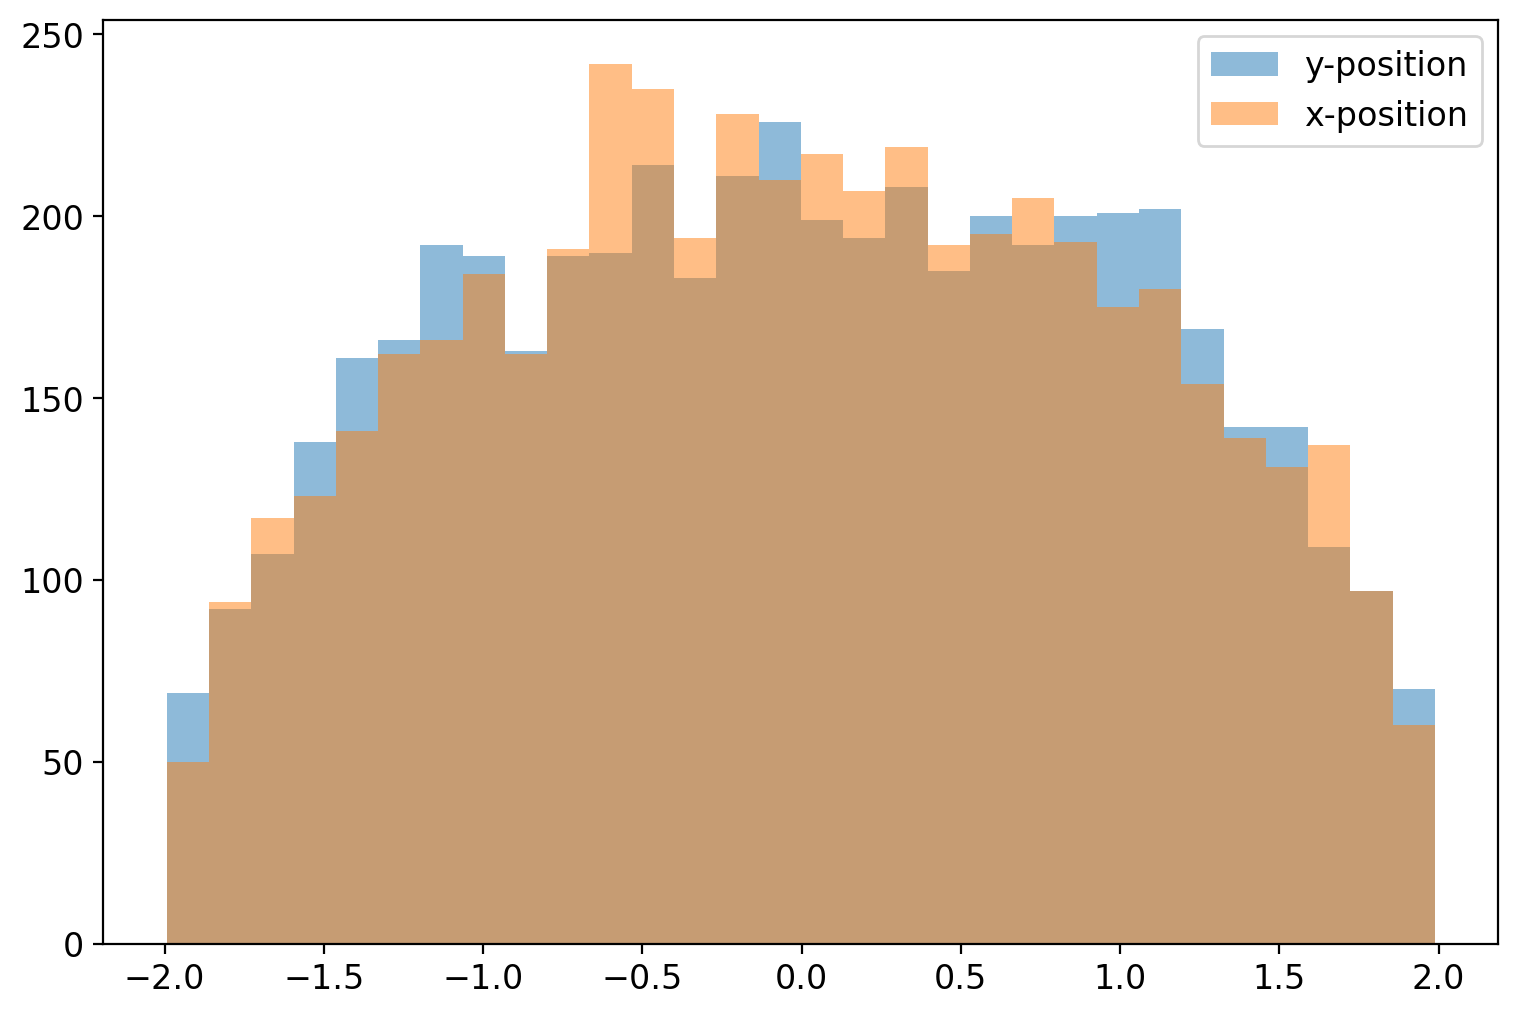

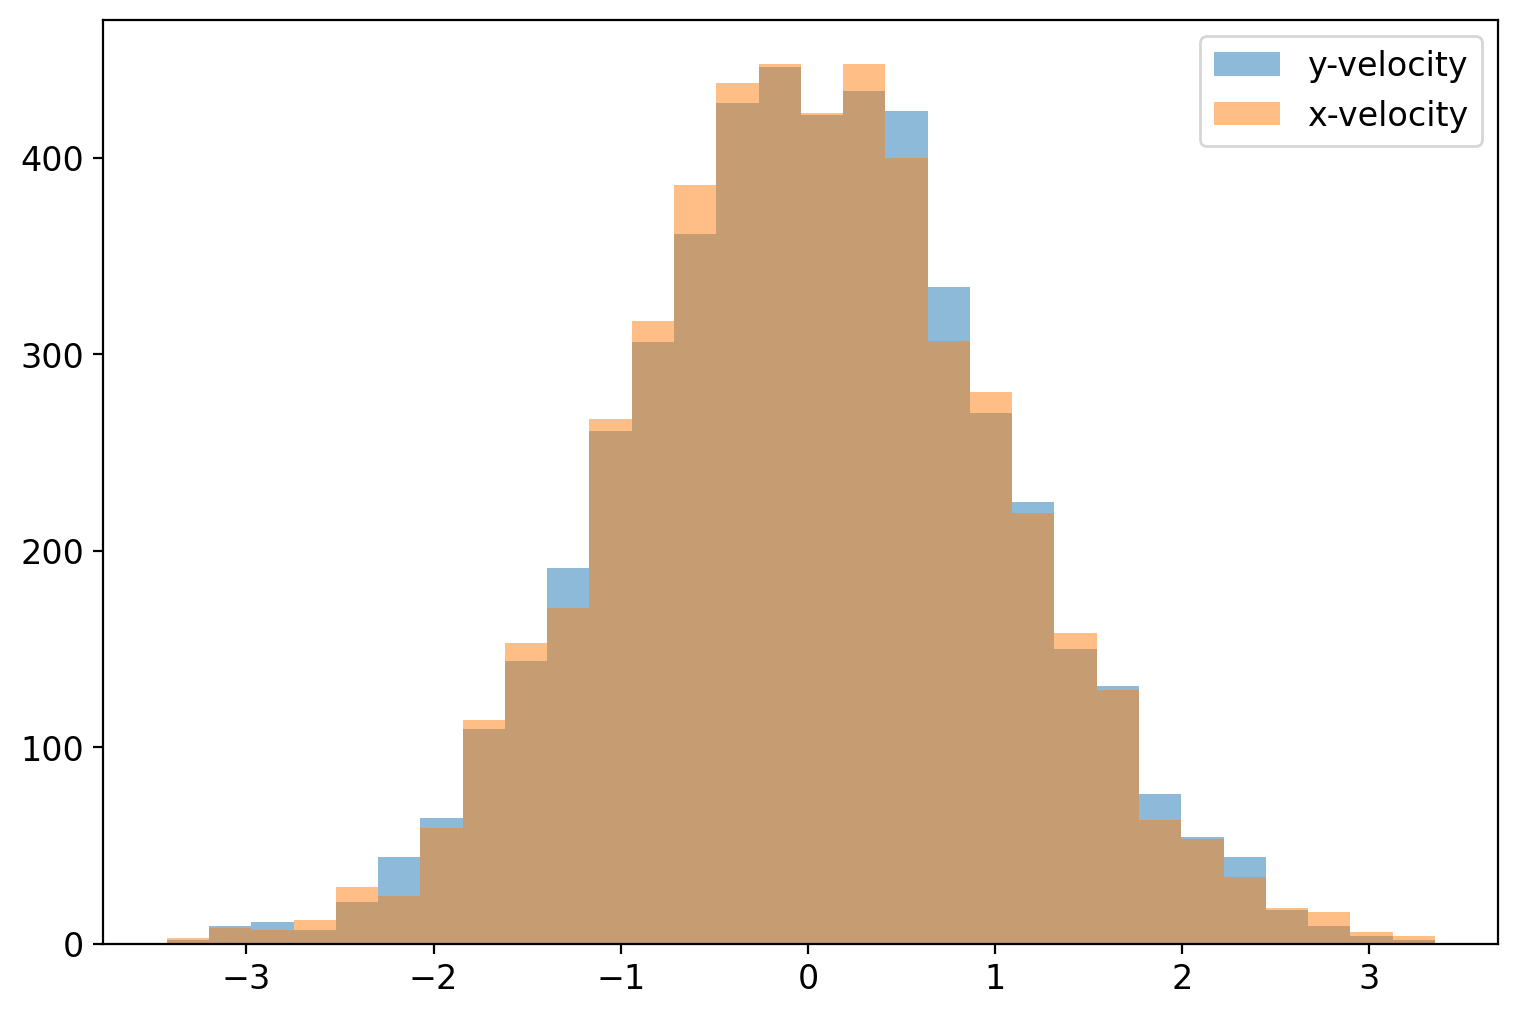

In [21]:
#>>>RUN: L20.3-runcell02

def MCSim_tube(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,rtube=2.0,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,sigmav,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,sigmav,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        #Now define inside the tube
        intube  = partpos[:,0]**2+partpos[:,1]**2 < rtube**2
        partvel[intube]  = comvel[intube]+tmp[intube]
        partvel[~intube] = -partvel[~intube]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()

MCSim_tube()

<a name='exercises_21_3'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_3) | [Next Section](#section_21_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.3.1</span>

For particles in a tube, as simulated in code cell `L20.3-runcell02`, how do the spatial and velocity distributions of the particles change if we increase the velocity spread of the particles (in other words, if we increase `sigmav`)? Complete and run the code below to help answer this question. In order to make the tube less restrictive, set its radius to 10. Select ALL that apply.

Note: To ensure the same approximate number of collisions, one should appropriately increase the time step at lower velocities.

When the velocity spread is broader (i.e., larger `sigmav`),

A) the spatial distribution of particles becomes narrower.

B) the spatial distribution of particles remains the same.

C) the spatial distribution of particles becomes more wider.

D) the distribution of particle velocities becomes narrower.

E) the distribution of particle velocities remains the same.

F) the distribution of particle velocities becomes wider.


sigmav=100


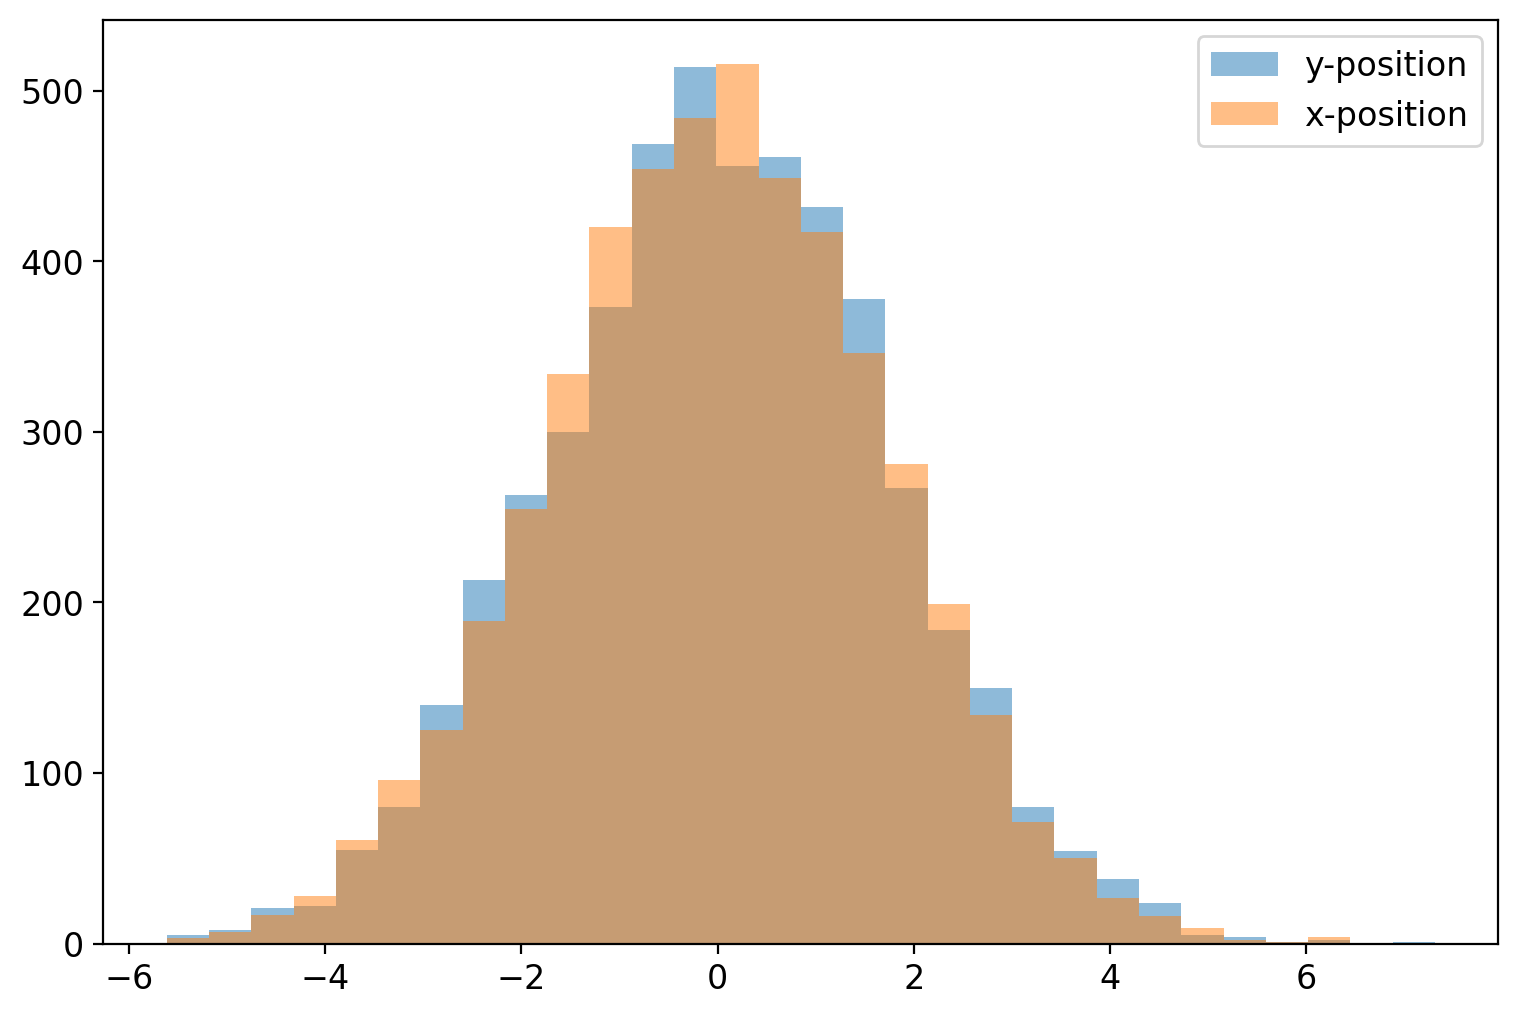

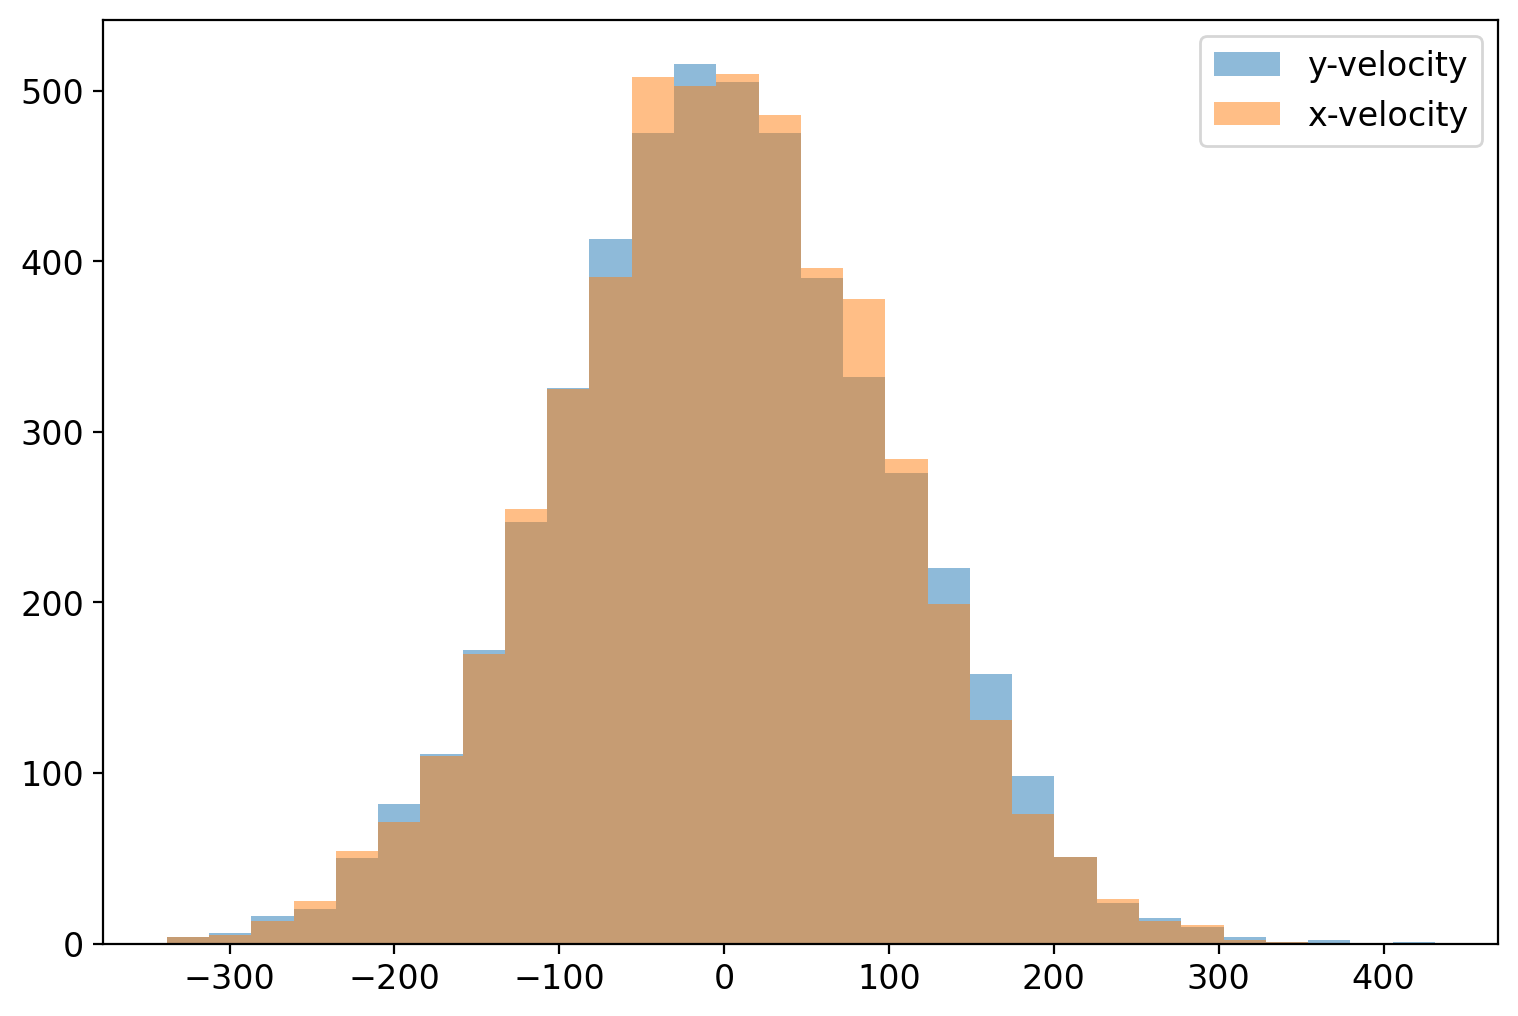


sigmav=1


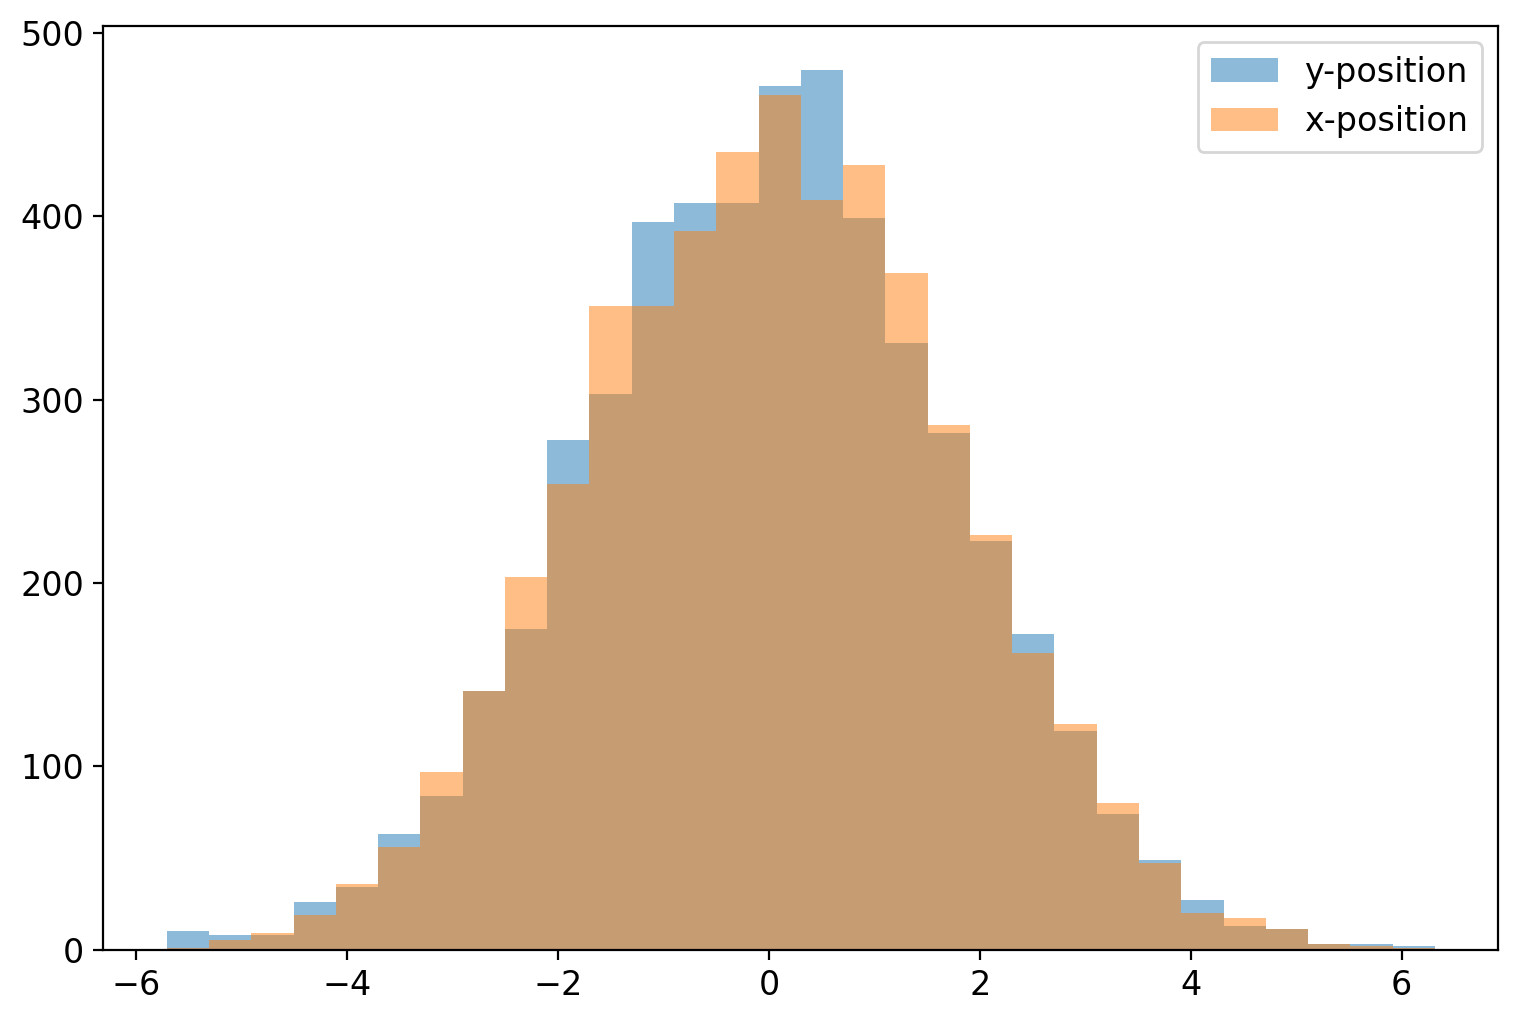

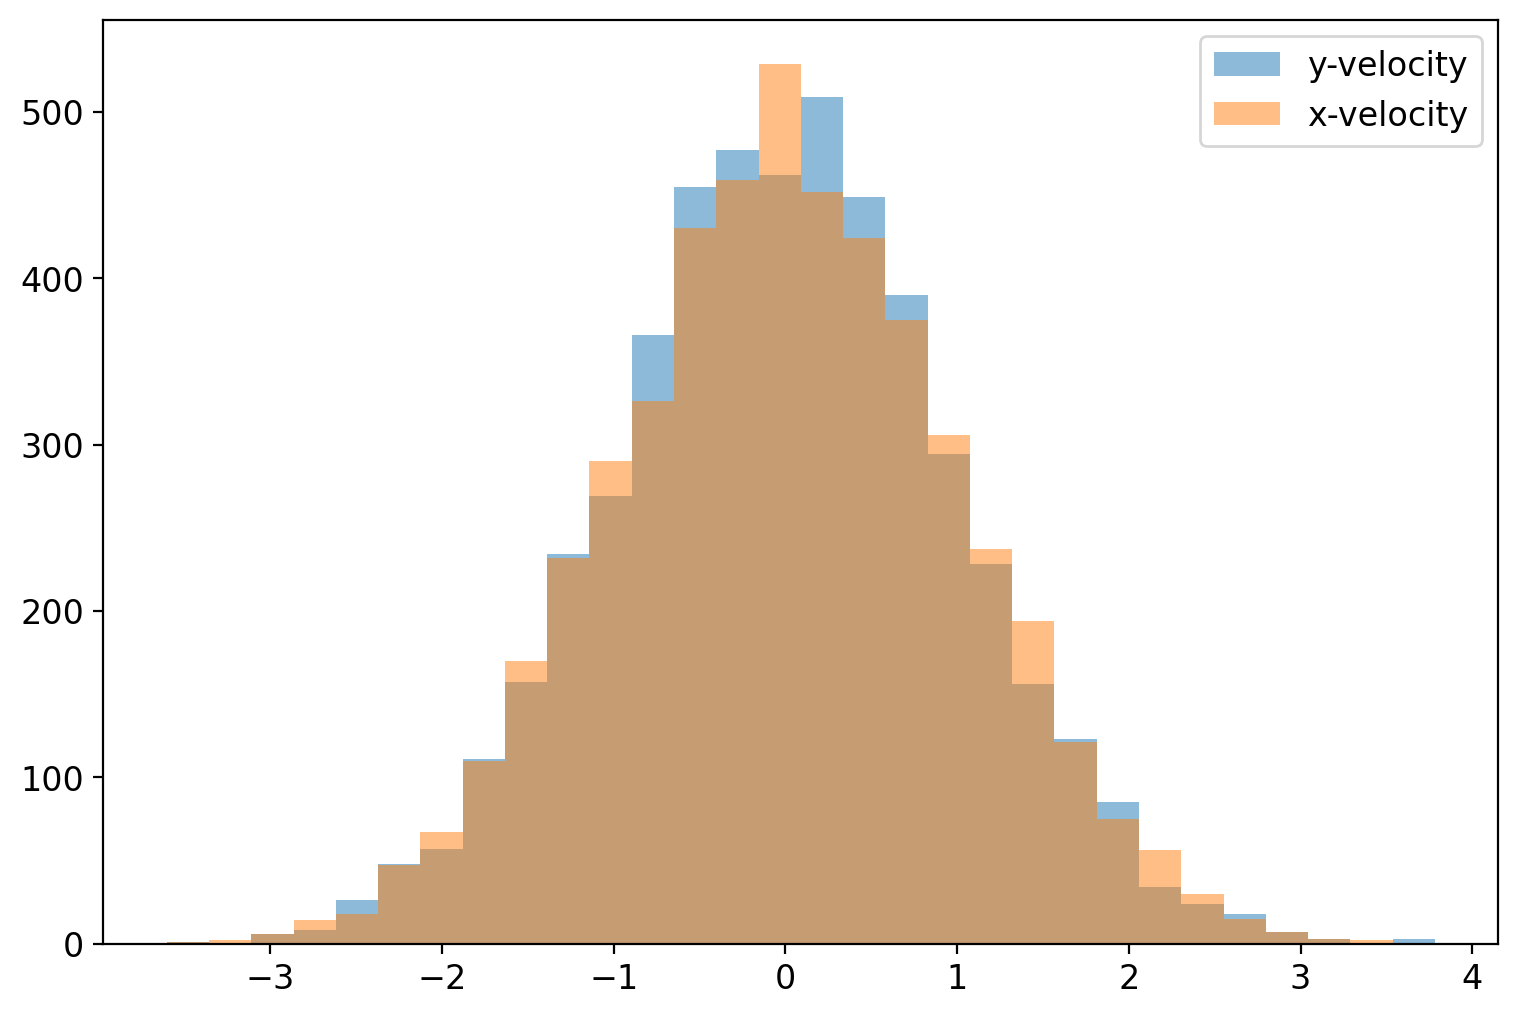

In [26]:
#>>>EXERCISE: L20.3.1

print('sigmav=100')
#RUN `MCSim_tube` with appropriate parameters
MCSim_tube (sigmav=100,nsteps=10000,ntoys=5000,dt=0.0001, rtube=10)

print()

print('sigmav=1')
MCSim_tube (sigmav=1,nsteps=10000,ntoys=5000,dt=0.01, rtube=10)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.3.2</span>

What would the distribution of the particles look like if you had a box with walls at $x=\pm2$ and $y=\pm2$? Edit the `inbox` variables in the code below and run it to help answer this question.

A) The distribution is concentrated around the center of the square.

B) Particle density is higher at the corners of the square.

C) Particles are uniformly distributed in both dimensions.

D) Particles are more likely to be found near the edges of the square.


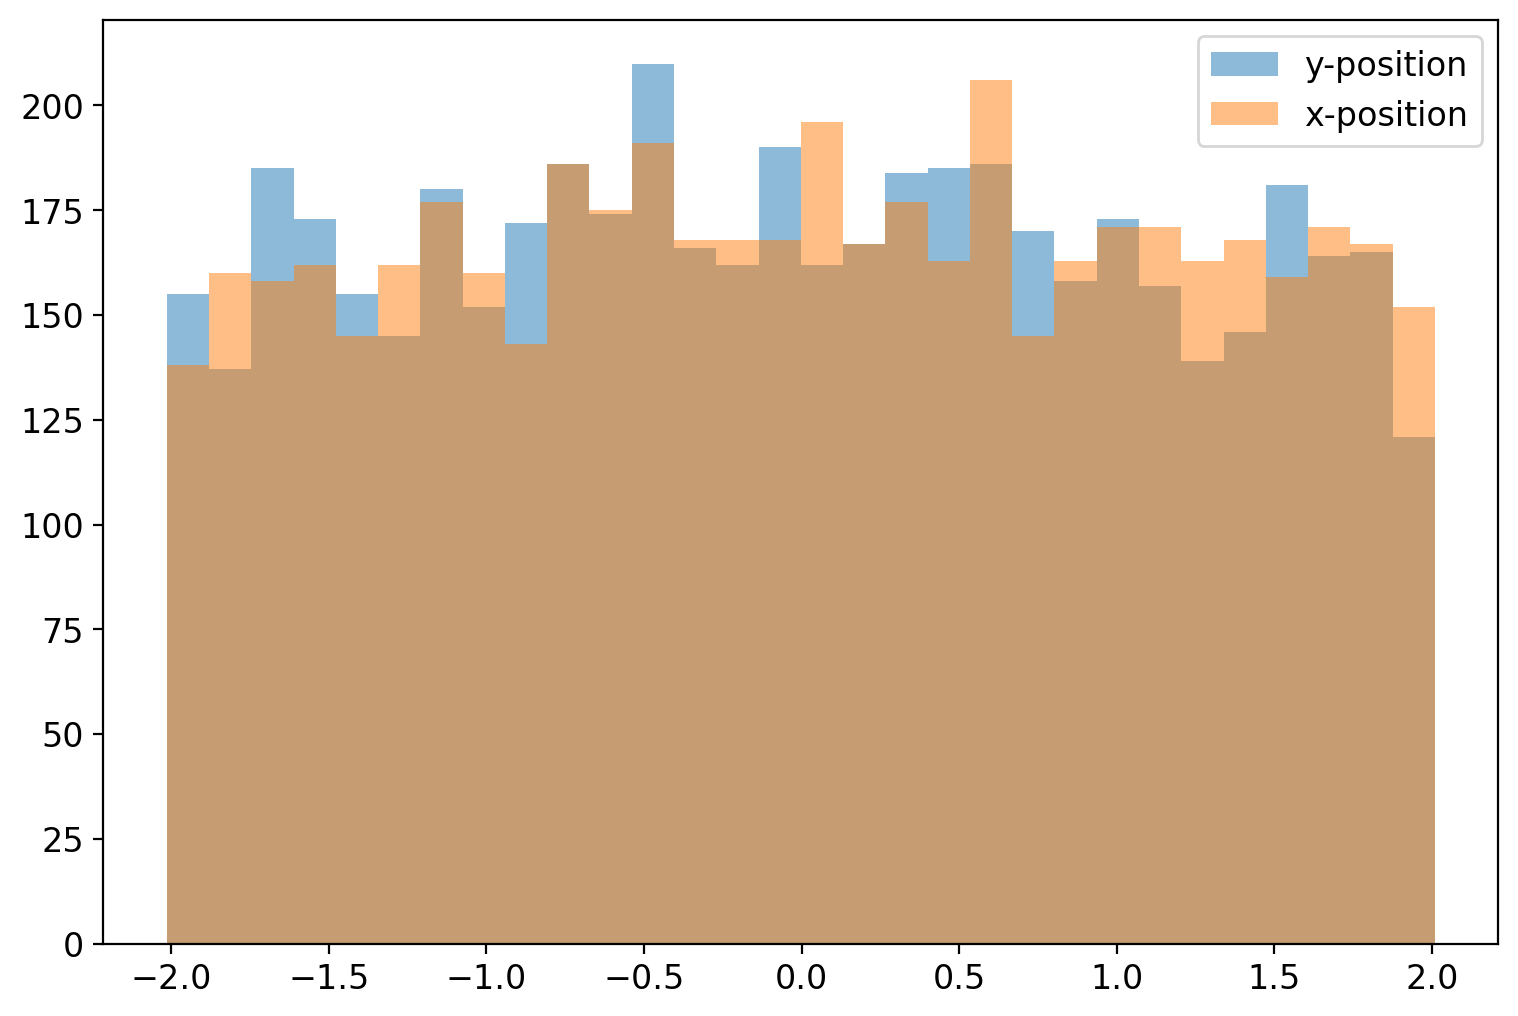

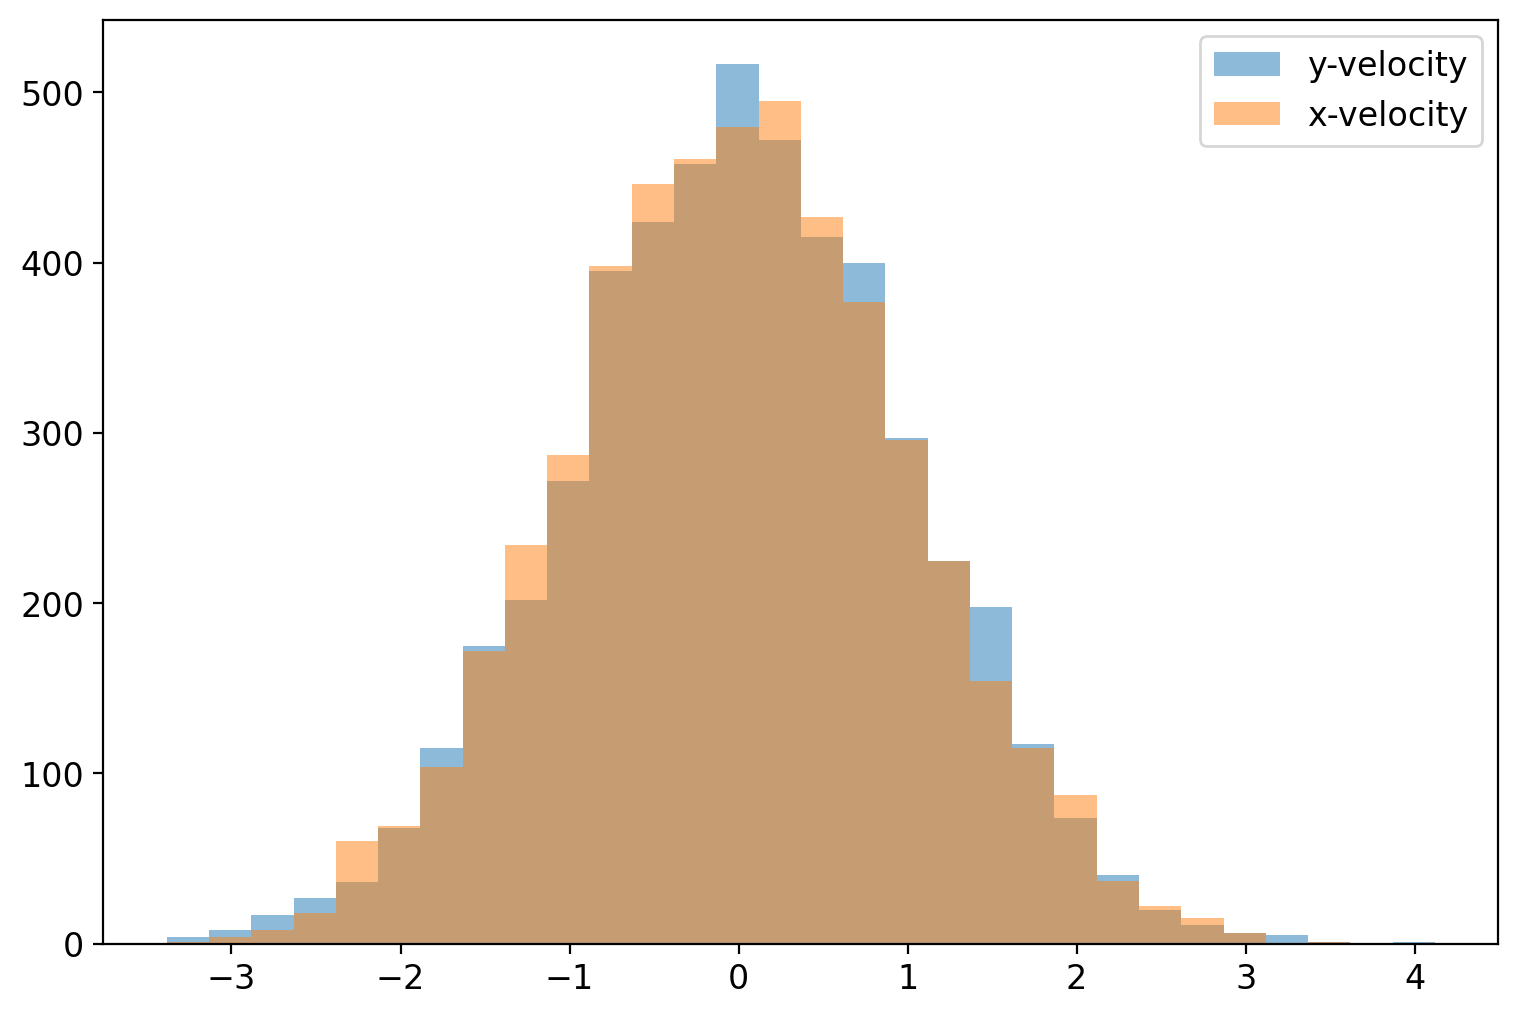

In [27]:
#>>>EXERCISE: L20.3.2

def MCSim_box(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,sigmav,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,sigmav,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)#elastic collisions in the COM equate to equal energy ad a theta rotation
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)

        inbox  = (partpos [:, 0]**2 < 4) & (partpos [:,1]**2 < 4)
        inbox_x  = (partpos [:,0]**2 <4)
        inbox_y  = (partpos [:, 1]**2 < 4)

        partvel[inbox]  = comvel[inbox]+tmp[inbox]
        partvel[~inbox_x] = [-1.,1]*partvel[~inbox_x]
        partvel[~inbox_y] = [1.,-1]*partvel[~inbox_y]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()

MCSim_box()

<a name='section_21_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.4 Modeling Physics Observables: Bragg Scattering for Proton Therapy</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_3) | [Exercises](#exercises_21_4) | [Next Section](#section_21_5) |

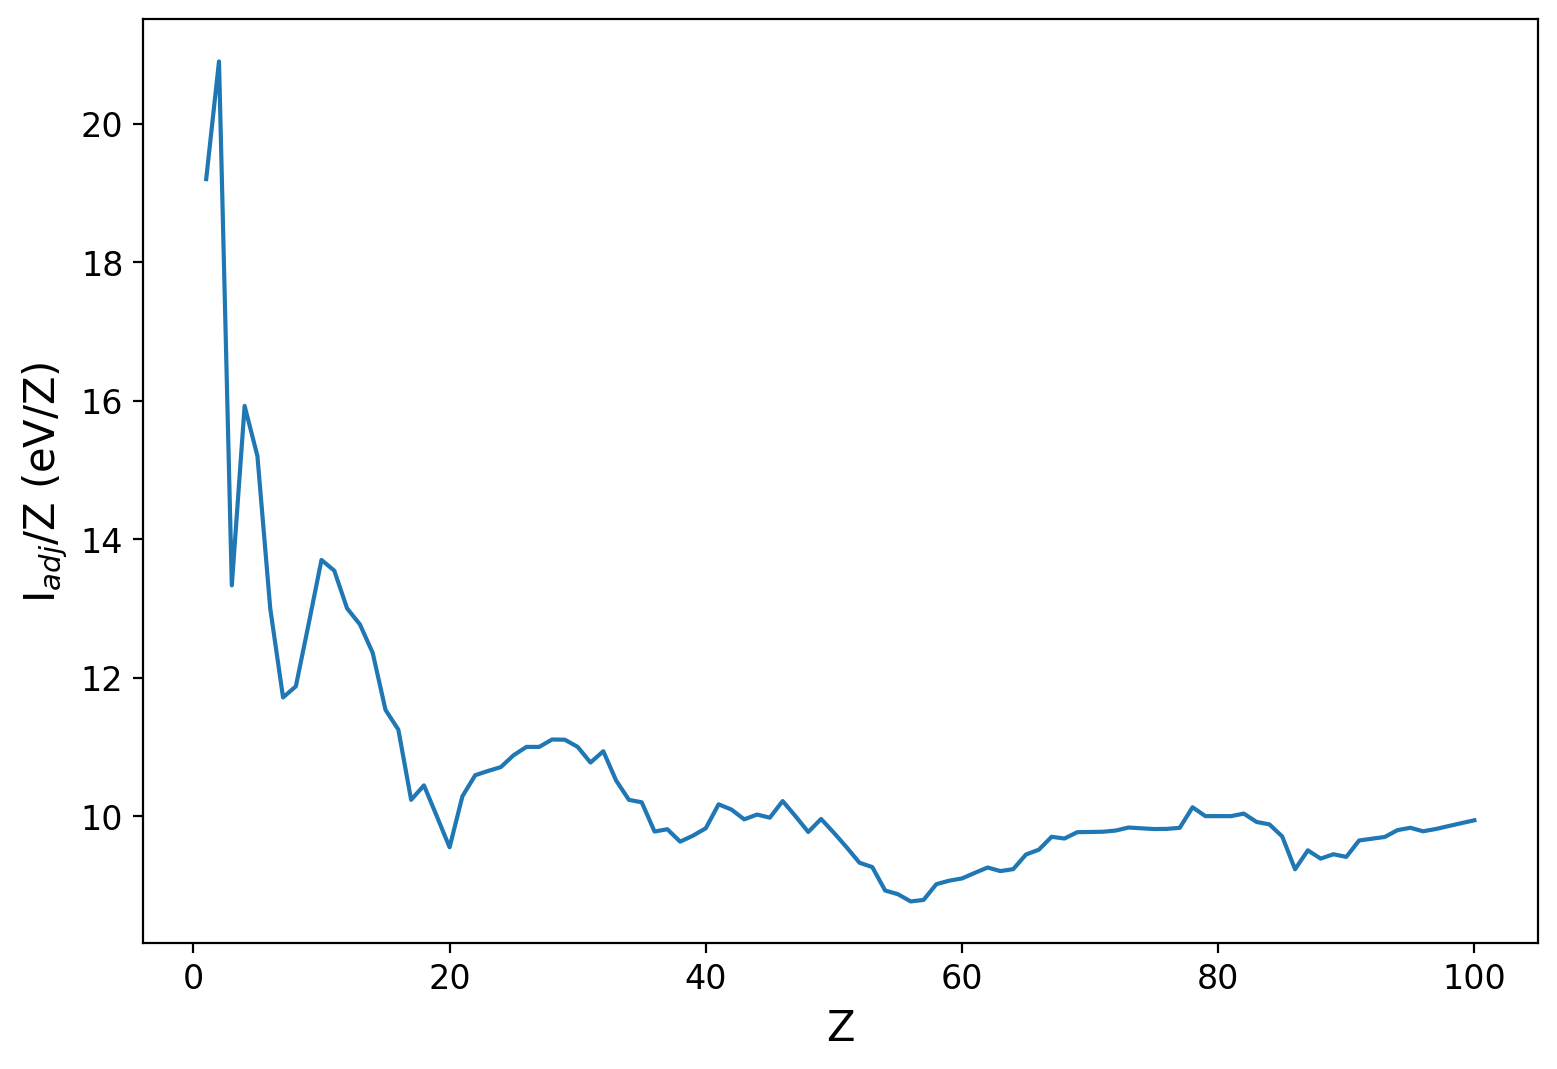

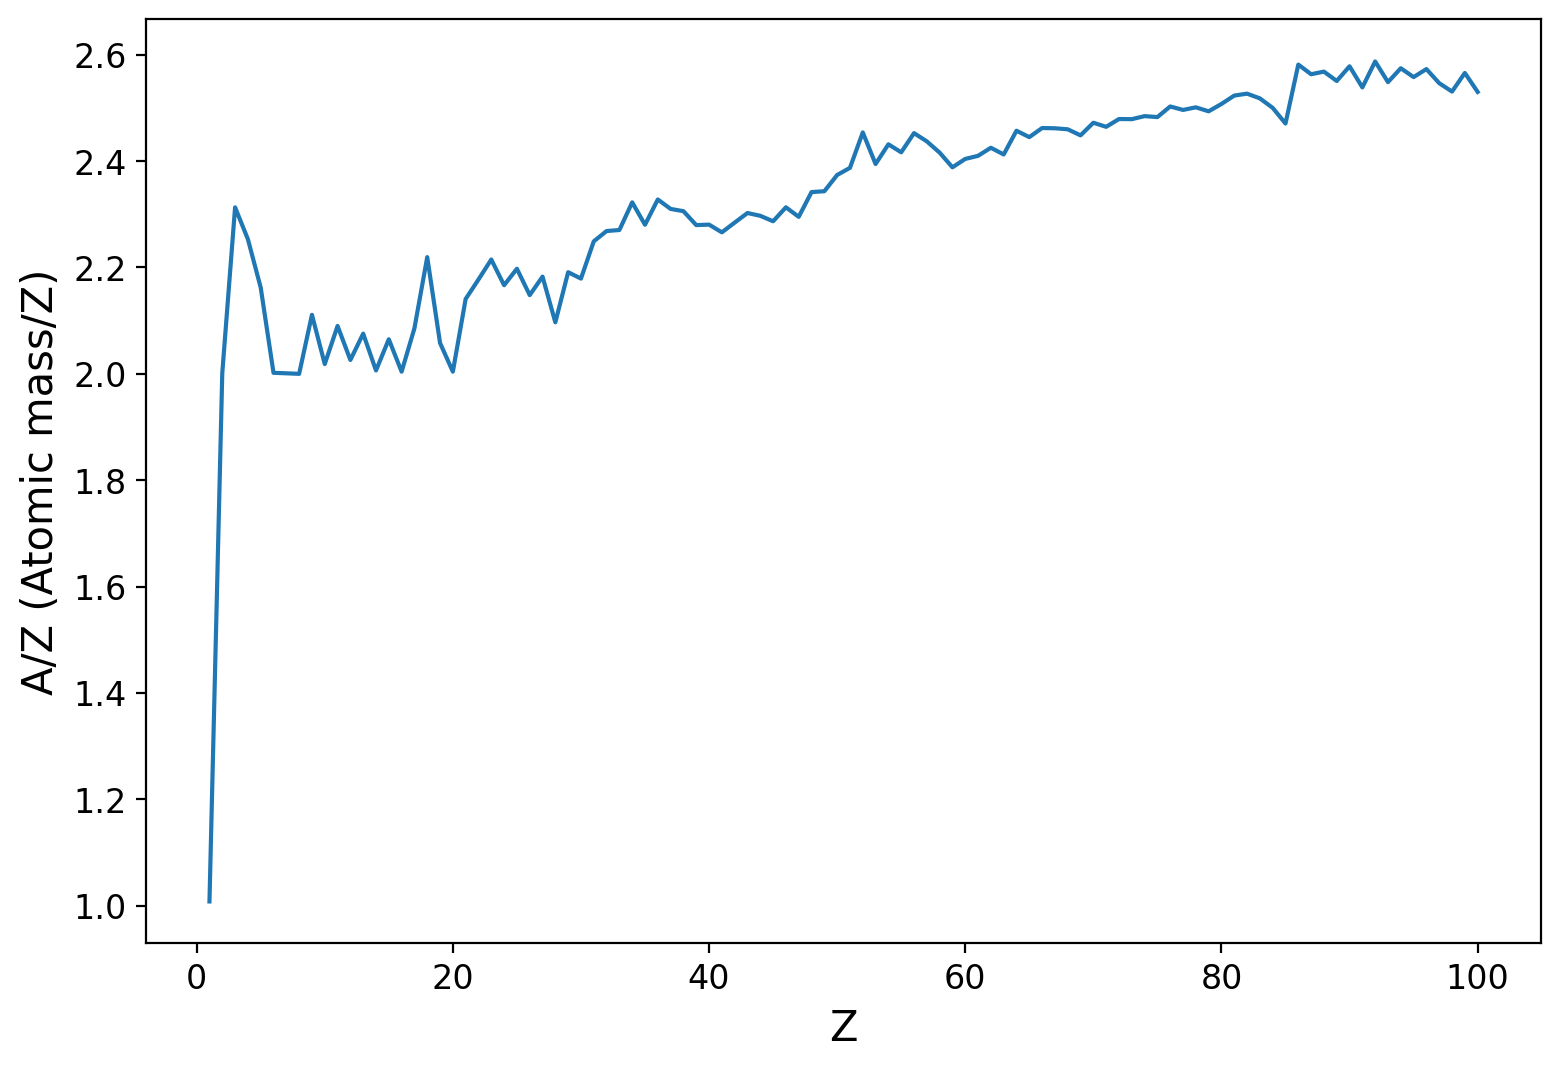

In [28]:
#>>>RUN: L20.4-runcell01

#values
def I(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lI=[19.2,41.8,40.,63.7,76.0,78.0,82.0,95.0,115.,137.,
     149.,156.,166.,173.,173.,180.,174.,188.,190.,191.,216.,233.,245.,
     257.,272.,286.,297.,311.,322.,330.,334.,350.,347.,348.,357.,352.,
     363.,366.,379.,393.,417.,424.,428.,441.,449.,470.,470.,469.,488.,
     488.,487.,485.,491.,482.,488.,491.,501.,523.,535.,546.,560.,574.,
     580.,591.,614.,628.,650.,658.,674.,684.,694.,705.,718.,727.,736.,
     746.,757.,790.,790.,800.,810.,823.,823.,830.,825.,794.,827.,826.,
     841.,847.,878.,890.,902.,921.,934.,939.,952.,966.,980.,994.]
    lZ=np.arange(1,len(lI)+1)
    if iPlot:
        plt.plot(lZ,lI/lZ)
        plt.xlabel('Z')
        plt.ylabel('I$_{adj}$/Z (eV/Z)')
        plt.show()
    return lI[iZ]*1e-6 #MeV not eV

def A(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lA=[1.00797,4.0026,6.939,9.0122,10.811,12.01115,14.0067,
     15.9994,18.9984,20.183,22.9898,24.312,26.9815,28.088,30.9738,
     32.064,35.453,39.948,39.102,40.08,44.956,47.90,50.942,51.998,
     54.9380,55.847,58.9332,58.71,63.54,65.37,69.72,72.59,74.9216,
     78.96,79.808,83.80,85.47,87.62,88.905,91.22,92.906,95.94,99.0,
     101.07,102.905,106.4,107.87,112.4,114.82,118.69,121.75,127.60,
     126.9044,131.30,132.905,137.34,138.91,
     140.12,140.907,144.24,147.,150.35,151.98,157.25,158.924,162.50,
     164.930,167.26,168.934,173.04,174.97,178.49,180.948,183.85,
     186.2,190.2,192.2,195.08,196.987,200.59,204.37,207.19,208.980,
     210.,210.,222.,223.,226.,227.,232.036,231.,238.03,237.,242.,
     243.,247.,247.,248.,254.,253.
    ]
    lZ=np.arange(1,len(lA)+1)
    if iPlot:
        plt.plot(lZ,lA/lZ)
        plt.xlabel('Z')
        plt.ylabel('A/Z (Atomic mass/Z)')
        plt.show()
    return lA[iZ-1]
lItmp=I(1,True)
lItmp=A(1,True)

Gamma and Beta for a proton of momentum 100 MeV: 1.0056667694537882 0.10600907909112761


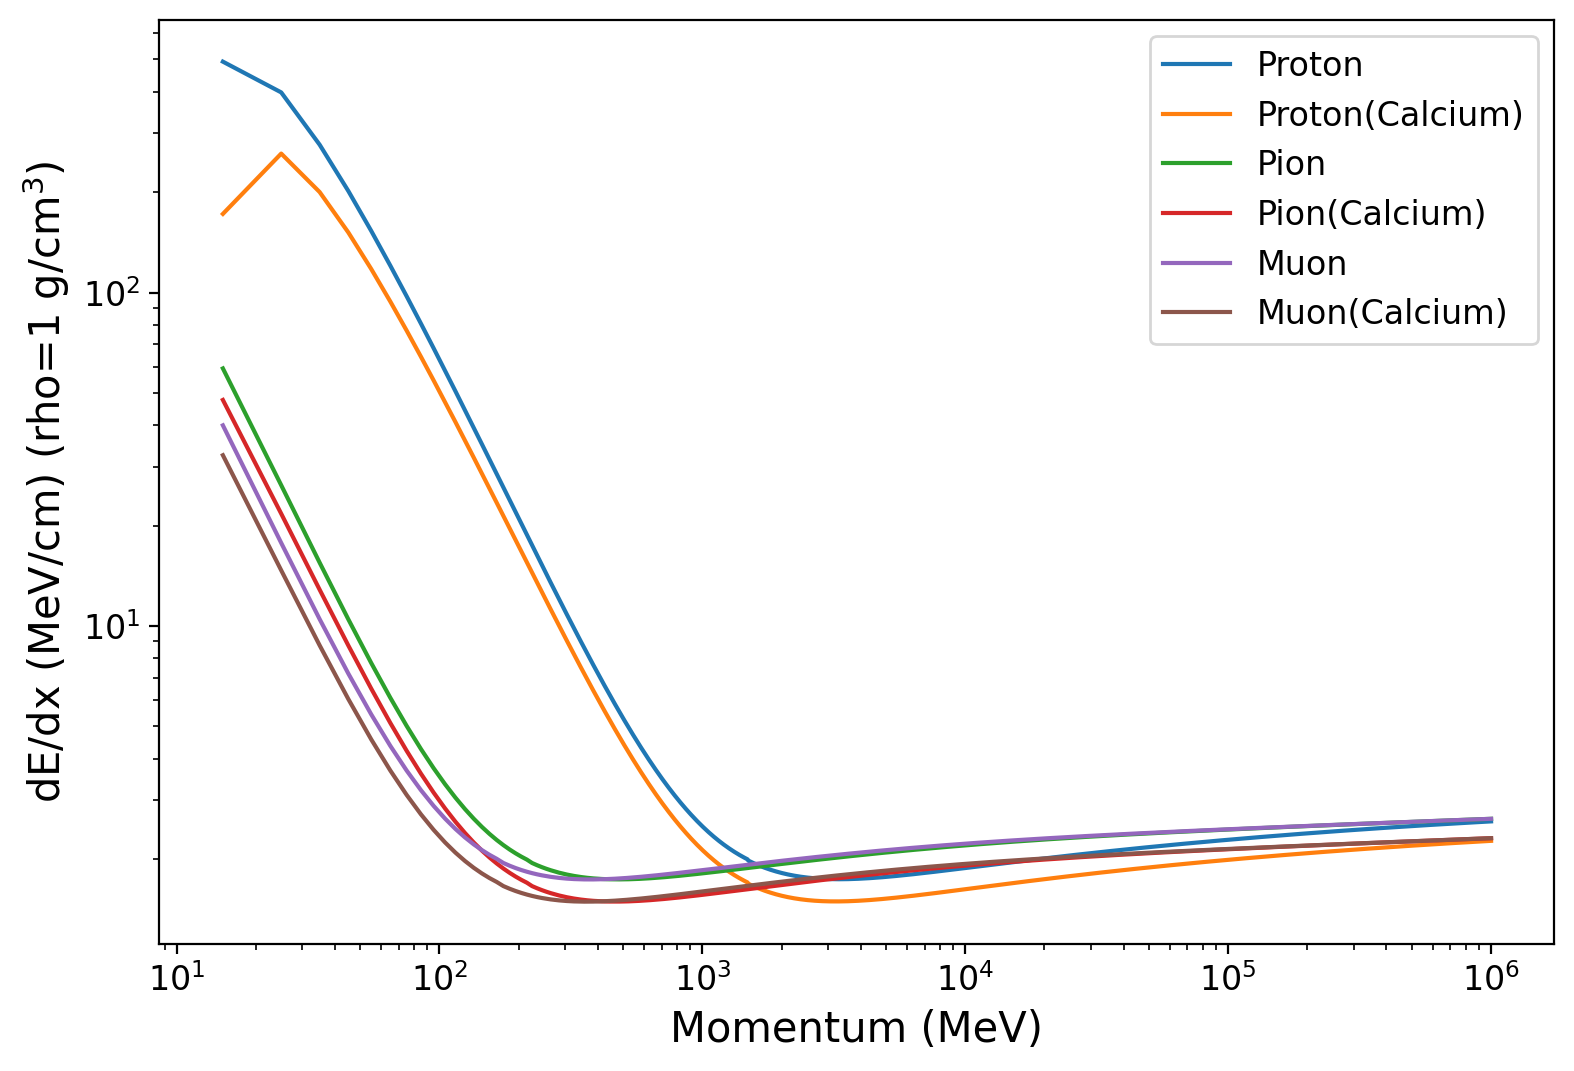

Beta for a proton of momentum 935 MeV (the same as its mass): 0.7059732966763472


In [29]:
#>>>RUN: L20.4-runcell02

#https://indico.cern.ch/event/753612/contributions/3121551/attachments/1974578/3285956/MC_2019.pdf
#https://www.nature.com/articles/s41598-017-10554-0

m_e = 0.511 # Mass of electron in MeV

def gamma(ip,im): #E^2=gamma^2m^2=p^2+m^2
    return np.sqrt(1+(ip/im)**2)

def beta(ip,im): #gamma=1/sqrt(1-b^2)
    g=gamma(ip,im)
    return np.sqrt(1-1./g**2)

def betagamma(ip,im):#p=bgm
    return ip/im

def Tmax(ip,im): # Maximum energy transfer in one collision in MeV
    return 2*m_e*(ip/im)**2/(1+2*gamma(ip,im)*m_e/im+(m_e/im)**2)

def TKinheavy(ip,im): #(T+M)^2=sqrt(p)+sqrt(m)
    return np.sqrt(np.sqrt(ip)+np.sqrt(um))-im

def delta(ip,im):
    C = 4.44
    a = 0.1492
    m = 3.25
    X1 = 2.87
    X0 = 0.2014
    delta0 = 0.14
    x = np.log10(ip/im)
    #f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
    f2 = 2 * x * np.log(10) - C + (a * np.maximum(0, (X1 - x))**m) #using np.maximum to prevent warning when x > X1
    f3 = 2 * x * np.log(10) - C
    delta_full = np.where(x < X0 , 0, f2)
    delta_full = np.where(x < X1, delta_full, f3)
    return delta_full

def dEdxF(ip,im,iZ,zpart=1,rho=1.0,nodelta=False): #Bethe-Bloch equation
    K = 0.307075 # constant K in MeV cm mol^-1
    #rho = 2.336 # Density of material in g cm^-3 (here: silicon density)
    const   = zpart**2 * (K * rho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    logterm = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    dEdxV   =  const * (np.log(logterm)  - 2*(beta(ip,im))**2 - delta(ip,im))
    if nodelta:
        print("delta:",delta(ip,im),dEdxV)
        dEdxV    =  const * (np.log(logterm) - 2*(beta(ip,im))**2)
    return dEdxV

mproton=938
mpion=135.4
mmuon=105.4
print("Gamma and Beta for a proton of momentum 100 MeV:",gamma(100,mproton),beta(100,mproton))
p=np.arange(15,1000000,10)
dEdxOut1p = dEdxF(p,mproton,8,1)
dEdxOut2p = dEdxF(p,mproton,18,1)
dEdxOut1pi = dEdxF(p,mpion,8,1)
dEdxOut2pi = dEdxF(p,mpion,18,1)
dEdxOut1mu = dEdxF(p,mmuon,8,1)
dEdxOut2mu = dEdxF(p,mmuon,18,1)

plt.plot(p,dEdxOut1p,label="Proton")
plt.plot(p,dEdxOut2p,label="Proton(Calcium)")

plt.plot(p,dEdxOut1pi,label="Pion")
plt.plot(p,dEdxOut2pi,label="Pion(Calcium)")

plt.plot(p,dEdxOut1mu,label="Muon")
plt.plot(p,dEdxOut2mu,label="Muon(Calcium)")

plt.xlabel('Momentum (MeV)')
plt.ylabel('dE/dx (MeV/cm) (rho=1 g/cm$^{3}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


print("Beta for a proton of momentum 935 MeV (the same as its mass):",beta(935,mproton))

350 MeV Proton Momentum: 882.6664149042944


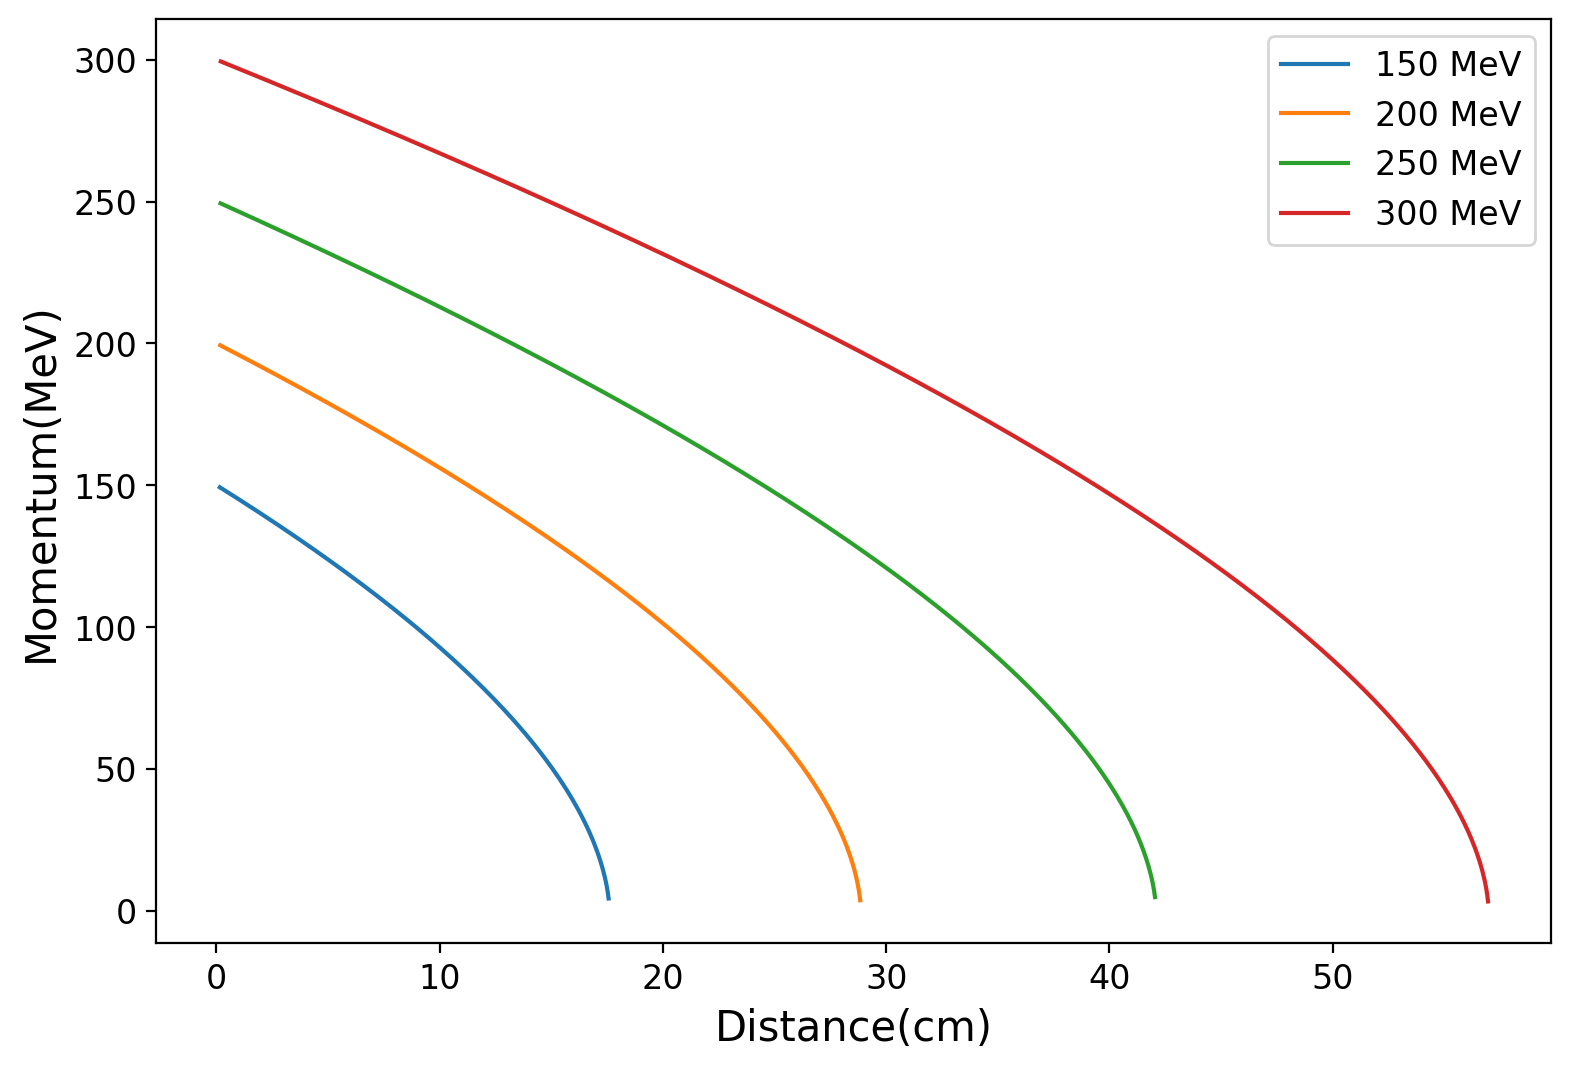

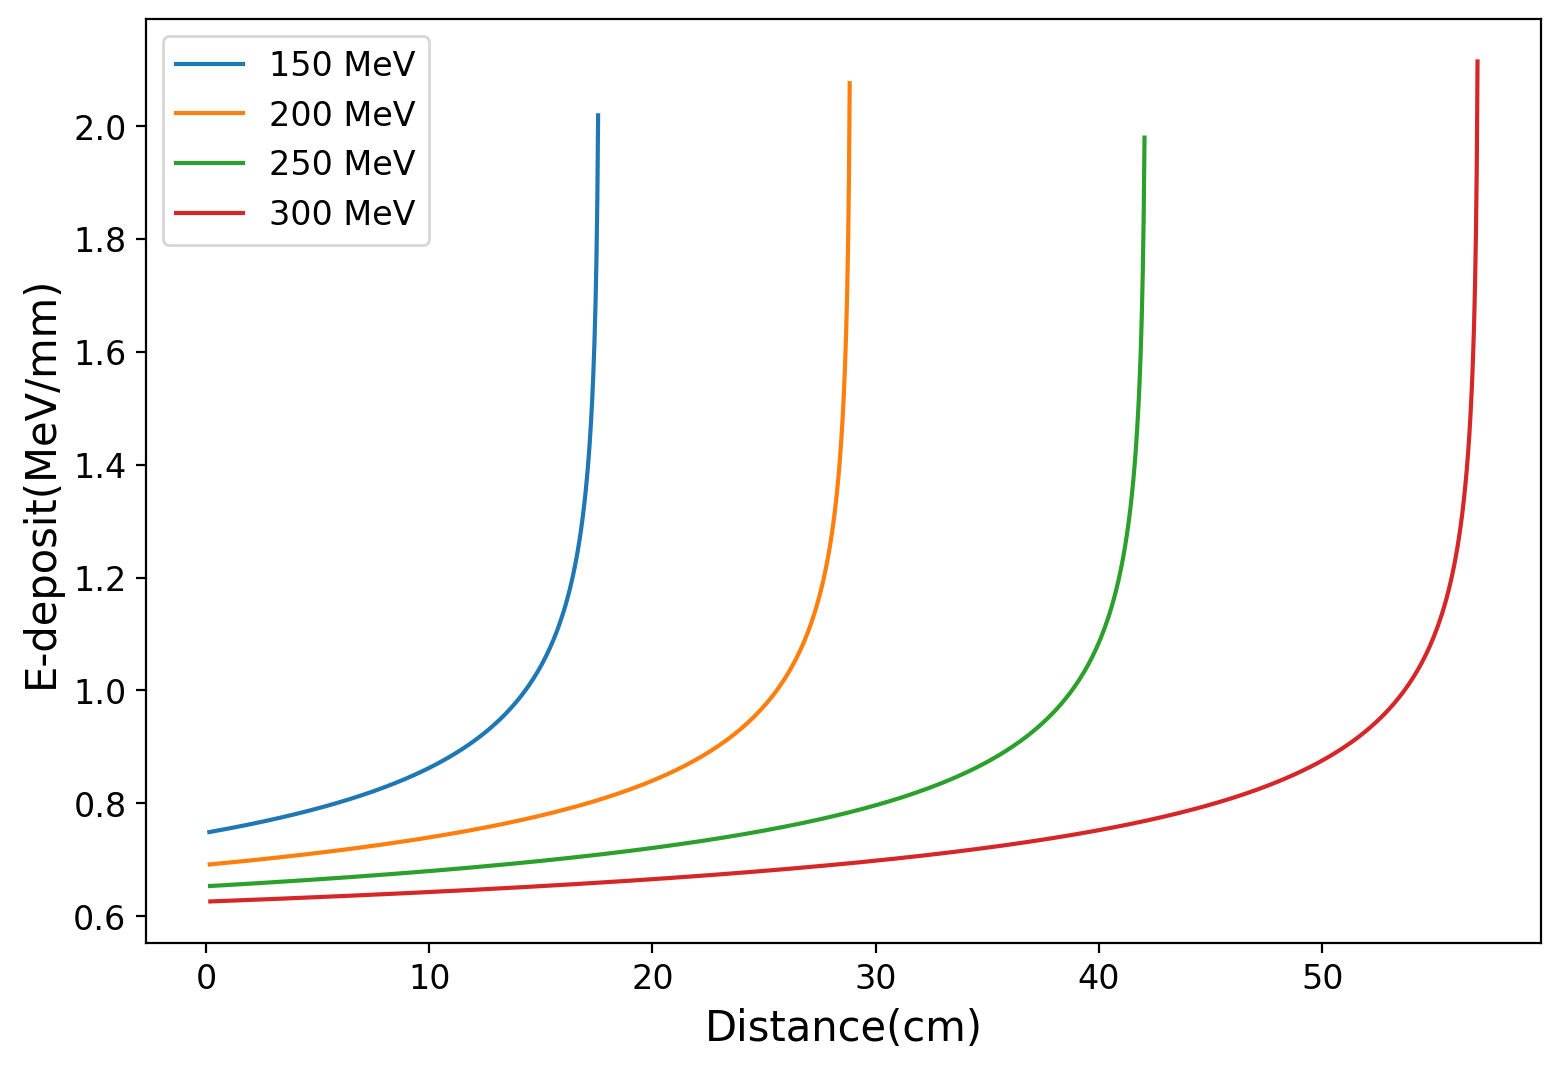

In [30]:
#>>>RUN: L20.4-runcell03

def dP(dE,ip,im): #solving
    #dp = ip - np.sqrt(dE**2+ip**2-2*dE*np.sqrt(ip**2+im**2))
    #E=p^2/2m=> p=\sqrt(2mE)=>dp=sqrt(2m)/sqrt(E) dE
    #return dE*(np.sqrt(ip**2+im**2)/ip)*gamma(ip,im)
    return dE#*(ip/im)

def eToP(iE,im):
    return np.sqrt((iE+im)**2-im**2)

def sim(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    while e > 5:
        p = eToP(e,im)
        dEdxS  = dEdxF(p,im,iZ=iZ,rho=1.06)
        #print(dEdxS)
        dx     = beta(p,im)*c*idt#speed of light
        #print(dEdxS,dP(dEdxS*dx,p,im))
        e      -= dEdxS*dx
        dist   += dx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dEdxS*dx)
        pstep  = np.append(pstep,e)
    return xstep,pstep,estep

print("350 MeV Proton Momentum:",eToP(350,mproton))
xstep150,pstep150,estep150 = sim(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = sim(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = sim(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = sim(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()

#sim(60,dt=1e-12)

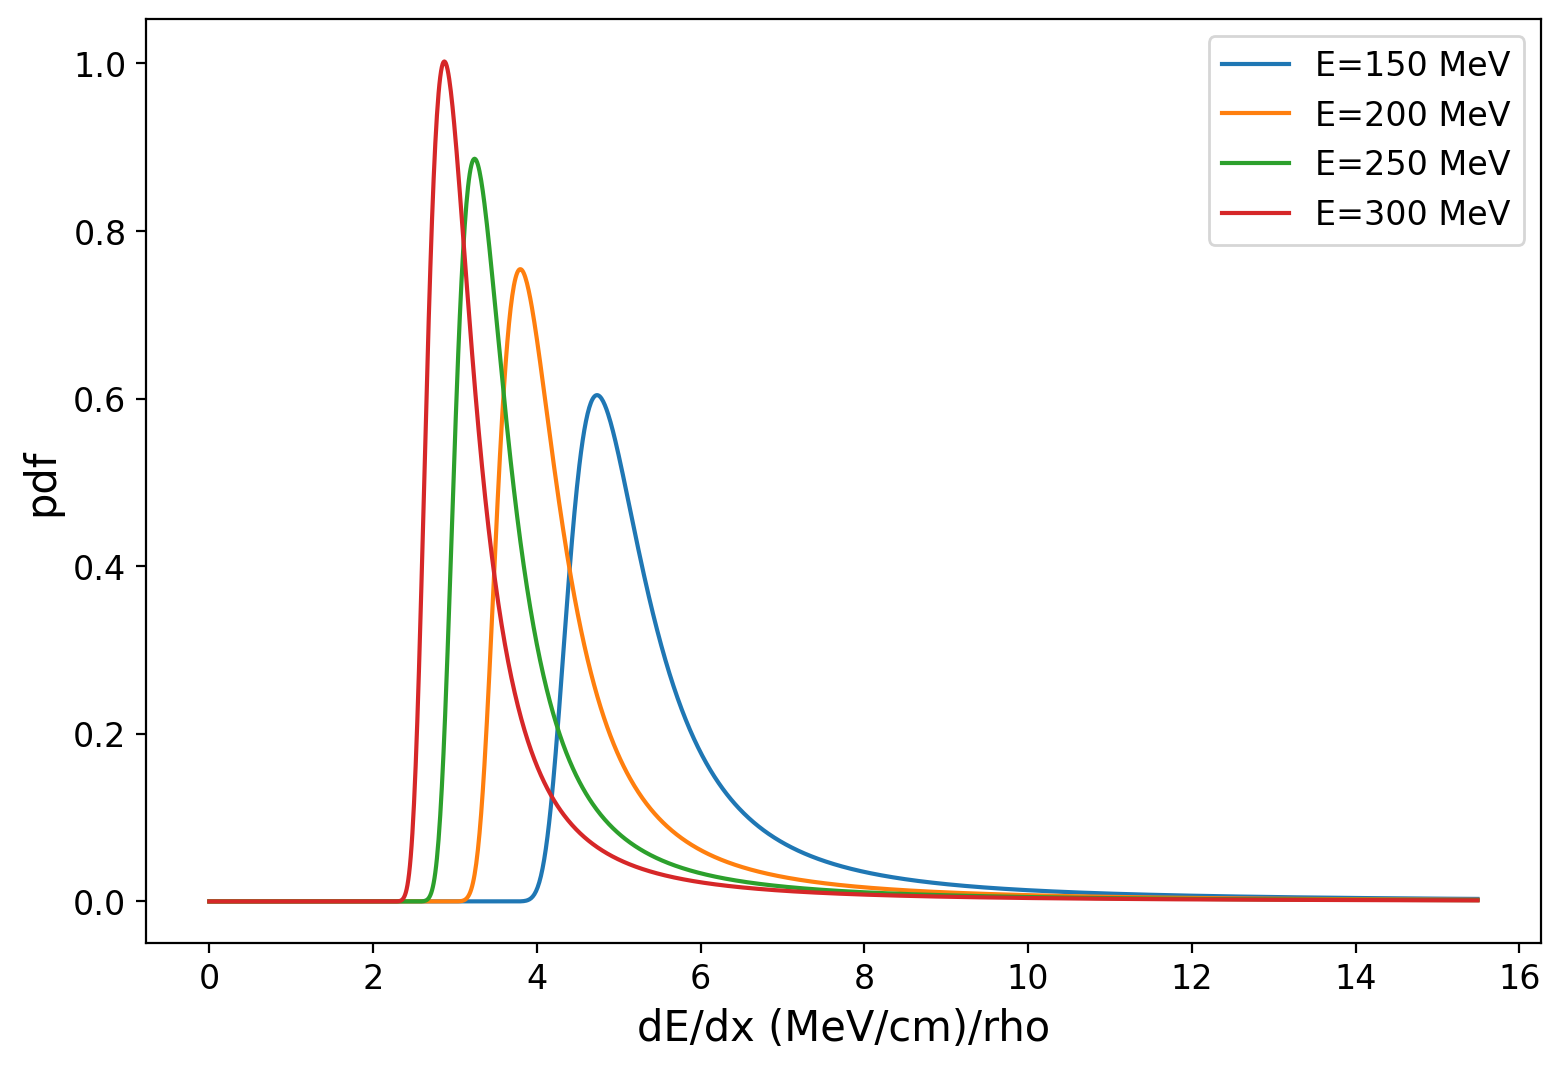

In [31]:
#>>>RUN: L20.4-runcell04

import pylandau
from landaupy import landau

def landauMPV(ip,im,iZ,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    logterm1 = 2 * m_e *               ((ip/im)**2)/(I(iZ))
    logterm2 = const/I(iZ)
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2     - (beta(ip,im))**2 - delta(ip,im))       #
    return dEdxV,const

def plotLandau(ip,im,idx,iZ=14,irho=1,zpart=1):
    lP=eToP(ip,im)
    lMPV,lWMPV = landauMPV(lP,im,iZ,irho,zpart)
    lMPV*=idx; lWMPV*=idx
    x=np.arange(0,15.5,0.01)
    landpy=landau.pdf(x,lMPV,lWMPV)
    return x,landpy

x,landZ150=plotLandau(150,mproton,1.0,iZ=8,irho=1.0)
x,landZ200=plotLandau(200,mproton,1.0,iZ=8,irho=1.0)
x,landZ250=plotLandau(250,mproton,1.0,iZ=8,irho=1.0)
x,landZ300=plotLandau(300,mproton,1.0,iZ=8,irho=1.0)

plt.plot(x,landZ150,label='E=150 MeV')
plt.plot(x,landZ200,label='E=200 MeV')
plt.plot(x,landZ250,label='E=250 MeV')
plt.plot(x,landZ300,label='E=300 MeV')
plt.xlabel("dE/dx (MeV/cm)/rho")
plt.ylabel("pdf")
plt.legend()
plt.show()


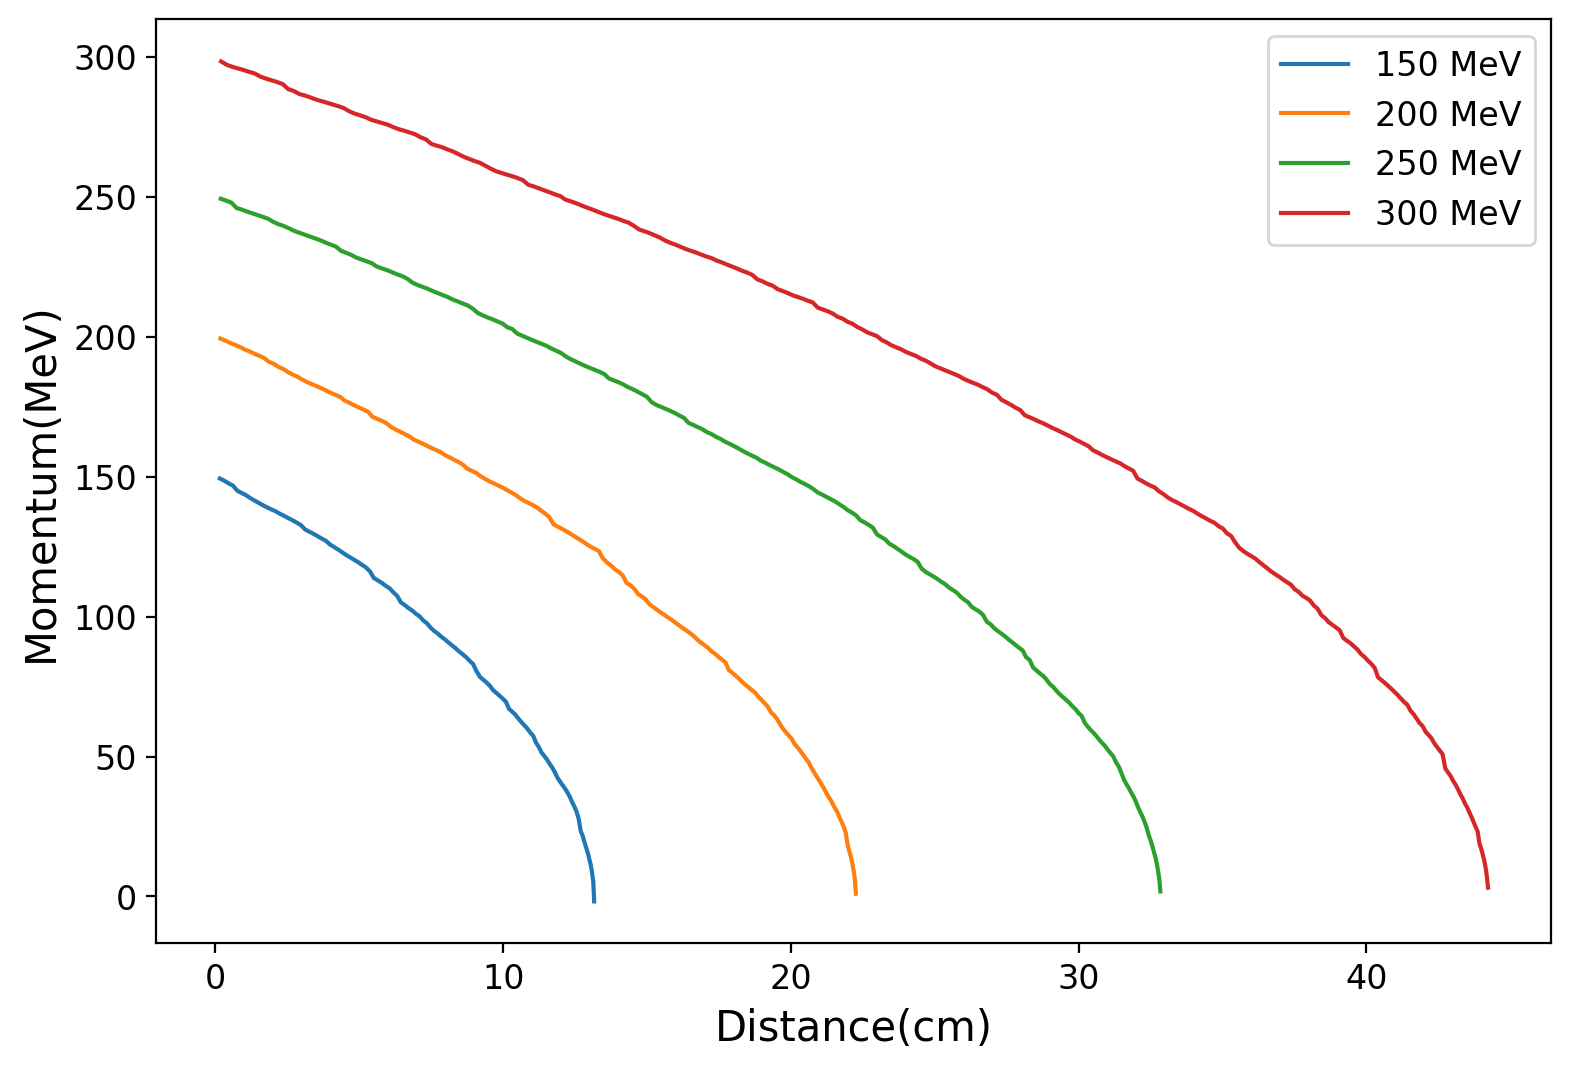

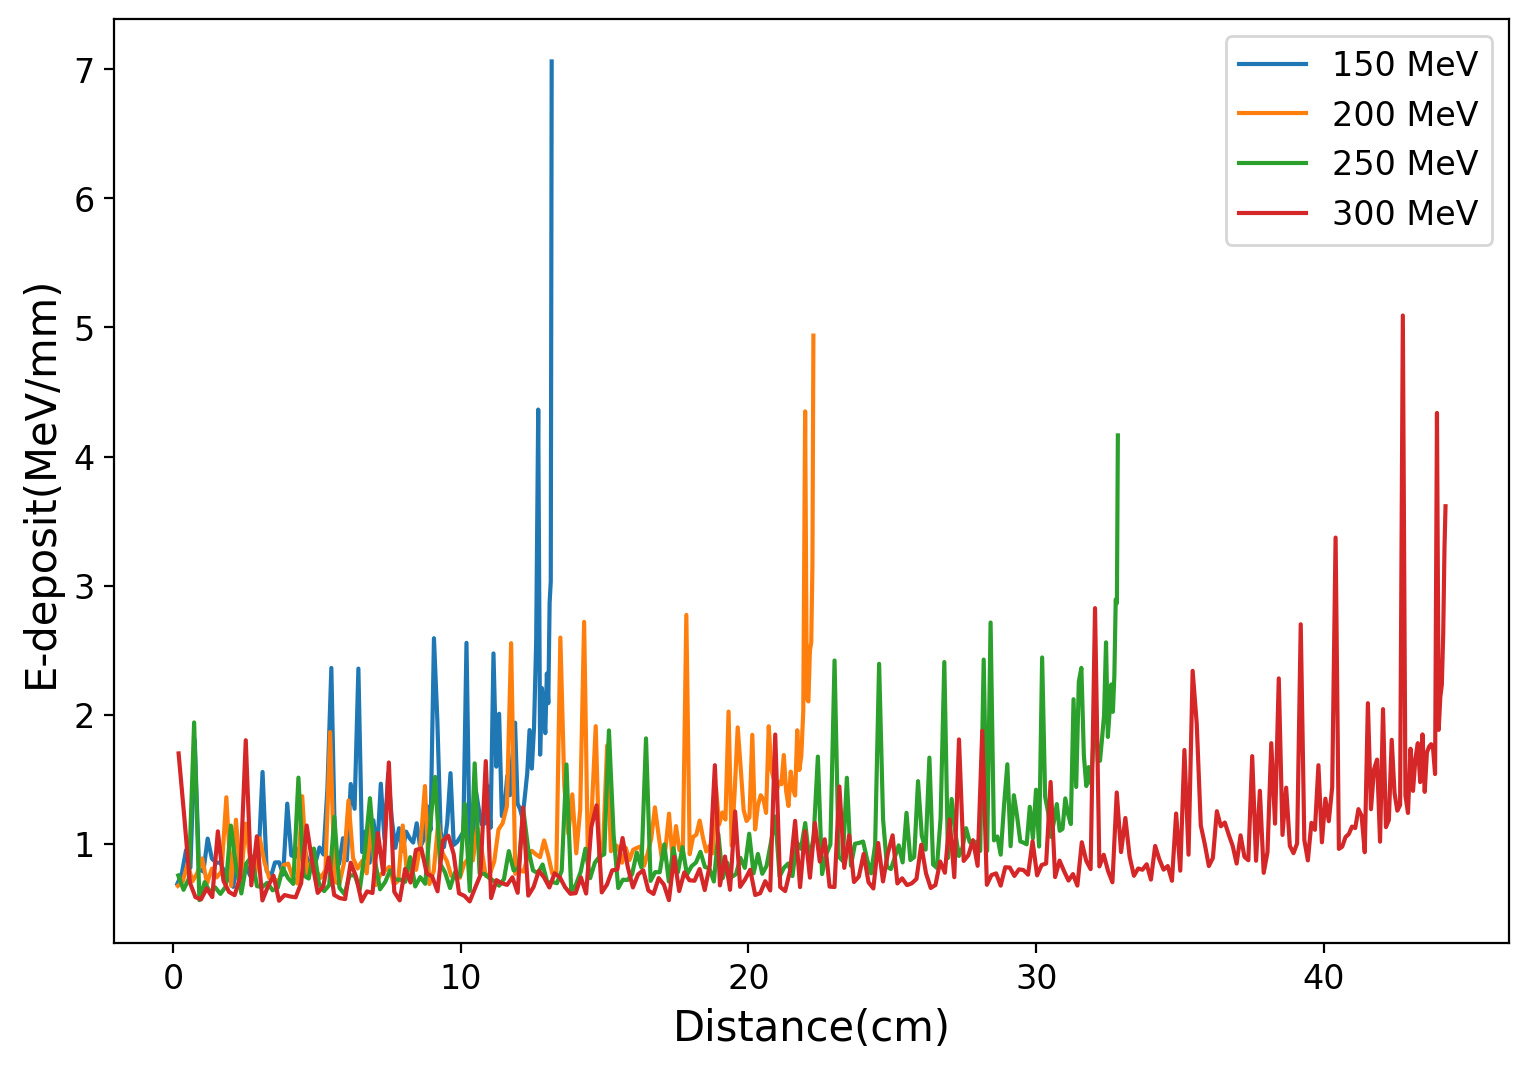

In [32]:
#>>>RUN: L20.4-runcell05

def simSample(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    while e > 5:
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE     = landau.sample(lMPV, lWMPV, 1)
        dx     = beta(p,im)*c*idt#speed of light
        e      -= dE*dx
        dist   += dx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dE*dx)
        pstep  = np.append(pstep,e)
    return xstep,pstep,estep

xstep150,pstep150,estep150 = simSample(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = simSample(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = simSample(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = simSample(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()



0
25
50
75


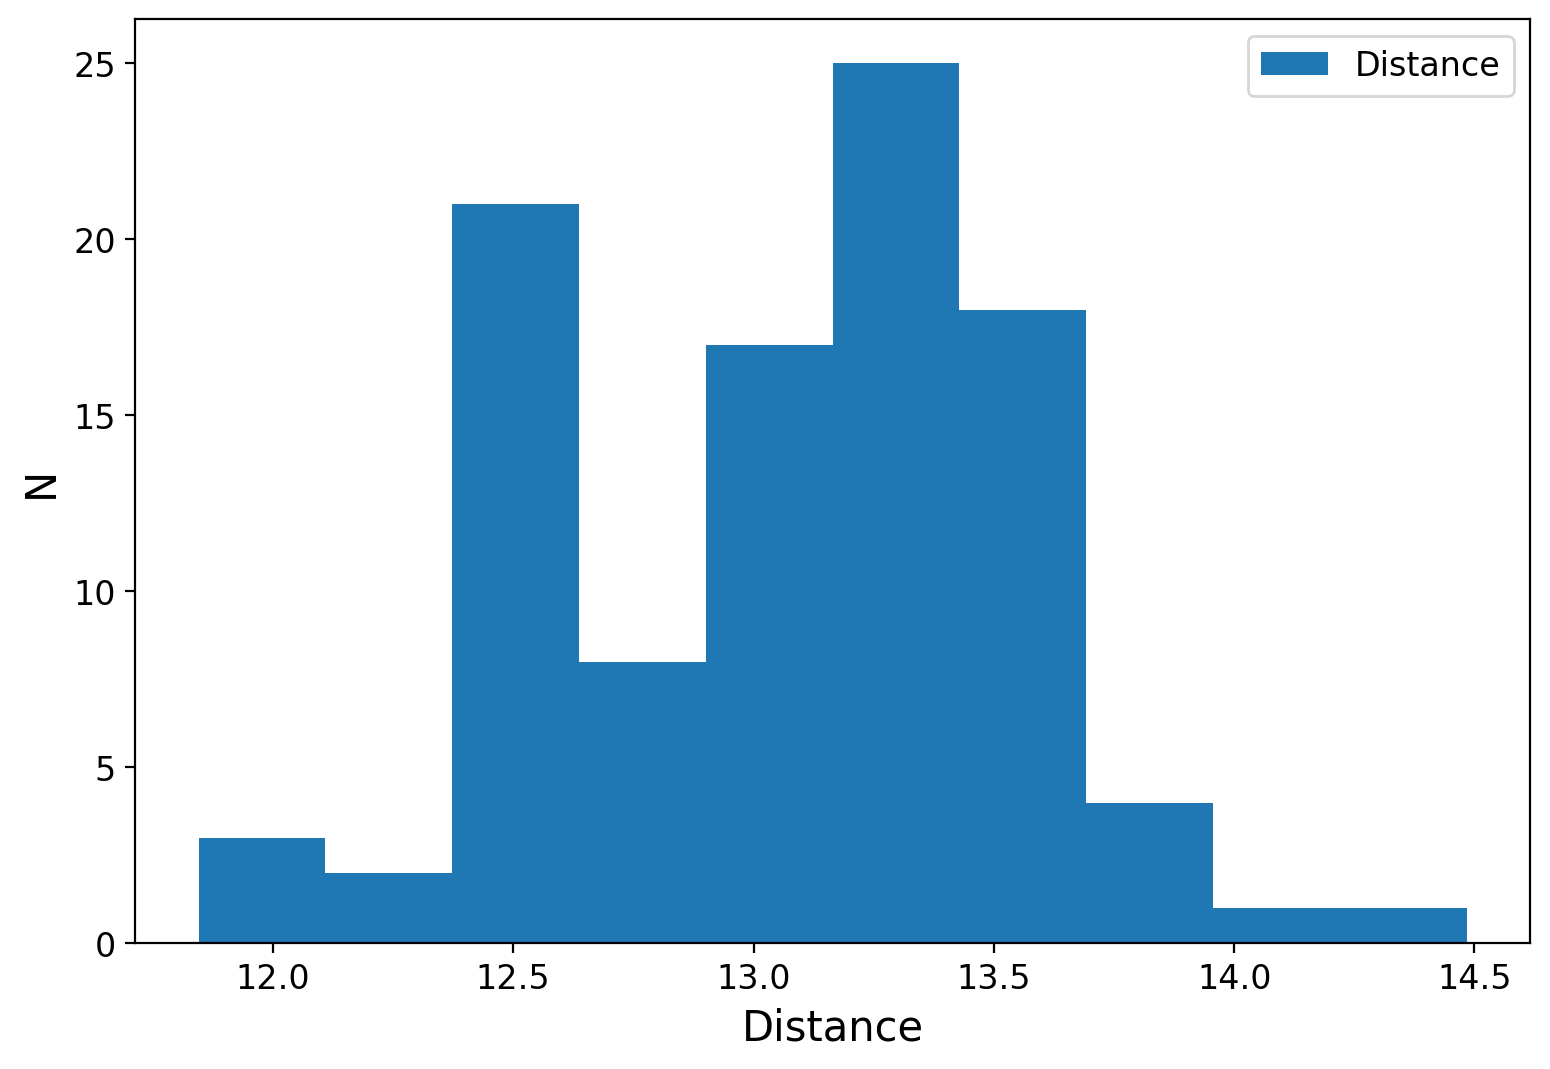

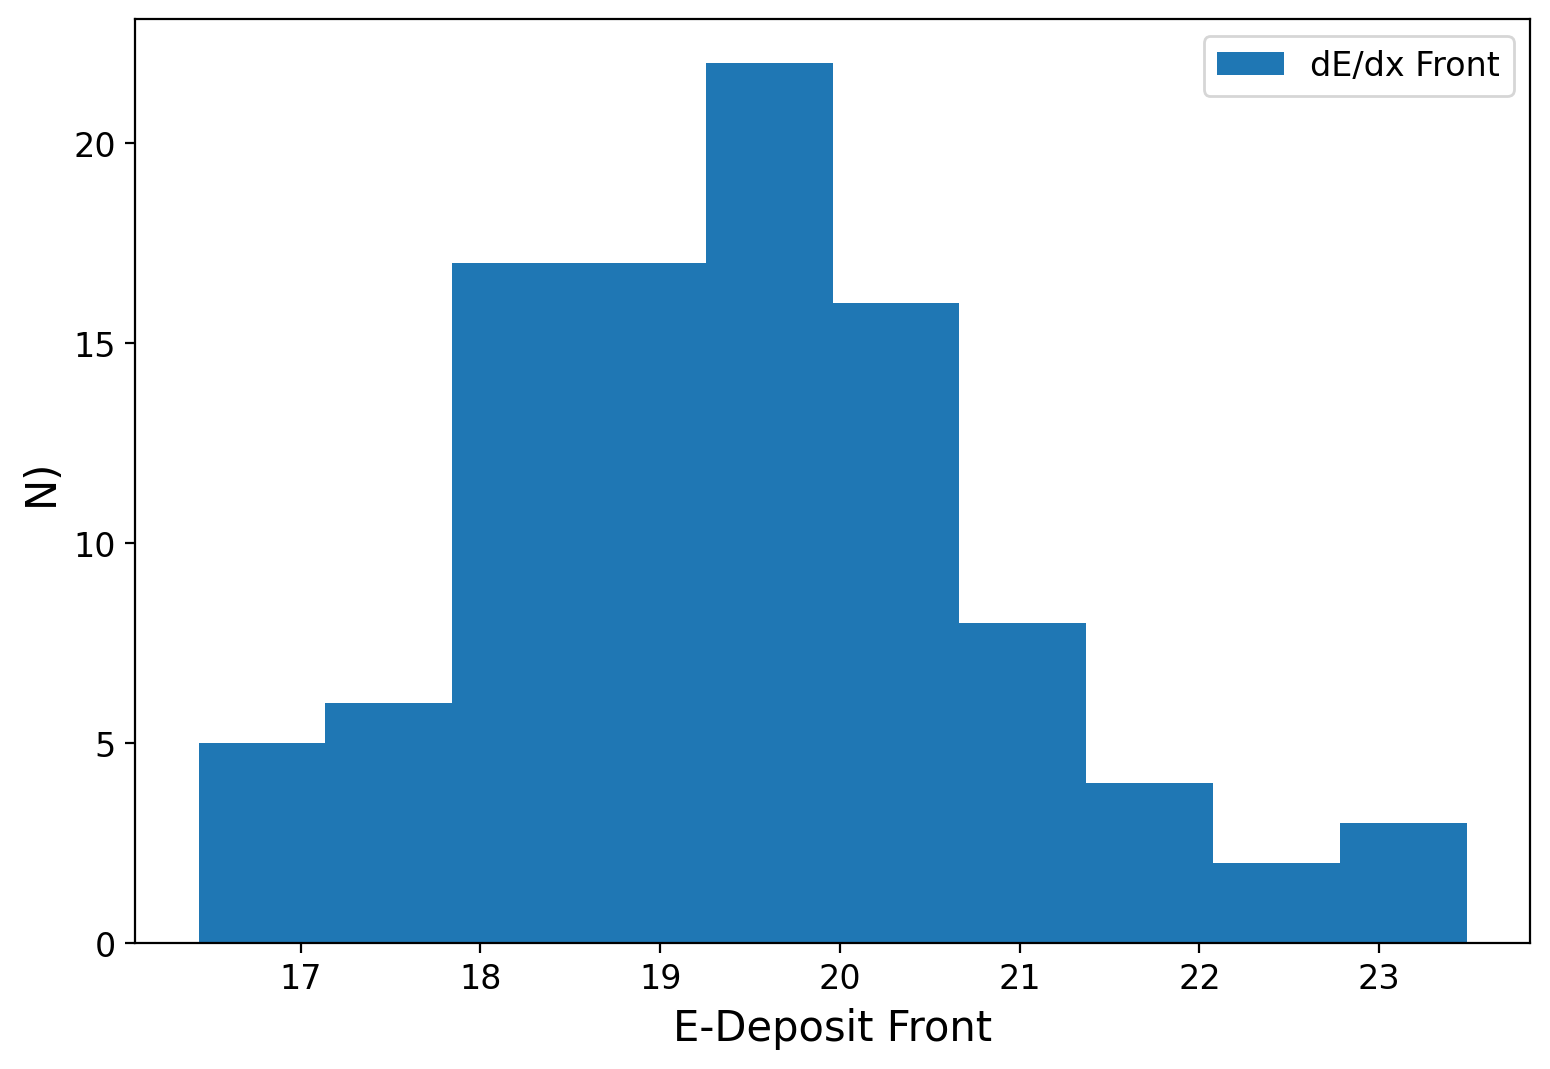

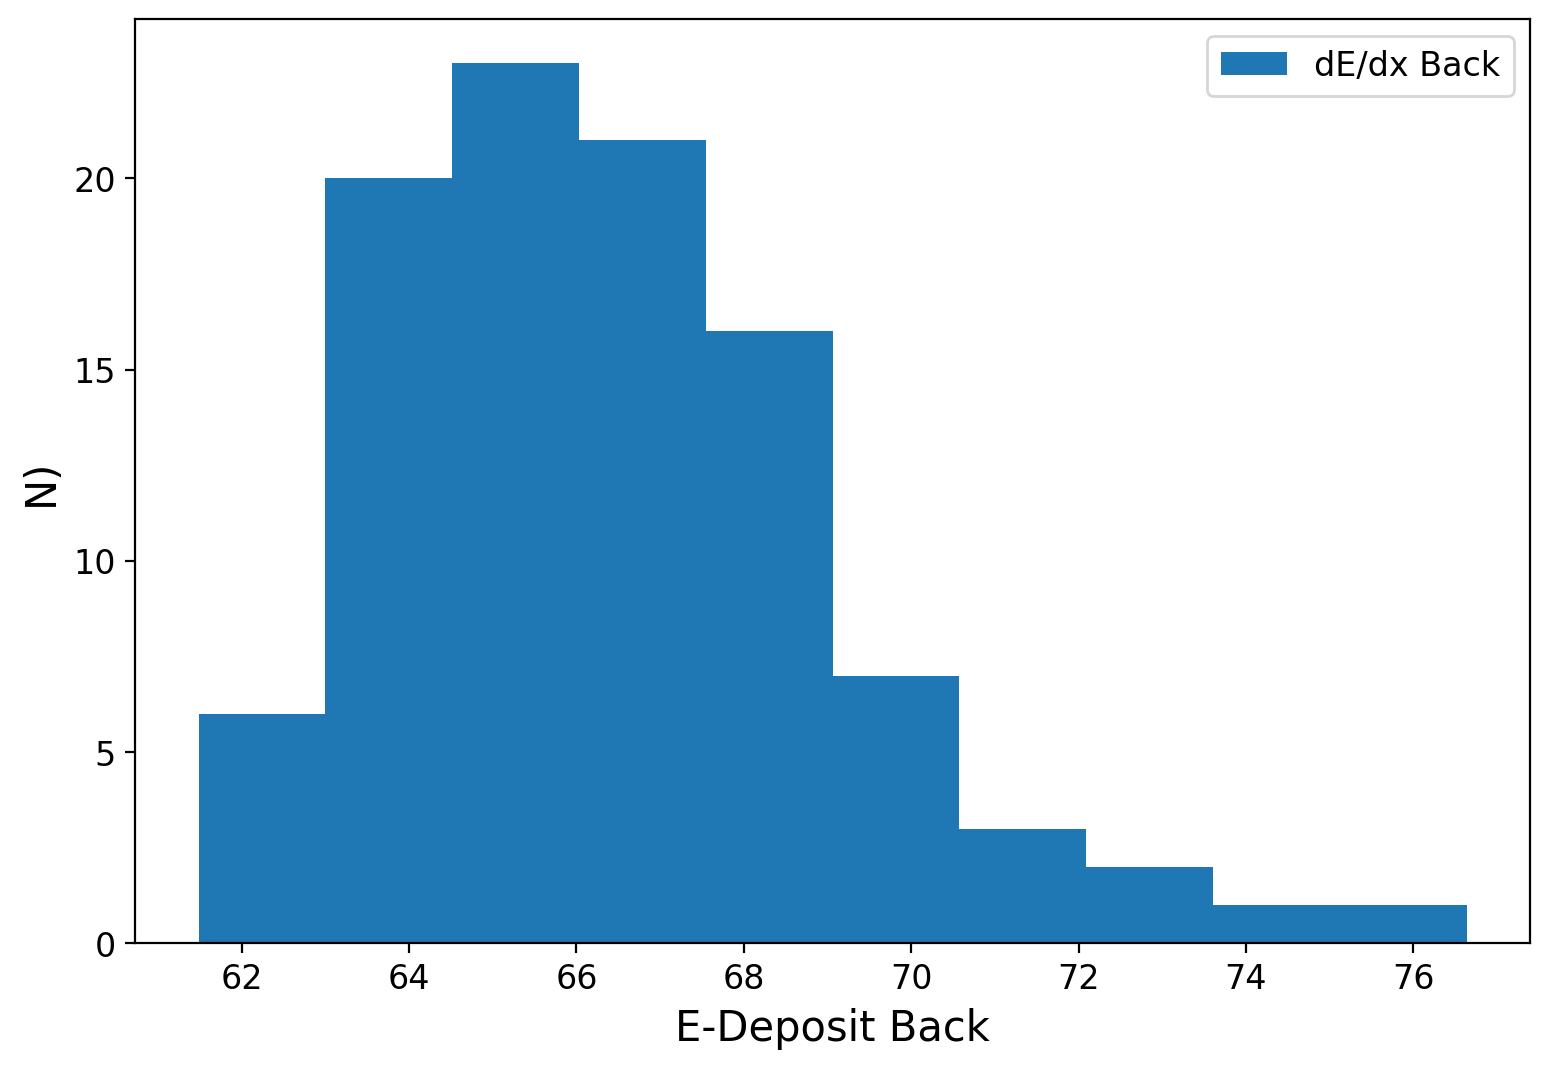

In [33]:
#>>>RUN: L20.4-runcell06

def observables(iXArr,iPArr,iEArr):
    lX=iXArr[-1]
    dEEnd=np.sum(iEArr[(iXArr > iXArr[-1]-3)])
    dEFrt=np.sum(iEArr[(iXArr < 3)])
    return lX,dEEnd,dEFrt

def simNSamples(ie=150,im=mproton,iN=100,idt=1e-11,iZ=8):
    pXArr = np.array([])
    pdEBArr = np.array([])
    pdEFArr = np.array([])
    for i0 in range(iN):
        if i0 % 25 == 0:
            print(i0)
        pXstep,pPstep,pEstep = simSample(ie=ie,im=im,idt=idt,iZ=iZ)
        pX,pdEEnd,pdEFrt = observables(pXstep,pPstep,pEstep)
        pXArr   = np.append(pXArr,  pX)
        pdEBArr = np.append(pdEBArr,pdEEnd)
        pdEFArr = np.append(pdEFArr,pdEFrt)


    plt.hist(pXArr,label='Distance')
    plt.xlabel('Distance')
    plt.ylabel('N')
    plt.legend()
    plt.show()

    plt.hist(pdEFArr,label='dE/dx Front')
    plt.xlabel('E-Deposit Front')
    plt.ylabel('N)')
    plt.legend()
    plt.show()

    plt.hist(pdEBArr,label='dE/dx Back')
    plt.xlabel('E-Deposit Back')
    plt.ylabel('N)')
    plt.legend()
    plt.show()


#plt.plot(xstep150,estep150,label='150 MeV')
#plt.plot(xstep200,estep200,label='200 MeV')
#plt.plot(xstep250,estep250,label='250 MeV')
#plt.plot(xstep300,estep300,label='300 MeV')
#plt.xlabel('Distance(cm)')
#plt.ylabel('E-deposit(MeV/mm)')
#plt.legend()
#plt.show()

simNSamples()


Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


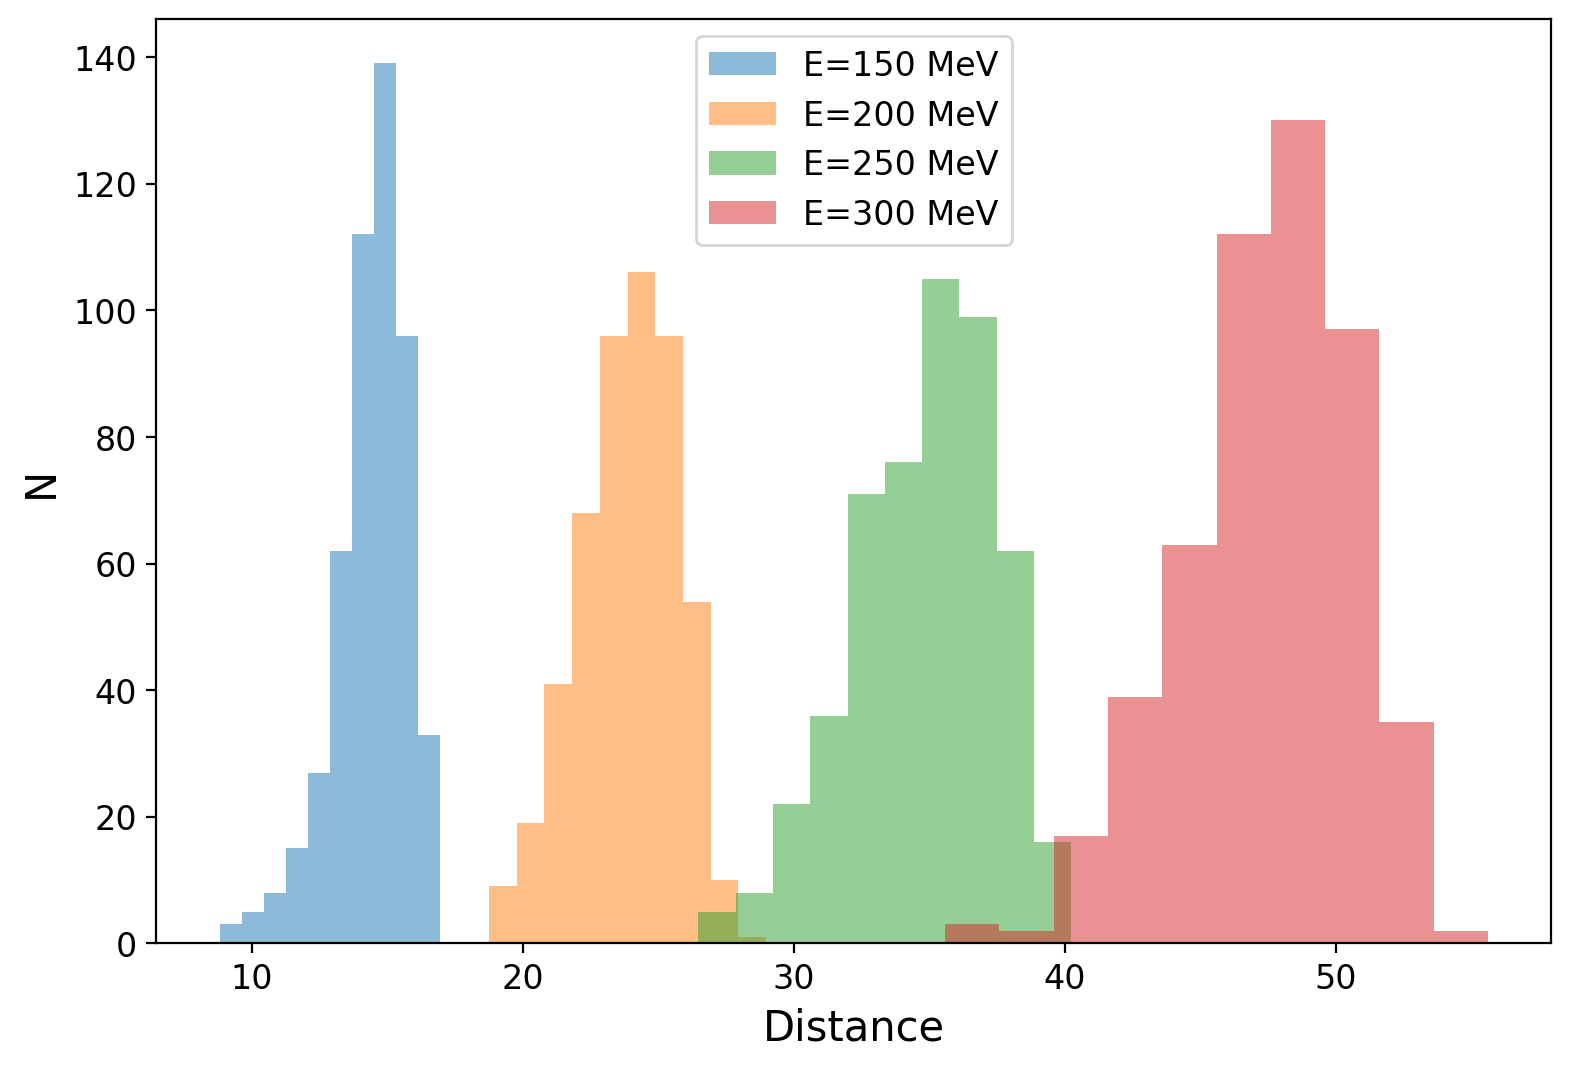

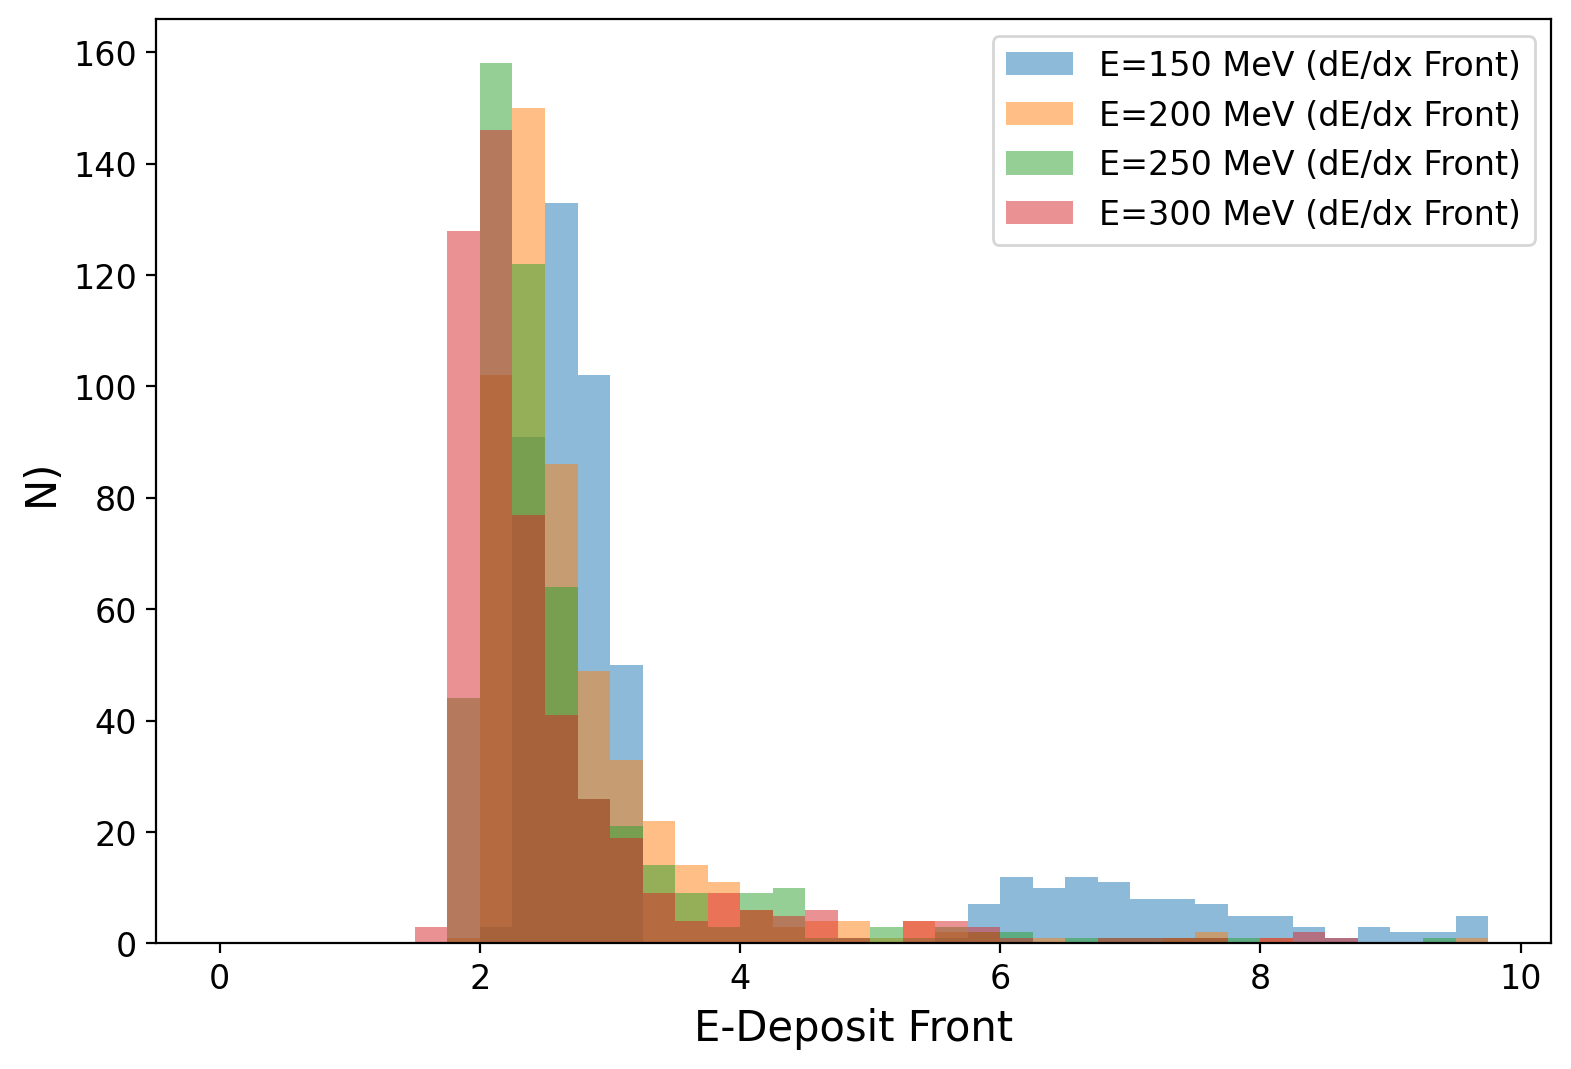

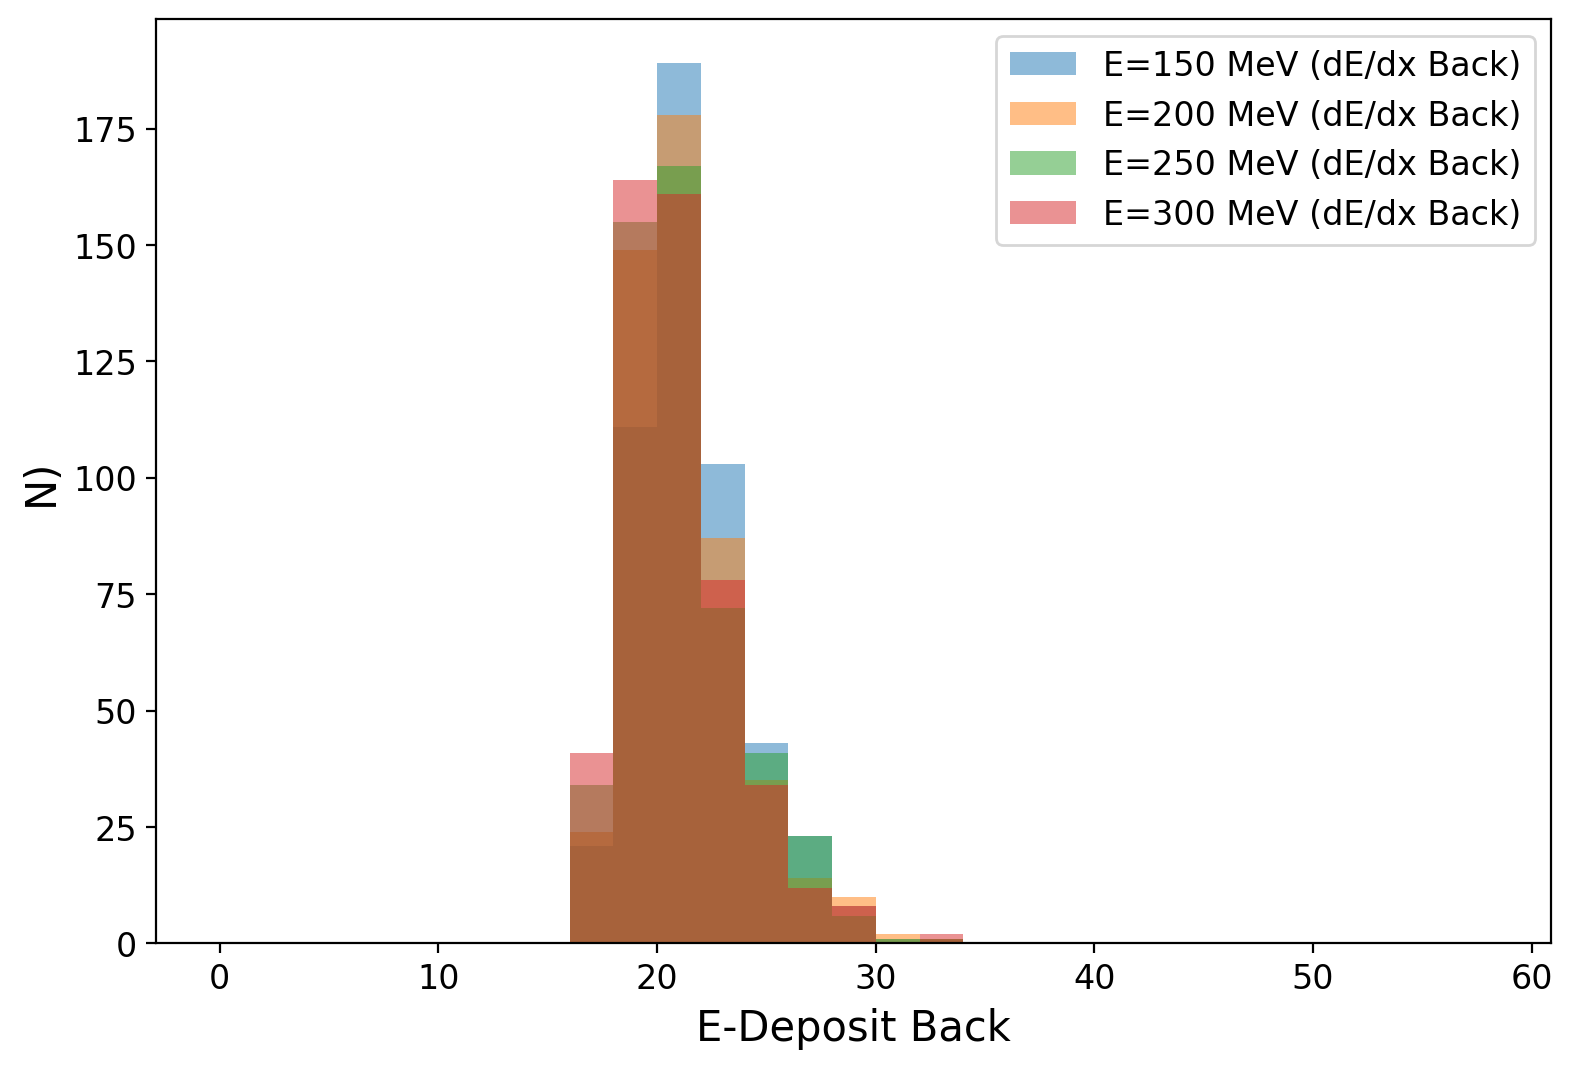

In [34]:
#>>>RUN: L20.4-runcell07

def simNParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx
        xstep  = np.vstack((xstep,dist))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    return xstep,pstep,estep

def simNSamples(ie=100,im=mproton,iN=500,idt=5e-11,iZ=8):
    xstep,pstep,estep=simNParallelSample(iN,ie=ie,im=im,idt=idt,iZ=iZ)
    plt.hist(xstep[:,-1],alpha=0.5)
    plt.show()
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0]-3])/3.
    xrange=np.arange(0,150,2.5)
    _,bins,_=plt.hist(efront,bins=xrange,alpha=0.5,label='dE/dx Front')
    plt.hist(eback, bins=bins,alpha=0.5,label='dE/dx Back')
    plt.legend()
    plt.show()

def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

xstep150,pstep150,estep150=simNParallelSample(ie=150,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep200,pstep200,estep200=simNParallelSample(ie=200,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep250,pstep250,estep250=simNParallelSample(ie=250,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep300,pstep300,estep300=simNParallelSample(ie=300,im=mproton,iN=500,idt=1e-10,iZ=8)

plt.hist(xstep150[:,-1],alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],alpha=0.5,label='E=300 MeV')
plt.xlabel('Distance')
plt.ylabel('N')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,10,0.25)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.xlabel('E-Deposit Front')
plt.ylabel('N)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.xlabel('E-Deposit Back')
plt.ylabel('N)')
plt.legend()
plt.show()


<a name='exercises_21_4'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_4) | [Next Section](#section_21_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.4.1</span>

In the preceding section, we used `sumEstep` to determine the total amount of energy deposited in the first and last 3 cm of a particle's path, and created a histogram. Now, write a function `sumEstepInWindow` that performs a similar action within a window of width `w`, centered at a position `d`.

What is the total energy deposited in a window of width 3 cm, centered at a distance of 5 cm, for an initial energy of 250 MeV? Report your answer as a number in MeV with precision 0.1 MeV.

<br>

In [35]:
#>>>EXERCISE: L20.4.1

def sumEstepInWindow(estep, xstep, d, w):
    ewindow = np.zeros(xstep.shape[0])
    lower_bound = d -w/ 2
    upper_bound = d + w /2
    for i0 in range (xstep. shape [0]) :
      ewindow[i0] = np.sum(estep[i0, (xstep[i0] >= lower_bound) & (xstep [i0] <= upper_bound) ])
    return ewindow

# Define the window width w and center distance d
w = 3  # cm, change this value as needed
d = 5  # cm, change this value as needed

# Calculate total energy deposited in the window of width w cm centered at distance d cm for each initial energy
total_deposited_150 = np.round(np.mean(sumEstepInWindow(estep150, xstep150, d, w)),1)
total_deposited_200 = np.round(np.mean(sumEstepInWindow(estep200, xstep200, d, w)),1)
total_deposited_250 = np.round(np.mean(sumEstepInWindow(estep250, xstep250, d, w)),1)
total_deposited_300 = np.round(np.mean(sumEstepInWindow(estep300, xstep300, d, w)),1)

print(f'Total energy deposited in a {w} cm window centered at {d} cm for 150 MeV: {total_deposited_150} MeV')
print(f'Total energy deposited in a {w} cm window centered at {d} cm for 200 MeV: {total_deposited_200} MeV')
print(f'Total energy deposited in a {w} cm window centered at {d} cm for 250 MeV: {total_deposited_250} MeV')
print(f'Total energy deposited in a {w} cm window centered at {d} cm for 300 MeV: {total_deposited_300} MeV')

Total energy deposited in a 3 cm window centered at 5 cm for 150 MeV: 20.5 MeV
Total energy deposited in a 3 cm window centered at 5 cm for 200 MeV: 8.8 MeV
Total energy deposited in a 3 cm window centered at 5 cm for 250 MeV: 16.2 MeV
Total energy deposited in a 3 cm window centered at 5 cm for 300 MeV: 14.9 MeV


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.4.2</span>

Now, we will use the code from the preceding exercise to obtain the total energy deposited within a 3 cm window as a function of distance. A plot of energy deposited versus distance will yield the Bragg peak for a given initial energy! Create this plot for all 4 initial energies that we have been considering. For your answer to this exercise, find the location of the Bragg peak for the 250 MeV protons. Enter your answer as a number in centimeters with precision 1 cm.

<br>

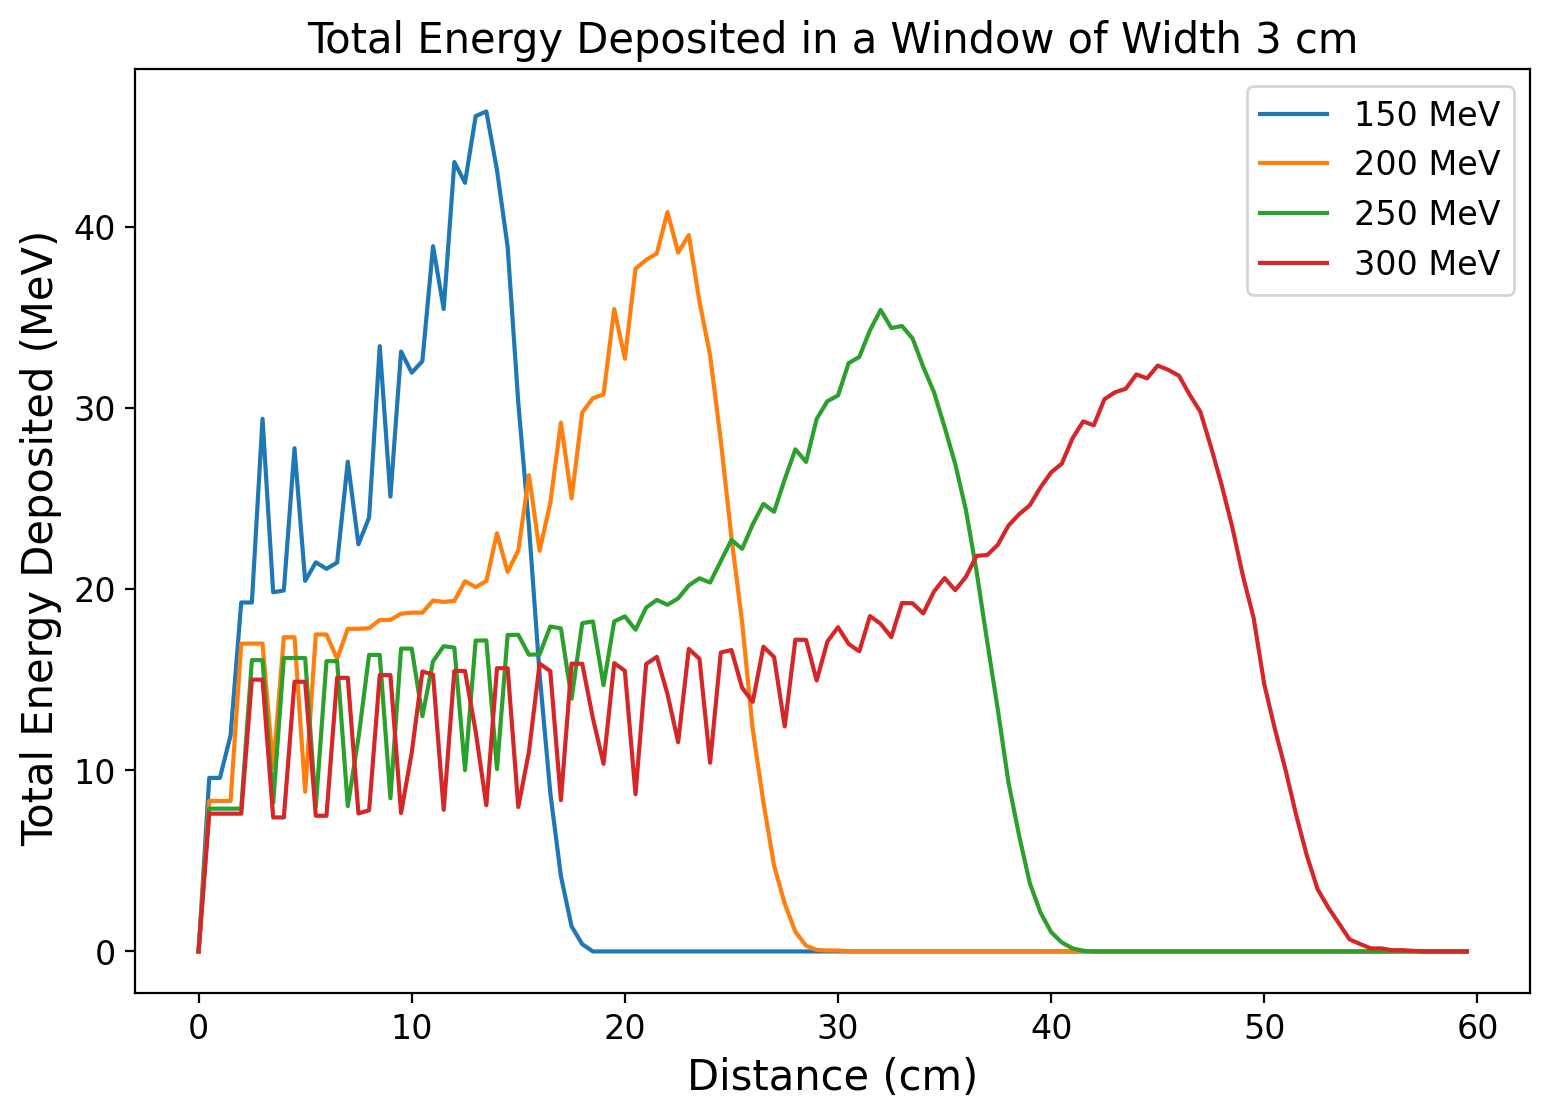

Highest Peak for 150 MeV:
Distance: 13.5 cm, Total Energy Deposited: 46.0 MeV
Highest Peak for 200 MeV:
Distance: 22.0 cm, Total Energy Deposited: 41.0 MeV
Highest Peak for 250 MeV:
Distance: 32.0 cm, Total Energy Deposited: 35.0 MeV


In [49]:
#>>>EXERCISE: L20.4.2

# Define the window width w
w = 3  # cm, change this value as needed

# Define the range of d values
d_values = np.arange(0, 60, 0.5)  # cm, change this range as needed

# Initialize arrays to store total energy deposited for each initial energy and each d value
total_deposited_150 = []
total_deposited_200 = []
total_deposited_250 = []
total_deposited_300 = []

# Calculate total energy deposited in the window for each d value
for d in d_values:
  total_deposited_150.append (np.mean (sumEstepInWindow(estep150, xstep150, d, w)))
  total_deposited_200.append (np.mean (sumEstepInWindow(estep200, xstep200, d, w)))
  total_deposited_250.append (np.mean (sumEstepInWindow(estep250, xstep250, d, w)))
  total_deposited_300.append (np.mean (sumEstepInWindow(estep300, xstep300, d, w)))

# Plot the results
plt.plot(d_values, total_deposited_150, label='150 MeV')
plt.plot(d_values, total_deposited_200, label='200 MeV')
plt.plot(d_values, total_deposited_250, label='250 MeV')
plt.plot(d_values, total_deposited_300, label='300 MeV')
plt.xlabel( 'Distance (cm)')
plt.ylabel( 'Total Energy Deposited (MeV) ')
plt.legend ( )
plt.title( 'Total Energy Deposited in a Window of Width {} cm'. format (w))
plt.show()

# Find the highest peak for each energy
peak_150 = np.argmax(total_deposited_150)
peak_200 = np.argmax(total_deposited_200)
peak_250 = np.argmax(total_deposited_250)
peak_300 = np.argmax(total_deposited_300)


print("Highest Peak for 150 MeV:")
print(f"Distance: {d_values[peak_150]} cm, Total Energy Deposited: {np.round (total_deposited_150[peak_150])} MeV")

print("Highest Peak for 200 MeV:")
print(f"Distance: {d_values[peak_200]} cm, Total Energy Deposited: {np.round (total_deposited_200[peak_200])} MeV")

print("Highest Peak for 250 MeV:")
print(f"Distance: {d_values[peak_250]} cm, Total Energy Deposited: {np.round (total_deposited_250[peak_250])} MeV")

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.4.3</span>

Now, create a plot of beam energy as a function of depth of maximum energy deposition. In other words, determine the Bragg peak for a given beam energy using the tools above, and then create a plot of beam energy vs. Bragg peak location. You can use the same 4 starting kinetic energies considered previously. You may find it helpful to use the `interp1d` function in the `scipy.interpolate` library.

Approximately what beam energy is required to make its maximum energy deposit at a depth of 25 cm? Enter your answer as a number in MeV with precision $\pm 10$.

<br>

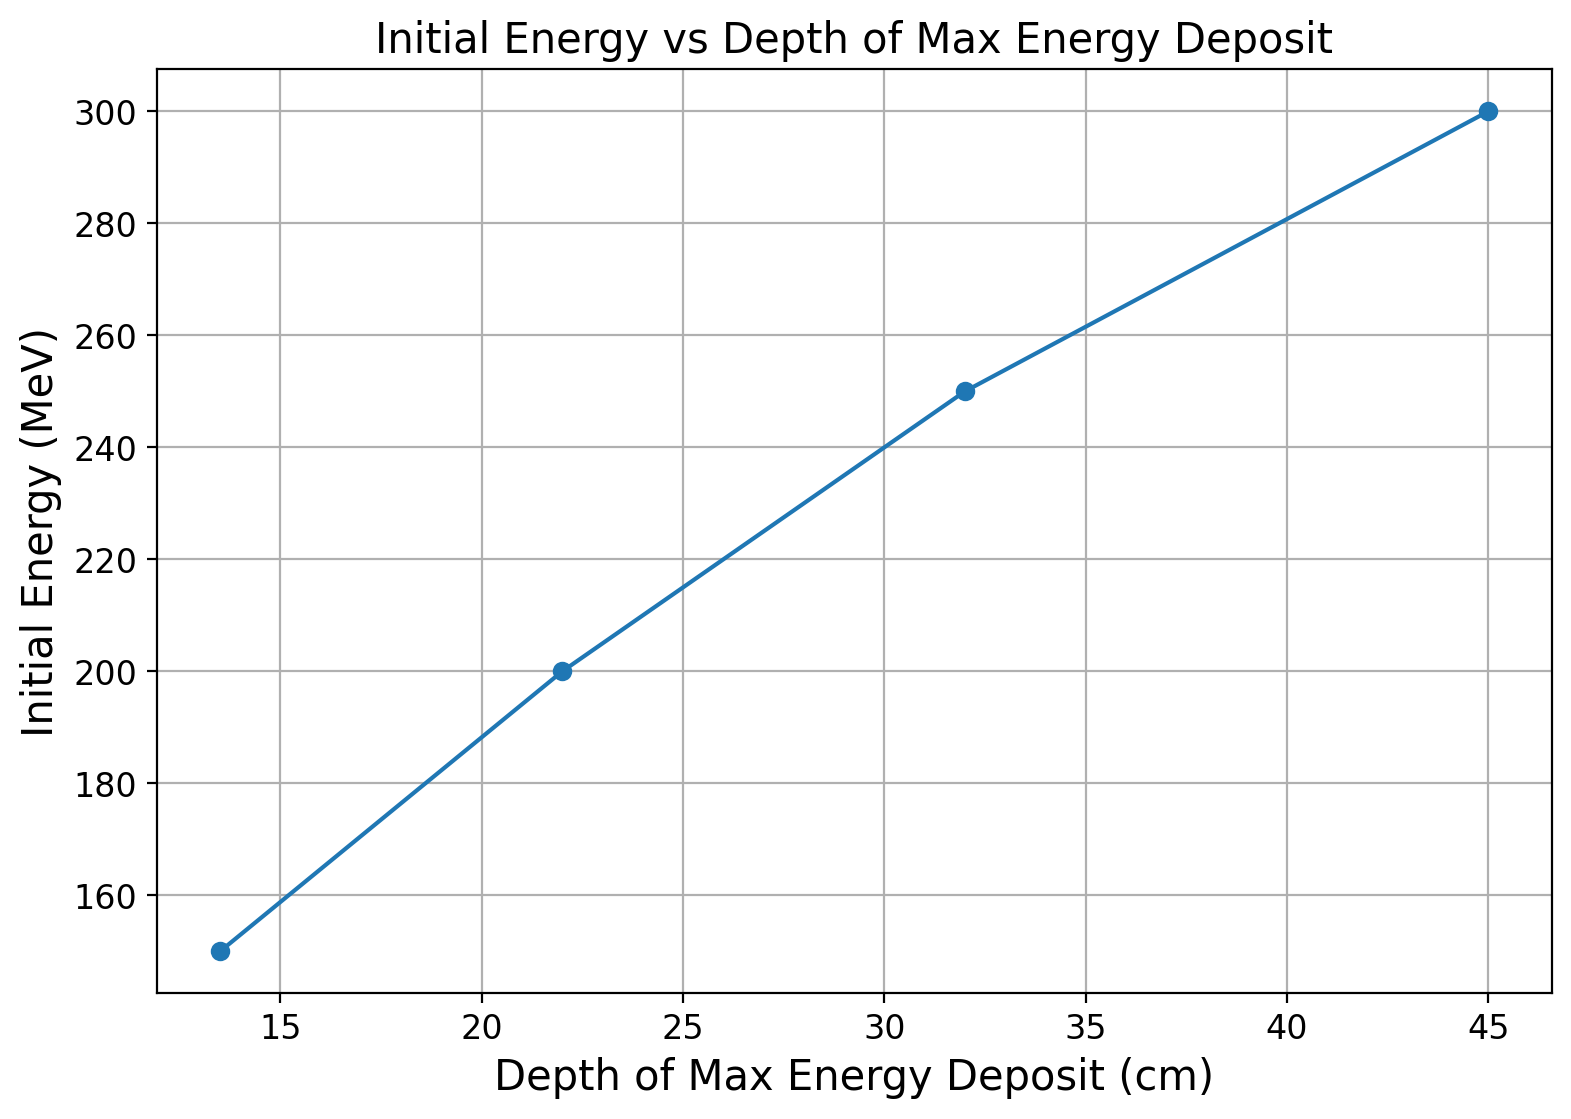

To give a maximum energy deposit at a penetration depth of {desired_depth} cm, the required initial energy is approximately:  215.0


In [51]:
#>>>EXERCISE: L20.4.3

# Define the range of initial energies
initial_energies = [150, 200, 250, 300]
peak_distances = [d_values [peak_150], d_values [peak_200], d_values [peak_250],
d_values [peak_300]]


# Plot the distance of the peak vs initial energy
plt.plot(peak_distances, initial_energies, marker='o')
plt.ylabel('Initial Energy (MeV)')
plt.xlabel('Depth of Max Energy Deposit (cm)')
plt.title('Initial Energy vs Depth of Max Energy Deposit')
plt.grid(True)
plt.show()


# Interpolate the data to find the initial energy required for a desired penetration depth
from scipy.interpolate import interp1d

desired_depth = 25  # cm, change this value as needed

interpolated_func = interp1d(peak_distances, initial_energies, kind='linear')
required_energy = np. round (interpolated_func(desired_depth) )
print("To give a maximum energy deposit at a penetration depth of {desired_depth} cm, the required initial energy is approximately: ", required_energy)

<a name='section_21_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.5 Bragg Scattering for Proton Therapy in Multiple Dimensions </h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_4) | [Exercises](#exercises_21_5) |

In [52]:
#>>>RUN: L20.5-runcell00

#redefining relevant data and functions from above

def A(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lA=[1.00797,4.0026,6.939,9.0122,10.811,12.01115,14.0067,
     15.9994,18.9984,20.183,22.9898,24.312,26.9815,28.088,30.9738,
     32.064,35.453,39.948,39.102,40.08,44.956,47.90,50.942,51.998,
     54.9380,55.847,58.9332,58.71,63.54,65.37,69.72,72.59,74.9216,
     78.96,79.808,83.80,85.47,87.62,88.905,91.22,92.906,95.94,99.0,
     101.07,102.905,106.4,107.87,112.4,114.82,118.69,121.75,127.60,
     126.9044,131.30,132.905,137.34,138.91,
     140.12,140.907,144.24,147.,150.35,151.98,157.25,158.924,162.50,
     164.930,167.26,168.934,173.04,174.97,178.49,180.948,183.85,
     186.2,190.2,192.2,195.08,196.987,200.59,204.37,207.19,208.980,
     210.,210.,222.,223.,226.,227.,232.036,231.,238.03,237.,242.,
     243.,247.,247.,248.,254.,253.
    ]
    lZ=np.arange(1,len(lA)+1)
    if iPlot:
        plt.plot(lZ,lA/lZ)
        plt.xlabel('Z')
        plt.ylabel('A/Z (Atomic mass/Z)')
        plt.show()
    return lA[iZ-1]

def beta(ip,im): #gamma=1/sqrt(1-b^2)
    g=gamma(ip,im)
    return np.sqrt(1-1./g**2)

def gamma(ip,im): #E^2=gamma^2m^2=p^2+m^2
    return np.sqrt(1+(ip/im)**2)

def I(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lI=[19.2,41.8,40.,63.7,76.0,78.0,82.0,95.0,115.,137.,
     149.,156.,166.,173.,173.,180.,174.,188.,190.,191.,216.,233.,245.,
     257.,272.,286.,297.,311.,322.,330.,334.,350.,347.,348.,357.,352.,
     363.,366.,379.,393.,417.,424.,428.,441.,449.,470.,470.,469.,488.,
     488.,487.,485.,491.,482.,488.,491.,501.,523.,535.,546.,560.,574.,
     580.,591.,614.,628.,650.,658.,674.,684.,694.,705.,718.,727.,736.,
     746.,757.,790.,790.,800.,810.,823.,823.,830.,825.,794.,827.,826.,
     841.,847.,878.,890.,902.,921.,934.,939.,952.,966.,980.,994.]
    lZ=np.arange(1,len(lI)+1)
    if iPlot:
        plt.plot(lZ,lI/lZ)
        plt.xlabel('Z')
        plt.ylabel('I$_{adj}$/Z (eV/Z)')
        plt.show()
    return lI[iZ]*1e-6 #MeV not eV

def eToP(iE,im):
    return np.sqrt((iE+im)**2-im**2)

def delta(ip,im):
    C = 4.44
    a = 0.1492
    m = 3.25
    X1 = 2.87
    X0 = 0.2014
    delta0 = 0.14
    x = np.log10(ip/im)
    #f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
    f2 = 2 * x * np.log(10) - C + (a * np.maximum(0, (X1 - x))**m) #using np.maximum to prevent warning when x > X1
    f3 = 2 * x * np.log(10) - C
    delta_full = np.where(x < X0 , 0, f2)
    delta_full = np.where(x < X1, delta_full, f3)
    return delta_full

m_e = 0.511 # Mass of electron in MeV

def landauMPV(ip,im,iZ,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    logterm1 = 2 * m_e *               ((ip/im)**2)/(I(iZ))
    logterm2 = const/I(iZ)
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2     - (beta(ip,im))**2 - delta(ip,im))       #
    return dEdxV,const

def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

6.36964816414323


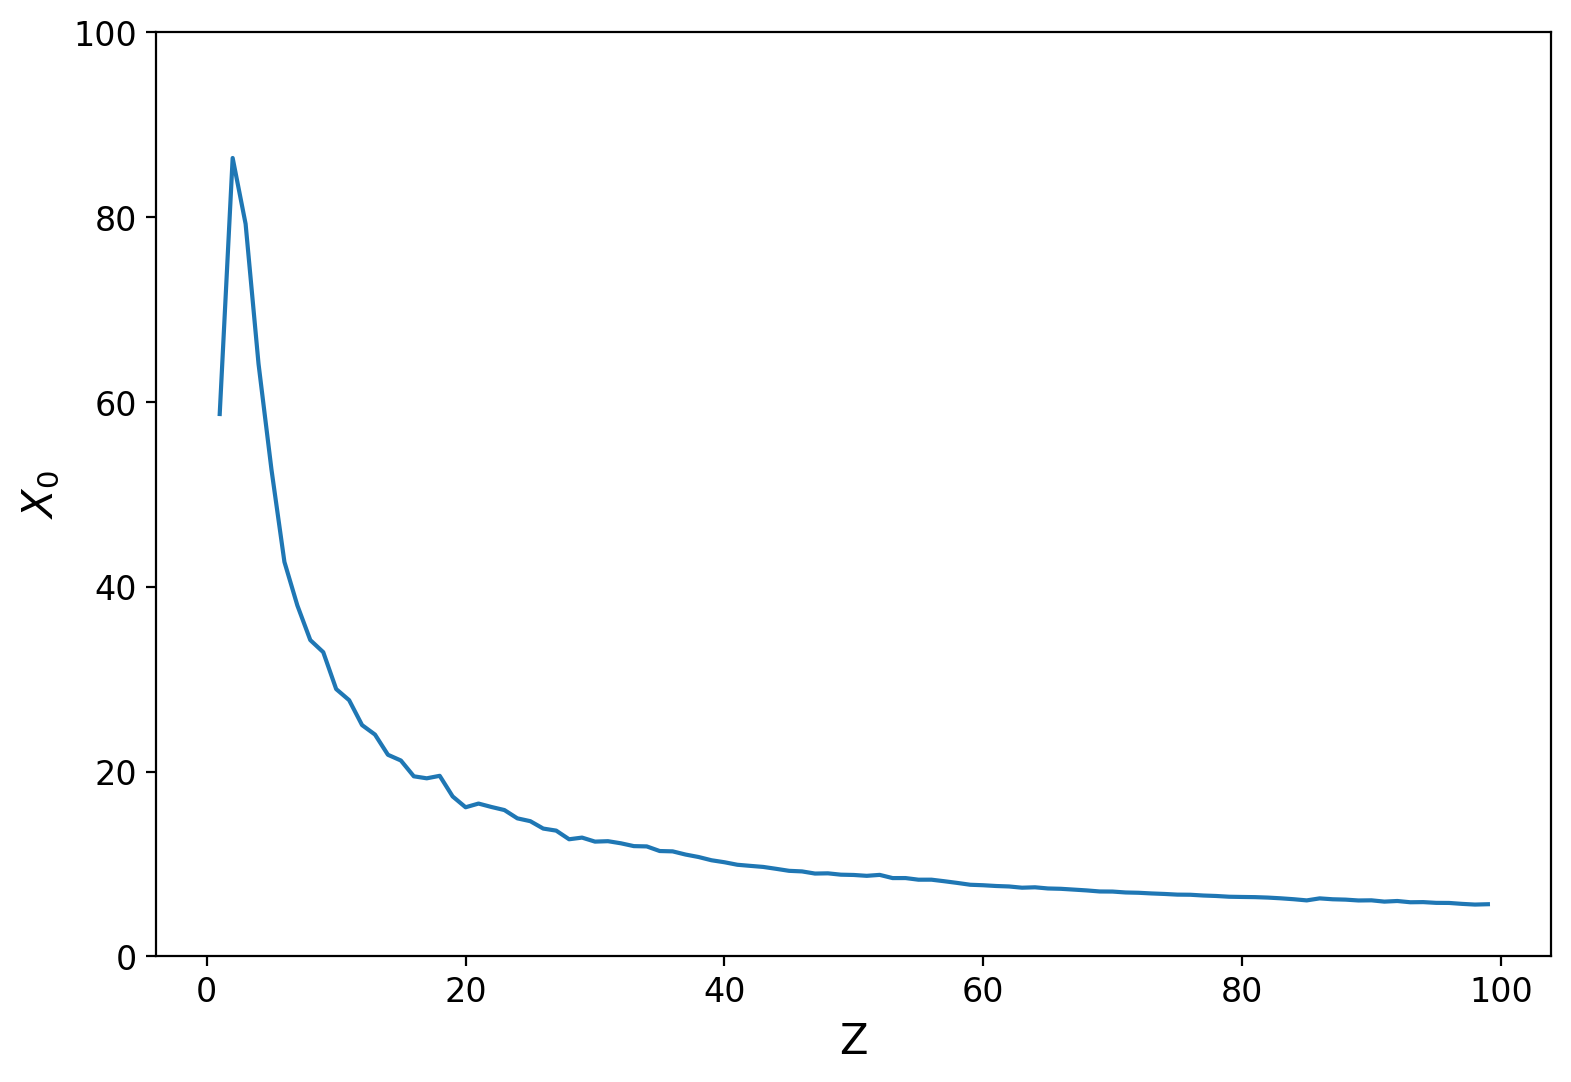

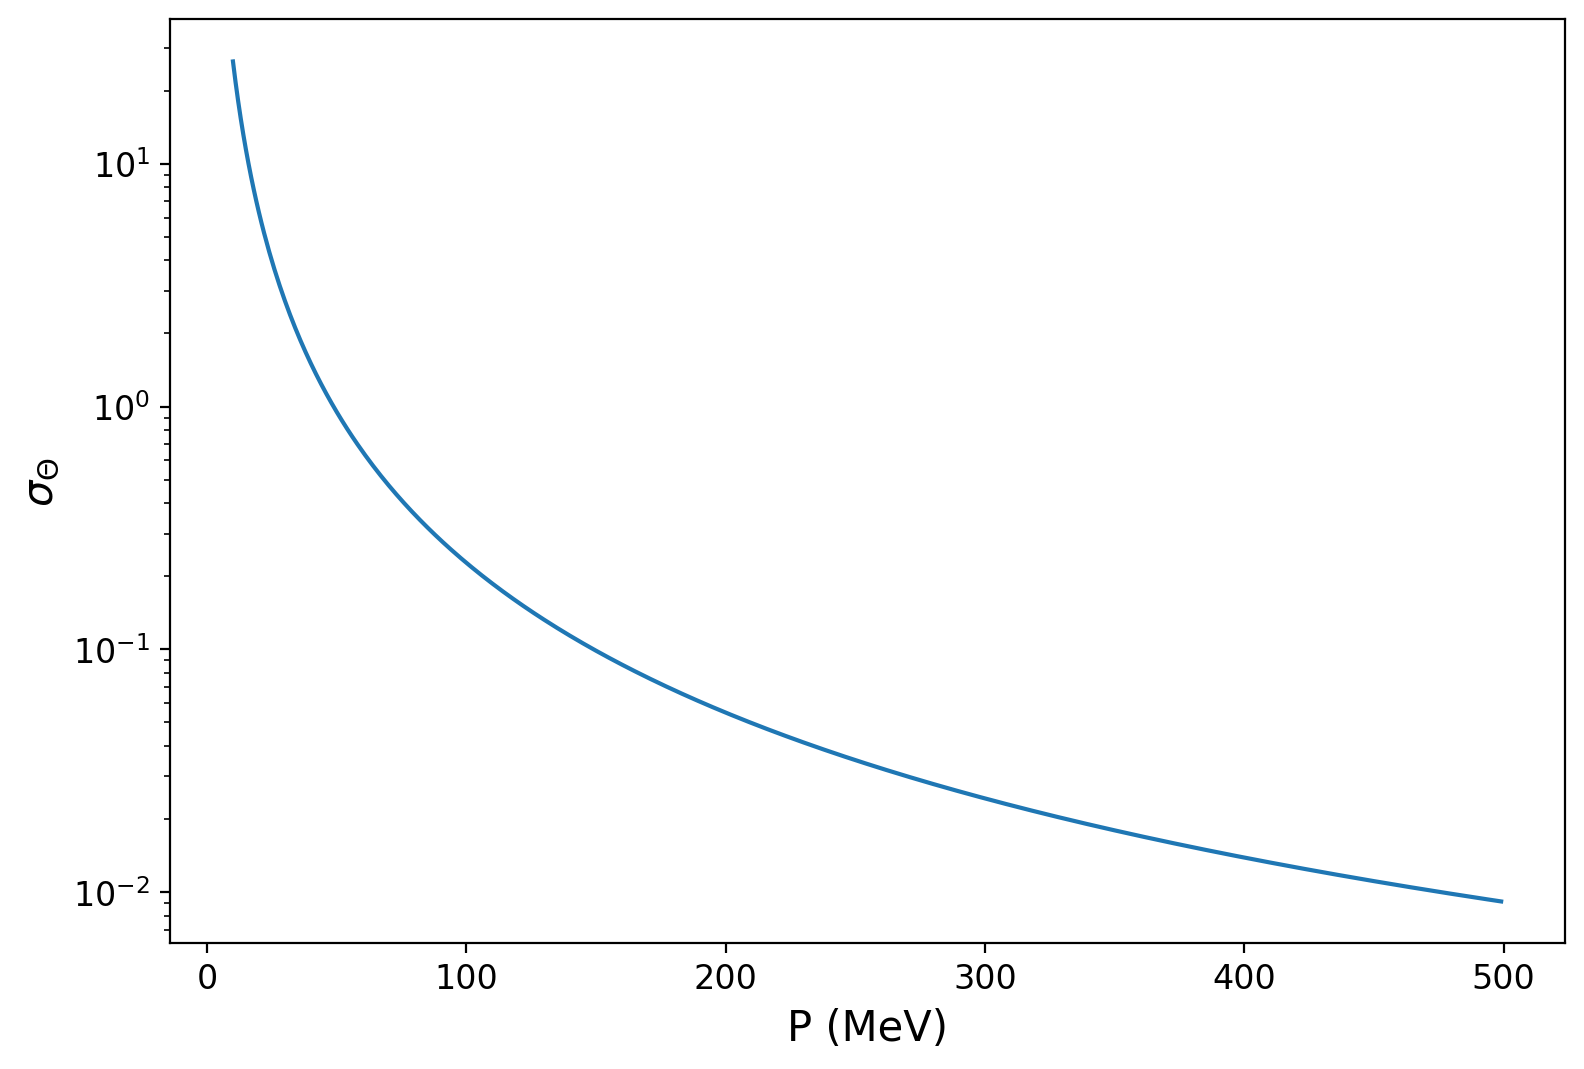

In [53]:
#>>>RUN: L20.5-runcell01

def X0(iZ):
    const=(716.408**-1)/A(iZ)
    a = iZ/137.
    Lrad =np.log(184.15*iZ**(-1./3.))
    Lradp=np.log(1194*iZ**(-2./3.))
    fZ = a**2*((1+a**2)**(-1)+0.20206-0.0369*a**2+0.0083*a**4-0.002*a**6)
    val=const*(iZ**2*(Lrad-fZ)+iZ*Lradp)
    return 1./val

def sigmaTheta(ip,im,iX0,idx=1.0,zpart=1):
    C=13.6
    X0=iX0
    dx=idx/iX0
    const=C/(beta(ip,im)*ip)*zpart*np.sqrt(dx)
    logterm=1+0.038*np.log(dx*zpart**2/beta(ip,im)**2)
    return const*logterm

def thetaScatter(ip,im,iX0,idx,zpart=1):
    z1=np.random.normal(0,1,ip.shape[0])
    z2=np.random.normal(0,1,ip.shape[0])
    stheta=sigmaTheta(ip,im,iX0,zpart)
    dy    =z1*idx*stheta/np.sqrt(12.) + z2*idx*stheta/2
    dtheta=z2*stheta
    return dtheta,dy

lZ=np.arange(1,100,1)
lX0=np.zeros(len(lZ))
for pZ in lZ:
    lX0[pZ-1] = X0(pZ)
print(X0(82))
plt.plot(lZ,lX0)
plt.xlabel("Z")
plt.ylabel("$X_{0}$")
plt.ylim(0,100)
plt.show()

lP=np.arange(10,500,1)
mproton=938  # Mass of proton in MeV
lST = sigmaTheta(lP,mproton,X0(8))
plt.plot(lP,lST)
plt.yscale('log')
plt.xlabel('P (MeV)')
plt.ylabel('$\sigma_{\Theta}$')
plt.show()

Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


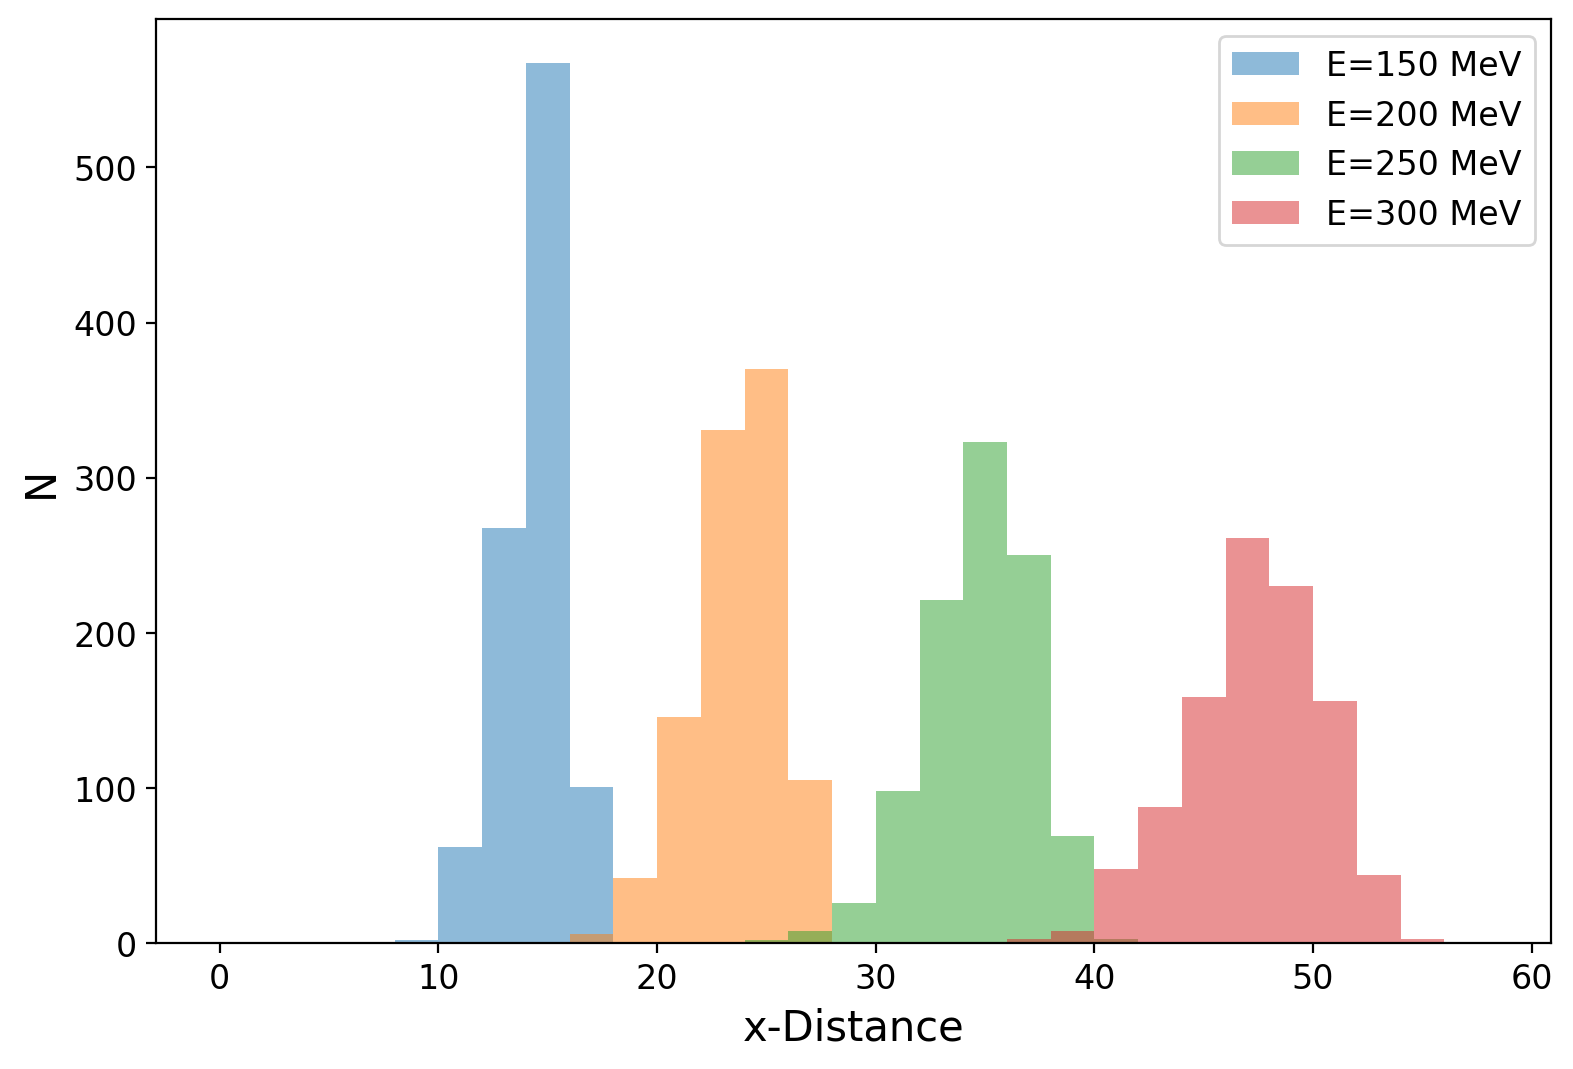

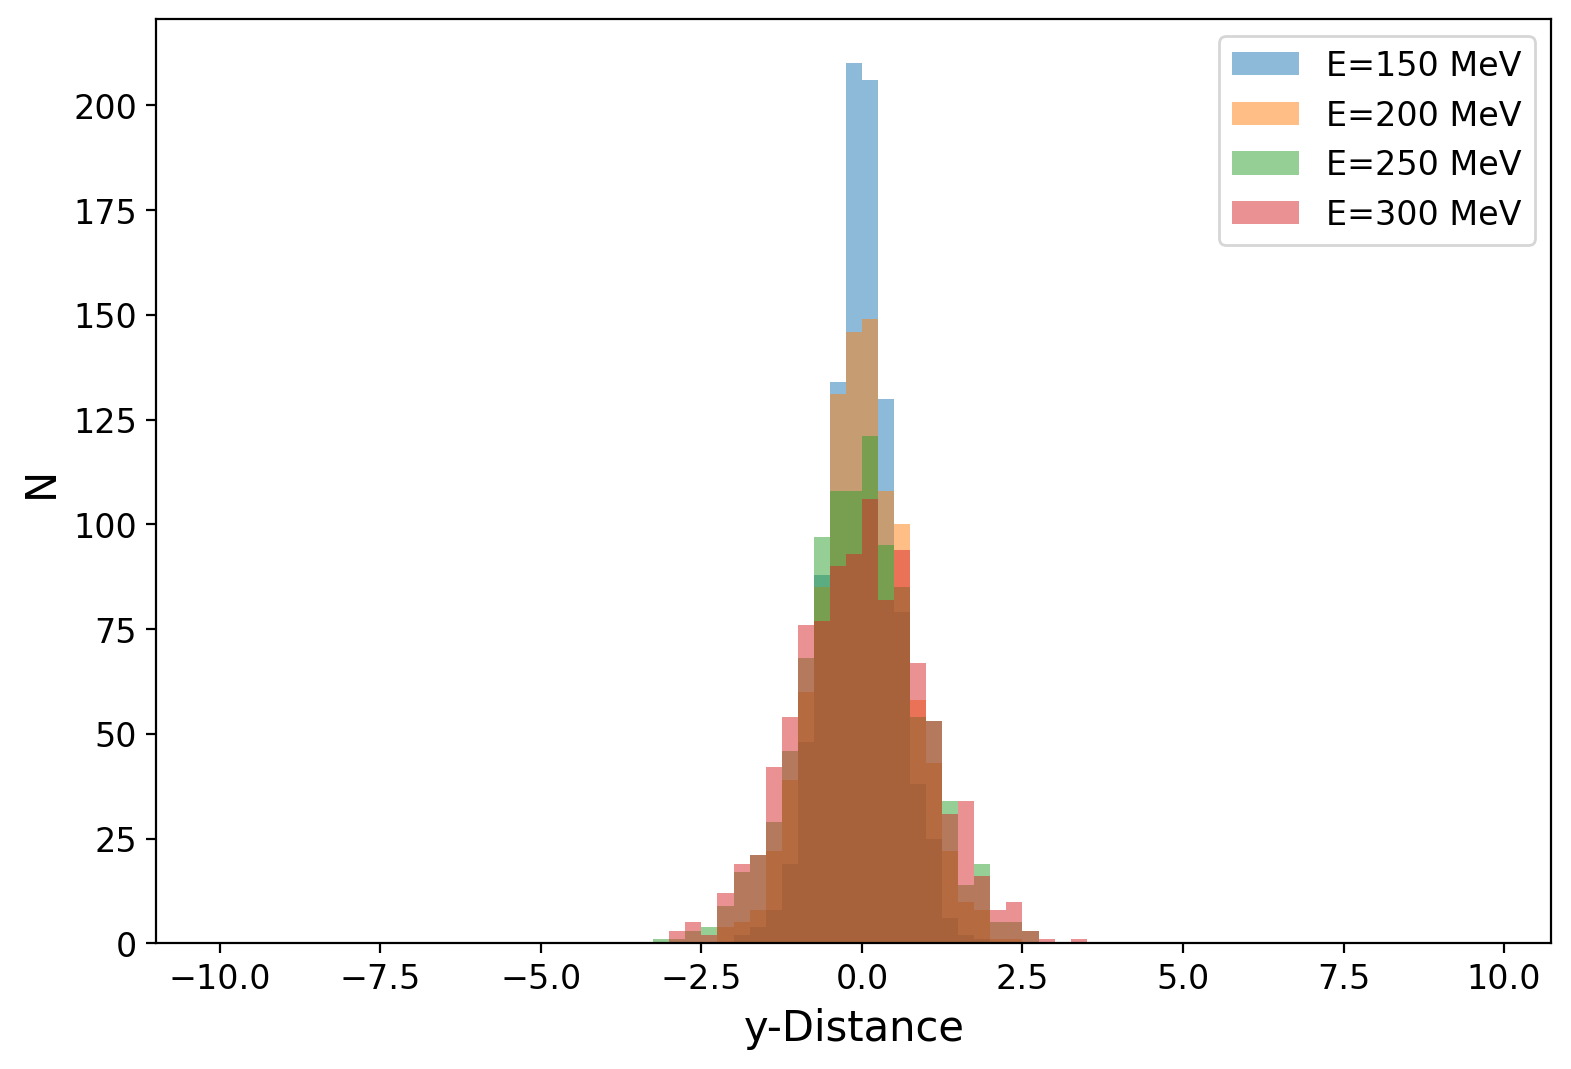

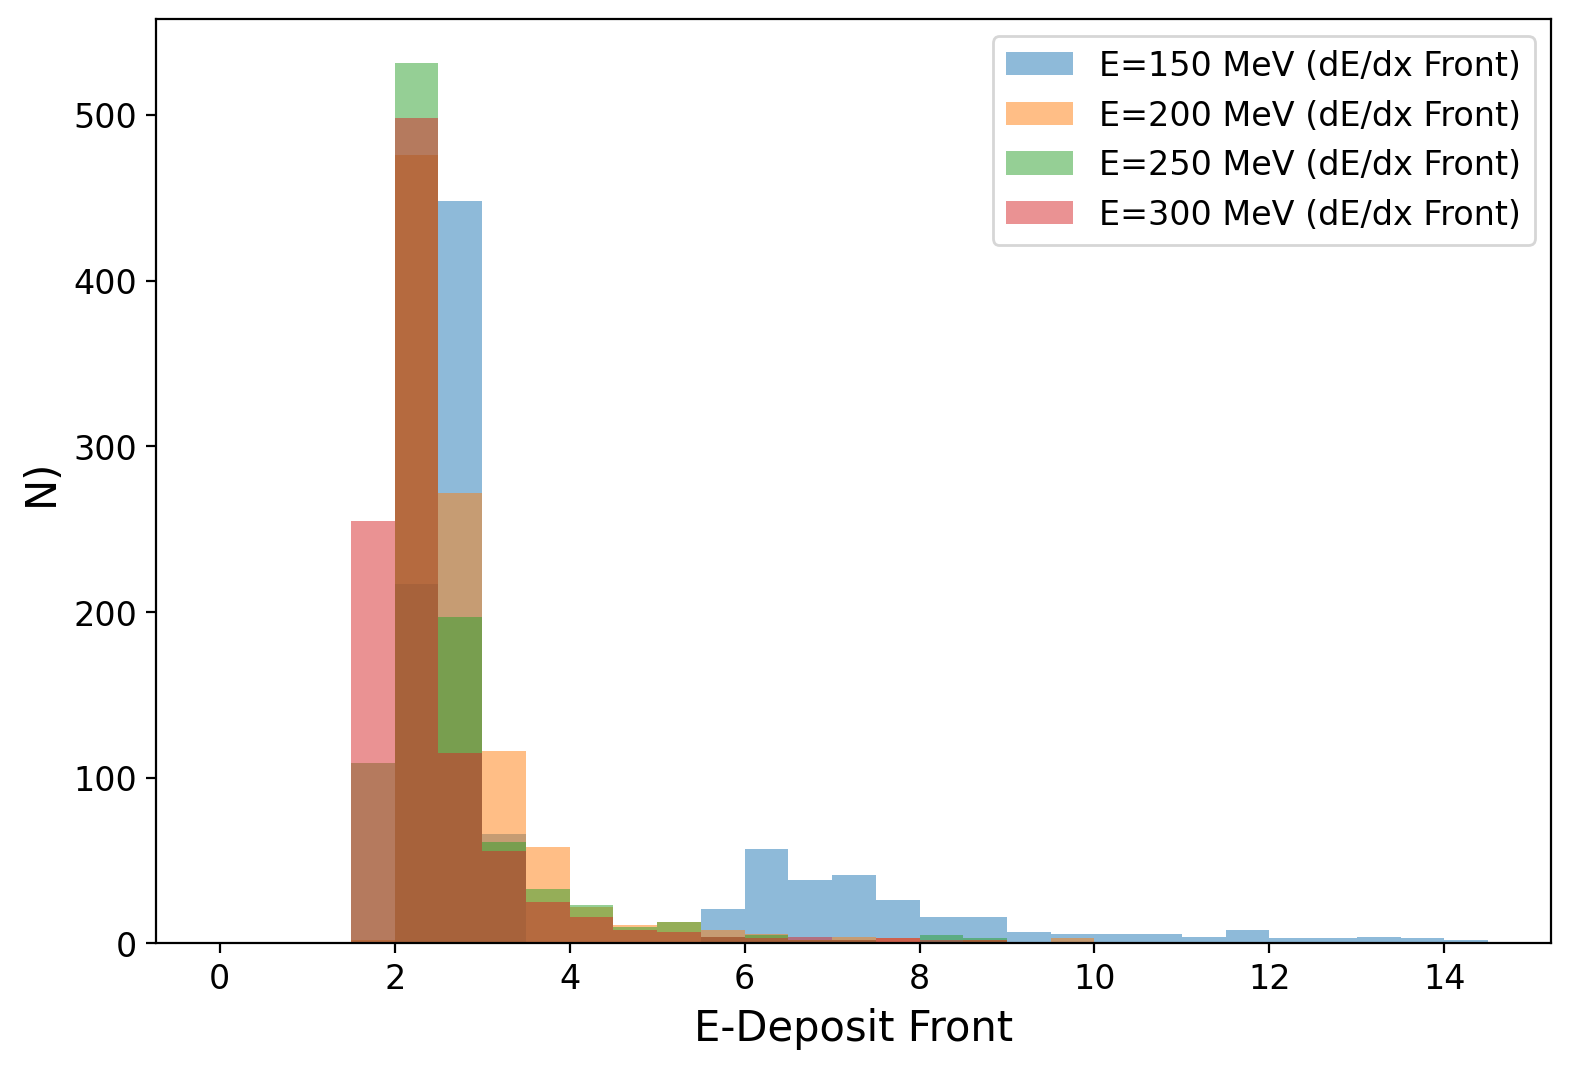

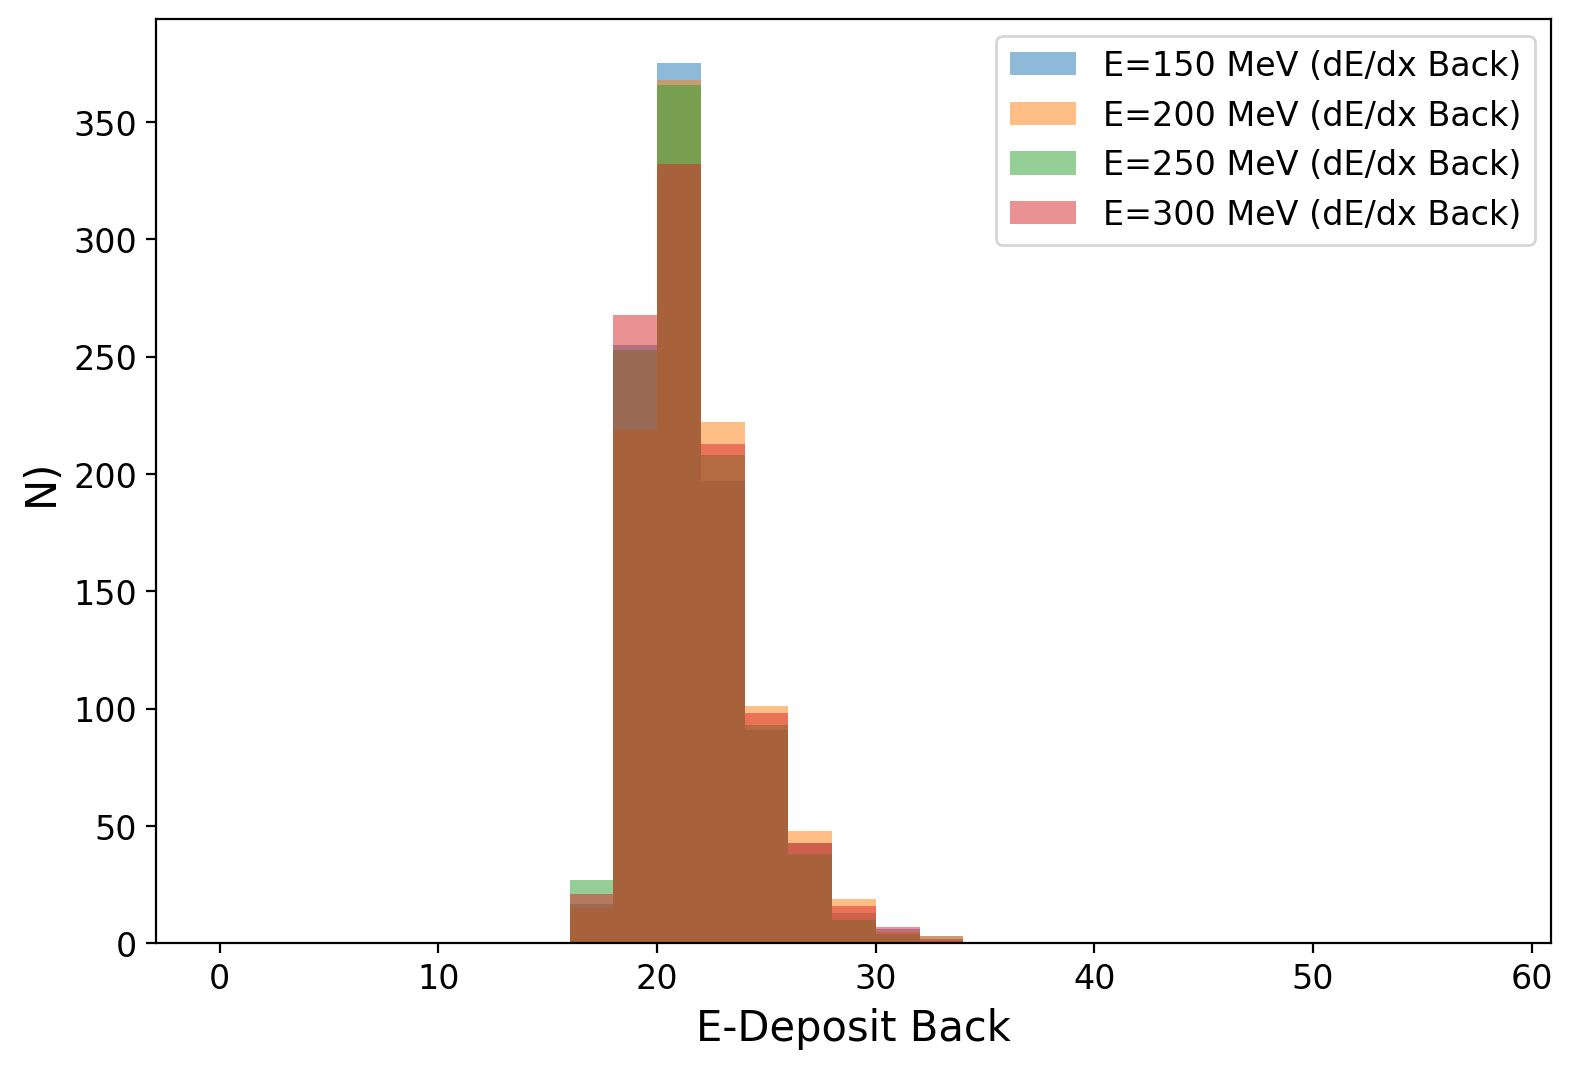

In [54]:
#>>>RUN: L20.5-runcell02

def simNYParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    ystep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    theta=0
    y=0
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    lX0 = X0(iZ)
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        dTheta,dy = thetaScatter(p,im,lX0,idx=dx,zpart=1)
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx*np.cos(theta)
        y      += dy + np.sin(theta)*dx
        theta  += dTheta
        xstep  = np.vstack((xstep,dist))
        ystep  = np.vstack((ystep,y))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    ystep = ystep.T
    return xstep,pstep,estep,ystep

xstep150,pstep150,estep150,ystep150=simNYParallelSample(ie=150,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep200,pstep200,estep200,ystep200=simNYParallelSample(ie=200,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep250,pstep250,estep250,ystep250=simNYParallelSample(ie=250,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep300,pstep300,estep300,ystep300=simNYParallelSample(ie=300,im=mproton,iN=1000,idt=1e-10,iZ=8)

xrange=np.arange(0,60,2)
plt.hist(xstep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.xlabel('x-Distance')
plt.ylabel('N')
plt.legend()
plt.show()

xrange=np.arange(-10,10,0.25)
plt.hist(ystep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(ystep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(ystep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(ystep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.xlabel('y-Distance')
plt.ylabel('N')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,15,0.5)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.xlabel('E-Deposit Front')
plt.ylabel('N)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.xlabel('E-Deposit Back')
plt.ylabel('N)')
plt.legend()
plt.show()


In [ ]:
#>>>RUN: L20.5-runcell03

def plotImage(iId,ixstep,iestep,iystep):
    #plt.plot(ixstep[iId],iystep[iId])#,iestep[iId])
    #plt.show()
    #Now let's make a regular image
    xbin = np.arange(-1,55, 2)
    ybin = np.arange(-3.75, 3.75, 0.25)
    #xbin = np.arange(-0.5,60.5, 1)
    #ybin = np.arange(-5.125, 5.125, 0.25)
    print("A:",len(ixstep.flatten()),len(iystep.flatten()),len(iestep.flatten()))
    H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())
    plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.show()
    #X, Y = np.meshgrid(xedges, yedges)
    #plt.pcolormesh(X,Y,H.T)
    #plt.show()

plotImage(-1,xstep150,estep150,ystep150)
plotImage(-1,xstep200,estep200,ystep200)
plotImage(-1,xstep250,estep250,ystep250)
plotImage(-1,xstep300,estep300,ystep300)

<a name='exercises_21_5'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_5) | [Next Section](#section_21_6) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-20.5.1</span>

Construct the same plot as in the exercise `Ex-20.4.3`, but now using this more realistic scattering model. Specifically, create a plot of beam energy vs Bragg peak location. Again, determine the approximate beam energy that is required to make a maximum energy deposit at a depth of 25 cm.

How are the results of the more realistic model presented in this section different from those of the simplified model? Select ALL that apply:

A) The Bragg peaks are shifted farther out in distance.\
B) The Bragg peaks are shifted closer in distance.\
C) The Bragg peak positions are approximately unchanged.\
D) The Bragg peaks are wider.\
E) The Bragg peaks are narrower.\
F) The width of the Bragg peaks are approximately unchanged.


<br>